In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
pd.options.display.max_columns = None

In [3]:
df = pd.read_excel("/kaggle/input/dano2025-voronovofilesfromgithub/5_with_region_index_2024_population_patched_with_flags.xlsx")

In [138]:
df.head()

new_id  Месяц  Школы (300 м)      Трафик Учебный_период  Есть_школа
0    1102      5              0  382.096021    Учебный год           0
1    1435      7              0  618.767939       Каникулы           0
2    1860      8              1  463.538270       Каникулы           1
3    1270      1              2  570.115966    Учебный год           1
4    1106      6              1  538.328787       Каникулы           1

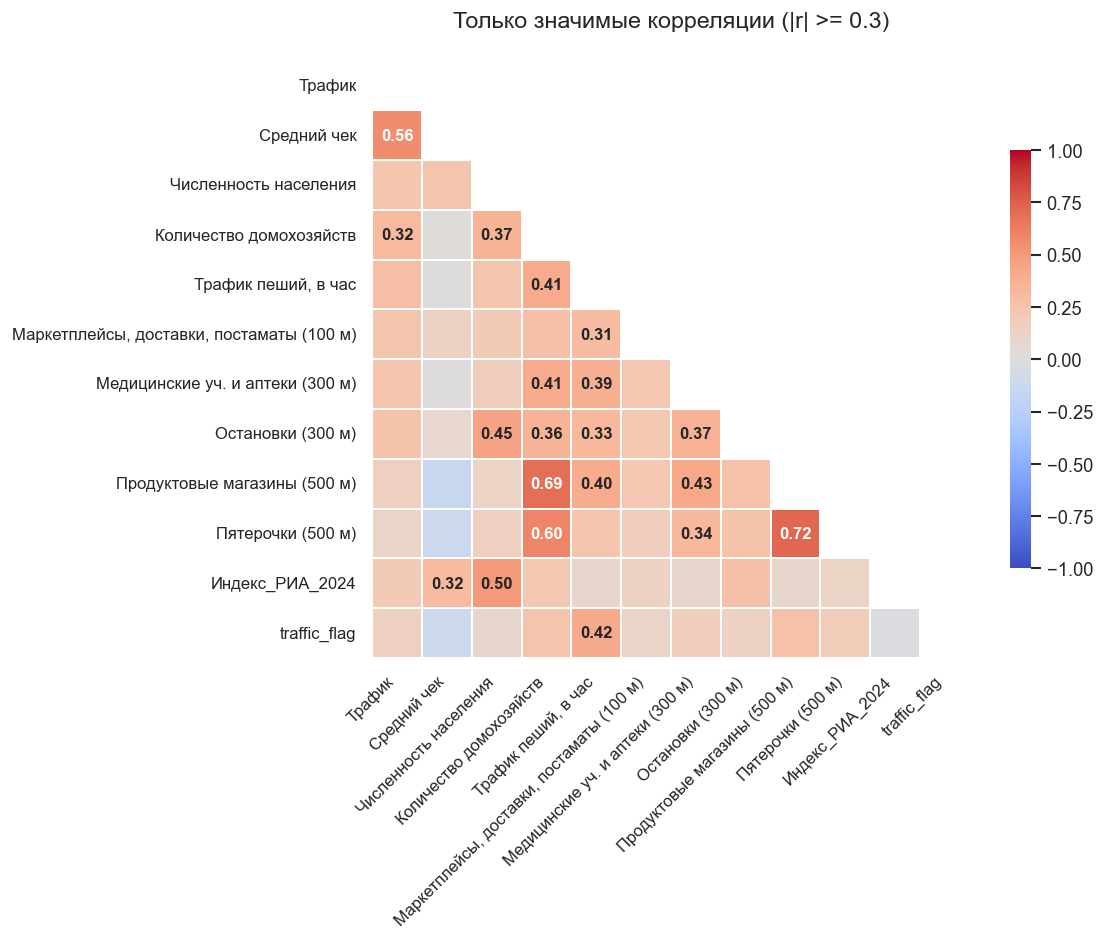

In [33]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

df = pd.read_excel("Х5_with_region_index_2024_population_patched_with_flags.xlsx")
cols = num_df.columns
corr = num_df.corr(method='pearson')

# Расчет p-value
pvals = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        if i != j:
            r, p = pearsonr(num_df.iloc[:, i], num_df.iloc[:, j])
            pvals.iloc[i, j] = p
            pvals.iloc[j, i] = p
        else:
            pvals.iloc[i, j] = 0.0

# Параметры отсечения
alpha = 0.05
corr_thr = 0.3

# --- 2. ФИЛЬТРАЦИЯ (Убираем пустые) ---

# Создаем маску значимых связей
# (p-value < 0.05) И (|корреляция| > 0.3)
sig_matrix = (pvals < alpha) & (corr.abs() >= corr_thr)

# Важно: заполняем диагональ False, чтобы признак не оставался только 
# из-за связи с самим собой (где r=1)
np.fill_diagonal(sig_matrix.values, False)

# Оставляем только те признаки, у которых есть хотя бы одна True в строке
keep_cols = sig_matrix.any(axis=1)
cols_to_plot = keep_cols[keep_cols].index

if len(cols_to_plot) > 1:
    # Фильтруем матрицы
    corr_final = corr.loc[cols_to_plot, cols_to_plot]
    pvals_final = pvals.loc[cols_to_plot, cols_to_plot]
    
    # --- 3. Подготовка графика ---
    
    # Маска для аннотаций (цифры только там, где значимо)
    annot_labels = corr_final.copy().astype(str)
    for i in range(len(cols_to_plot)):
        for j in range(len(cols_to_plot)):
            # Проверяем условие значимости для отфильтрованных данных
            is_sig = (pvals_final.iloc[i, j] < alpha) and (abs(corr_final.iloc[i, j]) >= corr_thr)
            if not is_sig:
                annot_labels.iloc[i, j] = "" 
            else:
                annot_labels.iloc[i, j] = f"{corr_final.iloc[i, j]:.2f}"

    # Маска треугольника (чтобы не дублировать верхнюю часть)
    mask_tri = np.triu(np.ones_like(corr_final, dtype=bool))

    # --- 4. Рисуем ---
    plt.figure(figsize=(10, 8), dpi=120)
    sns.set(style="white")

    ax = sns.heatmap(
        corr_final,
        mask=mask_tri,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        annot=annot_labels,
        fmt='',
        annot_kws={'size': 10, 'fontweight': 'bold'},
        linewidths=1,
        linecolor='white',  # Белая сетка для чистоты
        cbar_kws={"shrink": 0.7}
    )

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(f'Только значимые корреляции (|r| >= {corr_thr})', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

else:
    print("Нет корреляций, удовлетворяющих условиям порогов.")

In [ ]:
Самый элегантный способ совместить тепловую карту корреляций и диаграммы рассеивания — это использовать **PairGrid**.

Мы сделаем так:
1. **Нижний треугольник (слева):** Красивые квадраты с цифрами корреляции (как тепловая карта).
2. **Верхний треугольник (справа):** Диаграммы рассеивания (Scatter plots) с линией тренда, чтобы видеть форму зависимости.
3. **Диагональ:** Гистограмма распределения самой переменной.

В этот код уже встроена **фильтрация** (удаляются столбцы без значимых связей), чтобы график не был огромным и пустым.

```python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import Normalize
from matplotlib import cm

# --- 1. Подготовка и Фильтрация (оставляем только значимые столбцы) ---
# num_df = df.select_dtypes(include=np.number) # Раскомментируйте, если num_df еще нет
cols = num_df.columns
corr = num_df.corr(method='pearson')

# Считаем p-values для фильтрации
pvals = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        if i != j:
            _, p = pearsonr(num_df.iloc[:, i], num_df.iloc[:, j])
            pvals.iloc[i, j] = p

# Пороги
alpha = 0.05
corr_thr = 0.3

# Логика отбора: оставляем столбец, если у него есть хотя бы одна связь с ДРУГИМ столбцом
sig_matrix = (pvals < alpha) & (corr.abs() >= corr_thr)
np.fill_diagonal(sig_matrix.values, False) # Игнорируем диагональ
keep_cols = sig_matrix.any(axis=1)
cols_to_plot = keep_cols[keep_cols].index

if len(cols_to_plot) < 2:
    print("Слишком мало значимых корреляций для построения графика.")
else:
    df_plot = num_df[cols_to_plot]

    # --- 2. Функция для отрисовки "Тепловой карты" в нижнем треугольнике ---
    def heatmap_lower(x, y, **kwargs):
        # Считаем корреляцию и p-value для текущей пары x, y
        r, p = pearsonr(x, y)
        
        # Получаем текущую ось
        ax = plt.gca()
        
        # Проверяем значимость
        is_sig = (p < alpha) and (abs(r) >= corr_thr)
        
        if is_sig:
            # Выбираем цвет фона в зависимости от R
            # Используем colormap 'coolwarm': синий для отриц., красный для полож.
            norm = Normalize(vmin=-1, vmax=1)
            cmap = cm.get_cmap('coolwarm')
            color = cmap(norm(r))
            
            # Закрашиваем фон ячейки
            ax.set_facecolor(color)
            
            # Пишем текст (черный или белый в зависимости от насыщенности цвета)
            text_color = 'white' if abs(r) > 0.6 else 'black'
            ax.text(0.5, 0.5, f"{r:.2f}", 
                    transform=ax.transAxes, 
                    ha='center', va='center', 
                    fontsize=12, fontweight='bold', color=text_color)
        else:
            # Если не значимо - серый фон или пустота
            ax.set_facecolor('#f7f7f7') # очень светло-серый
        
        # Убираем оси и тики для красоты в текстовой части
        ax.set_xticks([])
        ax.set_yticks([])

    # --- 3. Построение PairGrid ---
    plt.figure(figsize=(12, 12), dpi=100)
    
    # Создаем сетку графиков
    g = sns.PairGrid(df_plot, diag_sharey=False, corner=False)

    # ВЕРХНИЙ ТРЕУГОЛЬНИК: Диаграммы рассеивания + Линия тренда
    # scatter_kws={'s': 10, 'alpha': 0.5} делает точки полупрозрачными и маленькими
    # line_kws={'color': 'red'} делает линию тренда красной
    g.map_upper(sns.regplot, scatter_kws={'s': 10, 'alpha': 0.4}, 
                line_kws={'color': '#333333', 'linewidth': 1}, ci=None)

    # ДИАГОНАЛЬ: Распределение (гистограмма + линия плотности)
    g.map_diag(sns.histplot, kde=True, color='gray')

    # НИЖНИЙ ТРЕУГОЛЬНИК: Наша кастомная функция тепловой карты
    g.map_lower(heatmap_lower)

    # Настройка заголовка
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle(f'Матрица корреляций и диаграммы рассеивания\n(Показаны только параметры с корреляцией >= {corr_thr})', 
                   fontsize=16)
    
    plt.show()
```

### В чем красота этого графика:
1.  **Информативность 3-в-1**:
    *   **Справа сверху:** Вы видите *реальные данные* (точки). Это позволяет заметить выбросы или нелинейные зависимости, которые простое число "0.7" скрывает.
    *   **Слева снизу:** Чистая математика (коэффициент корреляции), подсвеченная цветом.
    *   **Диагональ:** Вы видите, как распределены данные (нормальное распределение или нет).
2.  **Умная раскраска**: Ячейки закрашиваются в `coolwarm` (синий-красный) только если связь статистически значима.
3.  **Читаемость**: На цветном фоне текст автоматически меняется на белый, чтобы его было видно.

C:\Users\User\AppData\Local\Temp\ipykernel_32020\710256733.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')
C:\Users\User\AppData\Local\Temp\ipykernel_32020\710256733.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')
C:\Users\User\AppData\Local\Temp\ipykernel_32020\710256733.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')
C:\Users\User\AppData\Local\Temp\ipyk

<Figure size 3000x3000 with 0 Axes>

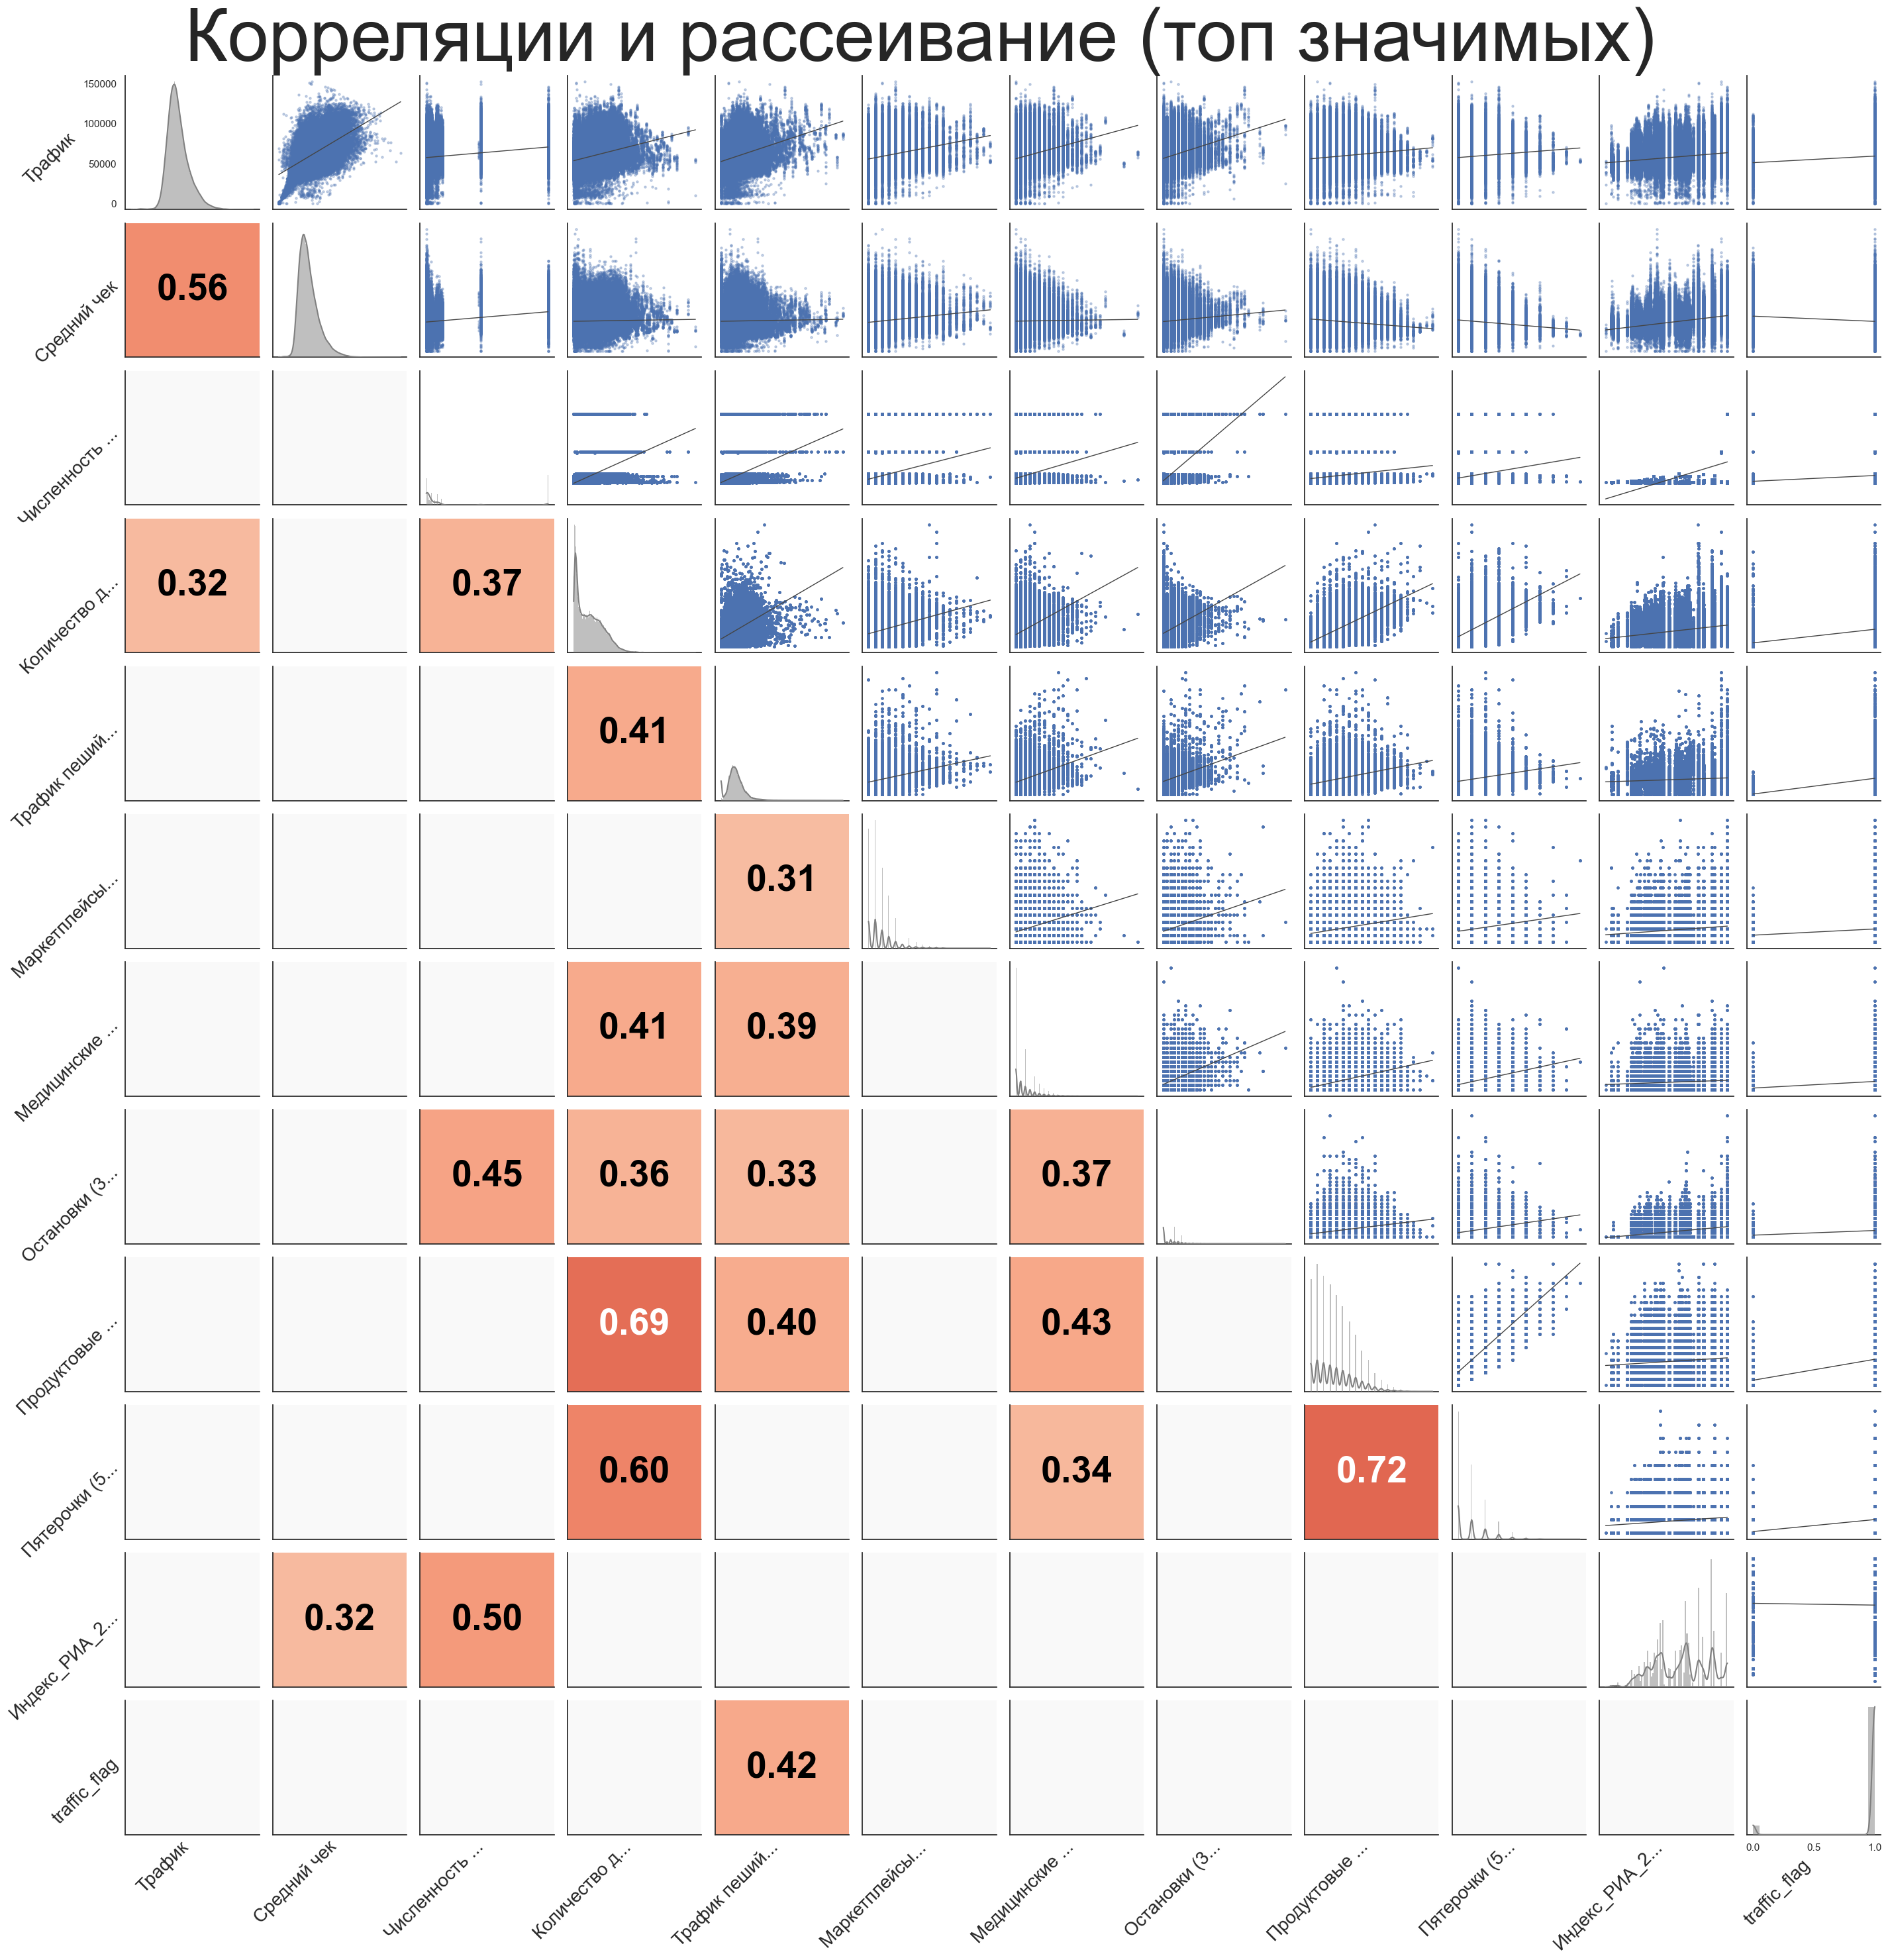

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import Normalize
from matplotlib import cm

# --- 1. Настройки и фильтрация ---
# num_df = df.select_dtypes(include=np.number) # Ваш исходный df
cols = num_df.columns
corr = num_df.corr(method='pearson')

# Считаем p-value
pvals = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        if i != j:
            _, p = pearsonr(num_df.iloc[:, i], num_df.iloc[:, j])
            pvals.iloc[i, j] = p

# Пороги
alpha = 0.05
corr_thr = 0.3

# Оставляем только значимые столбцы
sig_matrix = (pvals < alpha) & (corr.abs() >= corr_thr)
np.fill_diagonal(sig_matrix.values, False)
keep_cols = sig_matrix.any(axis=1)
cols_to_plot = keep_cols[keep_cols].index

if len(cols_to_plot) < 2:
    print("Мало данных для графика.")
else:
    # --- 2. Улучшение читаемости названий ---
    # Создаем копию данных для графика
    df_plot = num_df[cols_to_plot].copy()
    
    # Функция для сокращения длинных названий
    # "Количество домохозяйств" -> "Количество..."
    def shorten_name(name, limit=12):
        if len(str(name)) > limit:
            return str(name)[:limit] + "..."
        return str(name)
    
    new_names = {col: shorten_name(col) for col in df_plot.columns}
    df_plot.rename(columns=new_names, inplace=True)
    
    # Вычисляем размер шрифта динамически
    # Если графиков мало (5) - шрифт 14, если много (15) - шрифт 8
    n_vars = len(df_plot.columns)
    dynamic_font_size = max(40, int(24 - n_vars)) 
    
    # --- 3. Функция тепловой карты ---
    def heatmap_lower(x, y, **kwargs):
        r, p = pearsonr(x, y)
        ax = plt.gca()
        is_sig = (p < alpha) and (abs(r) >= corr_thr)
        
        if is_sig:
            norm = Normalize(vmin=-1, vmax=1)
            cmap = cm.get_cmap('coolwarm')
            ax.set_facecolor(cmap(norm(r)))
            
            text_color = 'white' if abs(r) > 0.6 else 'black'
            
            # Используем динамический шрифт
            ax.text(0.5, 0.5, f"{r:.2f}", 
                    transform=ax.transAxes, ha='center', va='center', 
                    fontsize=dynamic_font_size, fontweight='bold', color=text_color)
        else:
            ax.set_facecolor('#f9f9f9')
            
        ax.set_xticks([])
        ax.set_yticks([])

    # --- 4. Построение ---
    # Увеличиваем размер фигуры (14x14 для простора)
    plt.figure(figsize=(30, 30), dpi=100)
    
    g = sns.PairGrid(df_plot, diag_sharey=False, corner=False)

    # Верх: Точки (делаем их мельче s=5, чтобы не сливались в кашу)
    g.map_upper(sns.regplot, scatter_kws={'s': 5, 'alpha': 0.3}, 
                line_kws={'color': '#444444', 'linewidth': 1}, ci=None)

    # Диагональ: Распределение
    g.map_diag(sns.histplot, kde=True, color='gray', linewidth=0)

    # Низ: Корреляция
    g.map_lower(heatmap_lower)

    # --- 5. Финальная полировка осей ---
    # Проходимся по всем внешним осям и поворачиваем текст
    for ax in g.axes.flatten():
        if ax:
            # Получаем подписи осей
            xlabel = ax.get_xlabel()
            ylabel = ax.get_ylabel()
            
            # Если есть подпись, обновляем её с поворотом и размером
            if xlabel:
                ax.set_xlabel(xlabel, fontsize=20, rotation=45, ha='right')
            if ylabel:
                ax.set_ylabel(ylabel, fontsize=20, rotation=45, ha='right')

    # Добавляем отступы между графиками, чтобы текст влез
    plt.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.1, left=0.1)
    
    g.fig.suptitle(f'Корреляции и рассеивание (топ значимых)', y=1.02, fontsize=80)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_32020\3794561558.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Школы (300 м)', y='Трафик', ax=axes[0], palette="Blues")
C:\Users\User\AppData\Local\Temp\ipykernel_32020\3794561558.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Школы (300 м)', y='Средний чек', ax=axes[1], palette="Oranges")


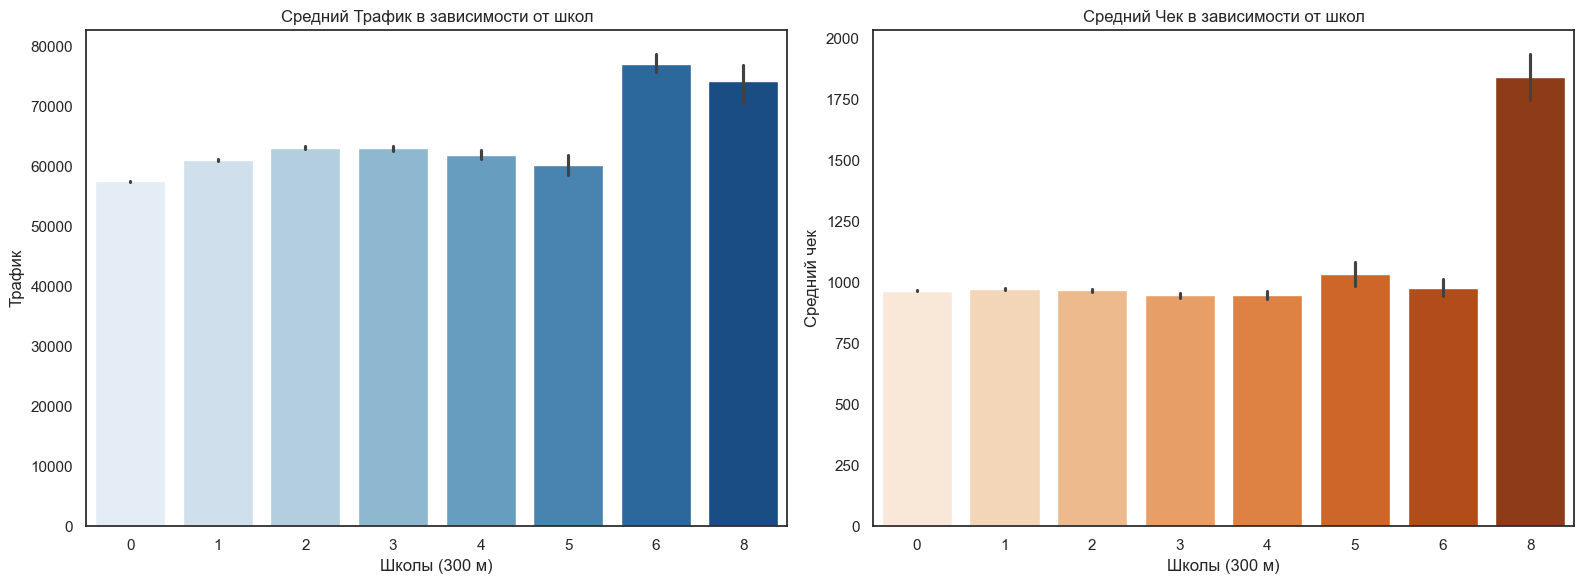

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Используем barplot вместо boxplot
sns.barplot(data=df, x='Школы (300 м)', y='Трафик', ax=axes[0], palette="Blues")
axes[0].set_title('Средний Трафик в зависимости от школ')

sns.barplot(data=df, x='Школы (300 м)', y='Средний чек', ax=axes[1], palette="Oranges")
axes[1].set_title('Средний Чек в зависимости от школ')

plt.tight_layout()
plt.show()

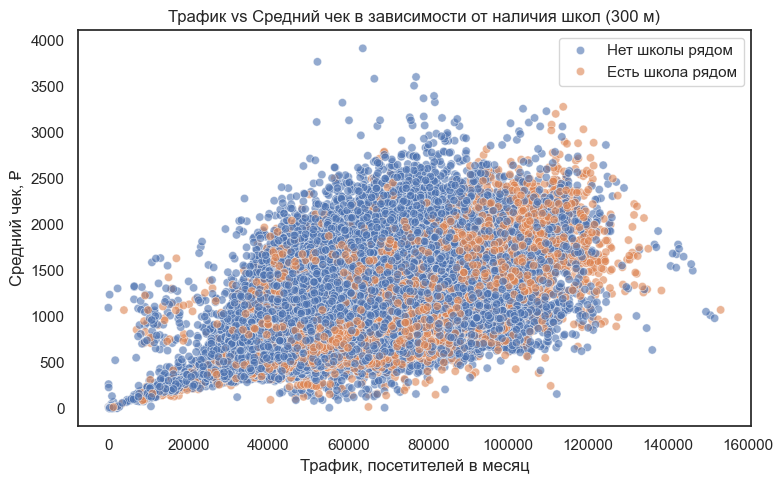

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

df['has_school'] = (df['Школы (300 м)'] > 0).map(
    {True: 'Есть школа рядом', False: 'Нет школы рядом'}
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='Трафик',
    y='Средний чек',
    hue='has_school',
    alpha=0.6
)
plt.title('Трафик vs Средний чек в зависимости от наличия школ (300 м)')
plt.xlabel('Трафик, посетителей в месяц')
plt.ylabel('Средний чек, ₽')
plt.legend(title='')
plt.tight_layout()
plt.show()

Ну вот 
1. Посмотреть корреляцию трафика и чека от флага наличия школы есть есть то будет супер
2. Подготовить графики распределения чека и трафика чтобы было красиво и сделать слайды (в крайнем случае они точно должны быть в подвале) 
3. Подготовить слайды с тем какие у нас есть переменные хотя бы кратко вот как нам показывали пример
4. Мб бахнуть типа сколько примерно в регионах пятерочек? Но это так скорее уже полёт мысли какой-то
5. Главная задача подвести к школам. По идее про это пункт 1. но он может провалиться если кореляция маленькая. Если жто окажется так то пиши сюда будем вместе чет ещё мозговать. 
6. Возможно стоит посмотреть сколько вообще данных о других социальных объектах. Условно если записей с больницами очень мало логично что их нет смысла рассматривать. То есть если данных со школами больше, чем данных с другими социальными объектами, то можно сделать столбчатую диаграмму вот как в примере с топливом т банка было и плавно после них перейти к школам.

В скрипте есть перемененная df - Pandas Dataframe(тебе дан скриншоти - первые 5 строчек датасета). 
Датасет описывает магазины Пятёрочки и их окружение. 
Придумай какой лучше график использовать в презентации для предварительного анализа и гипотезы "наличие школ рядом с торговой точкой повышает трафик, но снижает средний чек"

Смотри: я тебе дал 2 слайда из презентации, как-то связанной с пятёрочкой. для этой презентации мне нужно составить графики. твой задача максимально правильно описать визуальное оформление графиков(преимущественно), чтобы я мог передать их другому работнику.

Напиши код для графиков корреляцию трафика и чека от наличия школы(равен ли "Школы (300 м)" 0 или нет). Не нужно добавлять много лишнего
Напиши код для графиков распределения чека и трафика
Напиши код для графиков бахнуть типа сколько примерно в регионах пятерочек. Но это так скорее уже полёт мысли какой-то.

Не добавляй много лишнего.

В случает чего, используй цветовую палитру пятёрочки. Кратко об оттенках Пятёрочки:
Акцентные цвета: 11 градаций зелёного (от светлого 5 до тёмного 100). Базовый цвет для кнопок и акцентов — на уровне 80.
Серые (нейтральные) цвета: 11 градаций серого с зелёным подтоном (не чистый серый), созданные для гармонии с акцентной палитрой.

Общий стиль: Строгий, минималистичный, корпоративный (Flat design). Графики должны чисто смотреться на светлом фоне с геометрическим паттерном.
1. Цветовая палитра:
Используем цвета бренда, чтобы графики выглядели «родными» для презентации.
Основной цвет данных (столбцы, линии тренда): Темно-зеленый (как фон на титульном слайде).
Референс: Глубокий зеленый, примерно #007F3E или #157F44.
Акцентный цвет (для выделения важных точек или негативных трендов): Красный (фирменный красный Пятёрочки).
Референс: Ярко-красный, примерно #DD242C.
Второстепенные данные (для сравнения): Серый (средней насыщенности) или светло-зеленый.
Текст и оси: Черный или темно-серый (#333333). Не используйте чисто черный (#000000) для крупных плашек, чтобы не было слишком резко.
2. Фон и подложка:
Слайд контента (слайд №2) имеет светло-серый геометрический узор.
Важно: Графики лучше делать на прозрачном фоне, если они читаются хорошо.
Если данные теряются: Используйте полупрозрачную белую подложку (White, opacity 80-90%) или сплошную белую плашку под сам график, чтобы отделить его от фонового узора.
3. Типографика (Шрифты):
Шрифт: Гротеск (без засечек). В идеале использовать тот же шрифт, что в презентации (похож на X5 Sans, Gotham Pro или Cera Pro).
Заголовки графика: Жирное начертание (Bold), выравнивание по левому краю (как заголовок слайда).
Подписи осей и легенда: Обычное начертание (Regular), размер шрифта должен быть читаемым, но не спорить с заголовком.
4. Элементы графиков:
Столбчатые диаграммы (Bar Charts): Столбцы плоские, без теней, градиентов и 3D-эффектов. Углы столбцов прямые (не скруглять или скруглять минимально — 2-3px).
Линейные графики: Линии средней толщины (чтобы не терялись на узоре фона). Точки значений (маркеры) — круглые, залитые белым или основным цветом.
Круговые диаграммы: Используйте "пончики" (Donut charts) — они выглядят современнее.
Сетка и оси: Линии сетки делать очень тонкими и светло-серыми, либо убрать вовсе, оставив только значения (Data labels) над столбцами.
5. Компоновка:
Соблюдать отступы от черной разделительной линии сверху.
Не перекрывать номер слайда в правом нижнем углу (в кружке).

Смотри, я тебе дал 2 слайда из презентации, связанной с пятёрочкой. для этой презентации изменить графики, чтобы они подходили к презентации и всё было красиво. Твоя задача: максимально проанализируй фоновый узор и все 4 оттенка зелёного и серого на слайдах, соответствующим образом измени код графиков, чтобы я мог вставить в презентацию. Для показа графиков используй matplotlib.pyplot или seaborn. Не сохраняй ничего. Ответом должен быть один скрипт. Объяснения не требуются.
Шрифт текста замени на один из файлов-шрифтов:
Design\OTF\5kaSansDesign-Black.otf
Design\OTF\5kaSansDesign-CompressedRegular.otf
Design\OTF\5kaSansDesign-CondensedBold.otf
Design\OTF\5kaSansDesign-CondensedRegular.otf
Design\OTF\5kaSansDesign-Light.otf
Design\OTF\5kaSansDesign-Regular.otf
Design\OTF\5kaSansDesign-SemiBold.otf
Design\OTF\5kaSansDesign-Thimotf
Design\OTF\5kaSansDesign-Ultra.otf

```

```

Напиши код для графиков: для оправдания того что мы про школы исследование делаем. Корреляции от флага(лето или нет) вроде нет поэтому надо придумать что-то другое на подводку к школам. Посмотри относительно других соц. объектов. График с усами "Зависимость Трафика от наличия школы" и "Зависимость Среднего чека от наличия школы" не помогли. Гистограммы "Распределение Трафика" и "Распределение Среднего чека" не помогли. Трафик "Топ регионов по количеству магазинов", "Корреляция Трафика с объектами инфраструктуры" не помоги.

Примечания:
Пиши в виде одного скрипта!
Проверяй, достаточное ли количество данных, чтобы можно было делать правельные выводы по графику
Не добавляй много лишнего, не "парься" над дизайном.
Для показа графиков используй matplotlib.pyplot или seaborn.

Описание структуры данных:
Предоставлена выгрузка информации о магазинах торговой сети «Пятёрочка» за один календарный год в виде переменной Pandas Dataframe, называется df. Данные собраны на уровне отдельных торговых точек и включают как операционные показатели (трафик, средний чек), так и внешние факторы окружения: инфраструктуру, плотность населения, соседние объекты и конкурентную среду. В целях защиты коммерческой тайны отдельные числовые поля были модифицированы. При этом сохранены относительные соотношения между значениями, чтобы данные оставались пригодными для анализа.

1. new_id – Уникальный идентификатор магазина (анонимизированный). Единицы измерения / тип: int. Пример: 8.
2. Месяц – Месяц наблюдения. Единицы измерения / тип: int. Пример: 5.
3. Трафик – Среднее количество посетителей в месяц. Единицы измерения / тип: чел. Пример: 77325.
4. Средний чек – Средний чек покупателя. Единицы измерения / тип: руб. Пример: 637.942.
5. Дата открытия, категориальный – Группа по дате открытия магазина. Единицы измерения / тип: категориальный. Пример: открыт давно.
6. Торговая площадь, категориальный – Категория торговой площади. Единицы измерения / тип: категориальный. Пример: большой.
7. Населённый пункт – Название населённого пункта, где расположен магазин. Единицы измерения / тип: текст. Пример: Дубна г.
8. Регион – Регион. Единицы измерения / тип: текст. Пример: Московская обл.
9. Численность населения – Численность населения. Единицы измерения / тип: чел. Пример: 1544376.
10. Количество домохозяйств – Число домохозяйств в радиусе 500 м. Единицы измерения / тип: шт. Пример: 4152.
11. Трафик пеший, в час – Средний пешеходный поток. Единицы измерения / тип: чел./час. Пример: 76.9.
12. Трафик авто, в час – Средний автомобильный поток. Единицы измерения / тип: авто/час. Пример: 310.
13. Маркетплейсы, доставки, постаматы (100 м) – Количество объектов e-commerce в радиусе 100 м. Единицы измерения / тип: шт. Пример: 3.
14. Медицинские уч. и аптеки (300 м) – Количество медучреждений и аптек поблизости. Единицы измерения / тип: шт. Пример: 5.
15. Школы (300 м) – Количество школ в радиусе 300 м. Единицы измерения / тип: шт. Пример: 1.
16. Остановки (300 м) – Количество остановок общественного транспорта поблизости. Единицы измерения / тип: шт. Пример: 2.
17. Продуктовые магазины (500 м) – Количество других продуктовых магазинов в радиусе 500 м. Единицы измерения / тип: шт. Пример: 4.
18. Пятёрочки (500 м) – Количество магазинов сети «Пятёрочка» в радиусе 500 м. Единицы измерения / тип: шт. Пример: 1.

Есть презентация, связанная с пятёрочкой. Под эту презентацию необходими изменаять графики, чтобы они подходили к презентации и всё было красиво. Твоя задача: проанализируй данные отенки зелёного и серого со слайдов, чтобы создать баланс, и соответствующим образом измени код графиков только на серый и зелёный, чтобы я мог вставить в презентацию. Учти, что вон будет бело-серым. Для показа графиков используй matplotlib.pyplot или seaborn. Не сохраняй ничего. Ответом должен быть один скрипт. Объяснения не требуются.
Оттенки на презентации:
005c29
f6f6f6
ffffff
006d2c
00923a
d8d8d8
7dc041
d7e9d2

Шрифт текста замени на один из файлов-шрифтов:
Design\OTF\5kaSansDesign-Black.otf
Design\OTF\5kaSansDesign-CompressedRegular.otf
Design\OTF\5kaSansDesign-CondensedBold.otf
Design\OTF\5kaSansDesign-CondensedRegular.otf
Design\OTF\5kaSansDesign-Light.otf
Design\OTF\5kaSansDesign-Regular.otf
Design\OTF\5kaSansDesign-SemiBold.otf
Design\OTF\5kaSansDesign-Thimotf
Design\OTF\5kaSansDesign-Ultra.otf

```

```

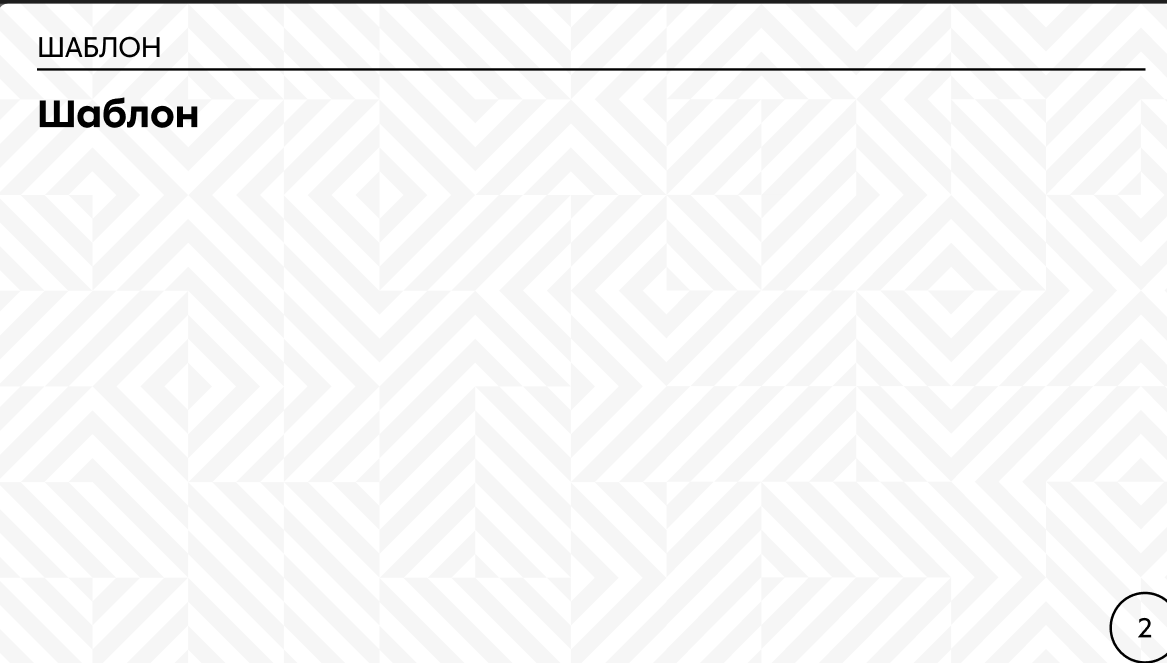
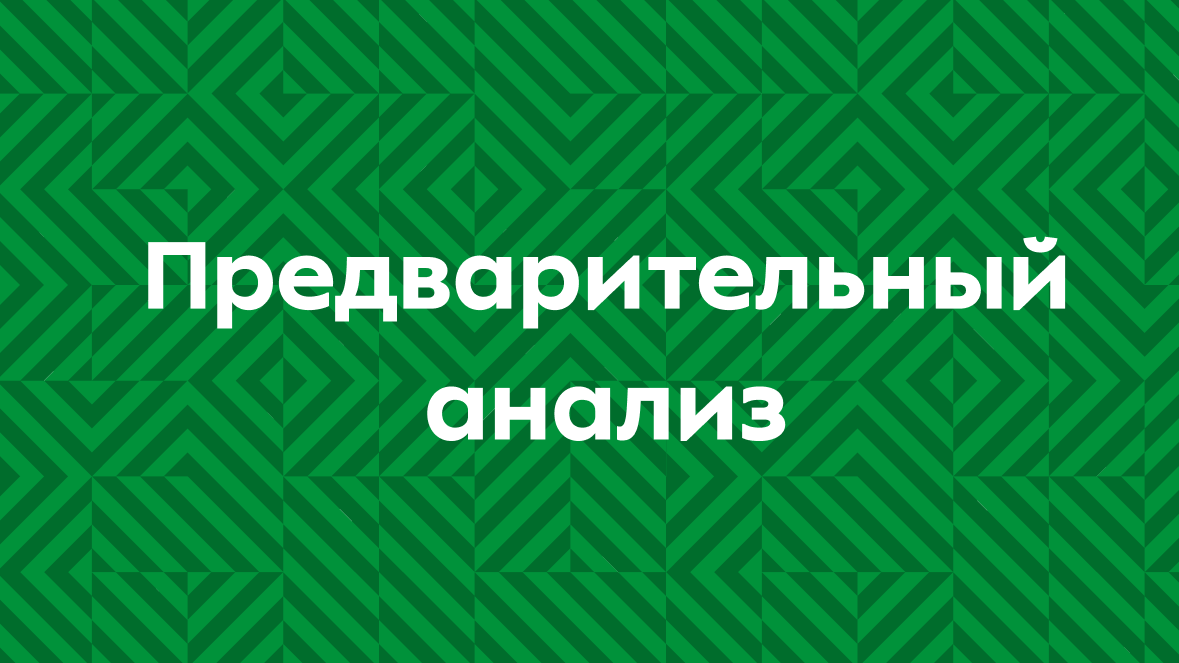

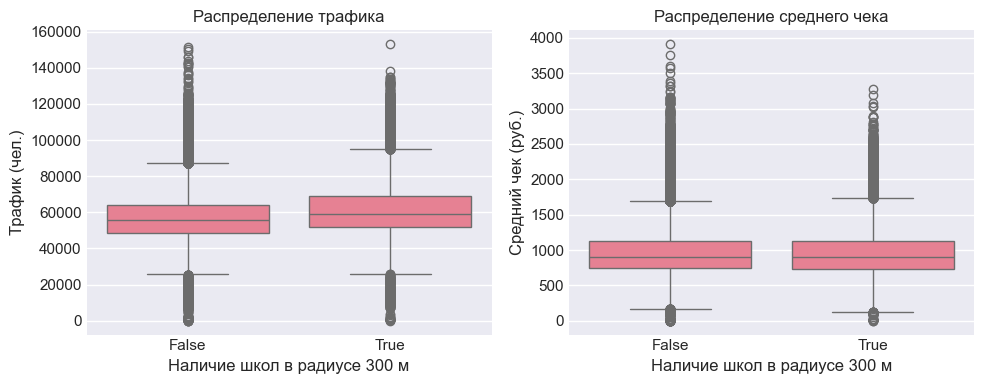

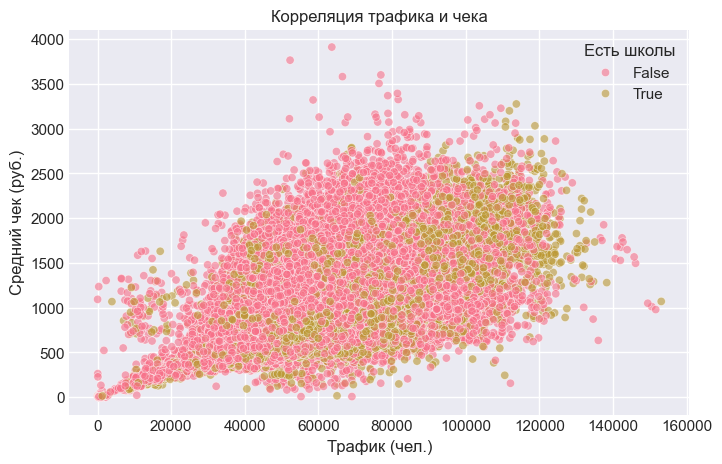

Сводная статистика:
              Трафик  Средний чек
Есть школы                       
False       57557.42       965.07
True        61725.55       969.20


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Создаем бинарный признак наличия школ
df['Есть школы'] = df['Школы (300 м)'] > 0

# График 1: Распределение трафика
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Есть школы', y='Трафик')
plt.title('Распределение трафика')
plt.xlabel('Наличие школ в радиусе 300 м')
plt.ylabel('Трафик (чел.)')

# График 2: Распределение среднего чека
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Есть школы', y='Средний чек')
plt.title('Распределение среднего чека')
plt.xlabel('Наличие школ в радиусе 300 м')
plt.ylabel('Средний чек (руб.)')

plt.tight_layout()
plt.show()

# Дополнительно: точечный график корреляции
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Трафик', y='Средний чек', hue='Есть школы', alpha=0.6)
plt.title('Корреляция трафика и чека')
plt.xlabel('Трафик (чел.)')
plt.ylabel('Средний чек (руб.)')
plt.legend(title='Есть школы')
plt.show()

# Вывод числовых показателей
print("Сводная статистика:")
print(df.groupby('Есть школы')[['Трафик', 'Средний чек']].mean().round(2))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


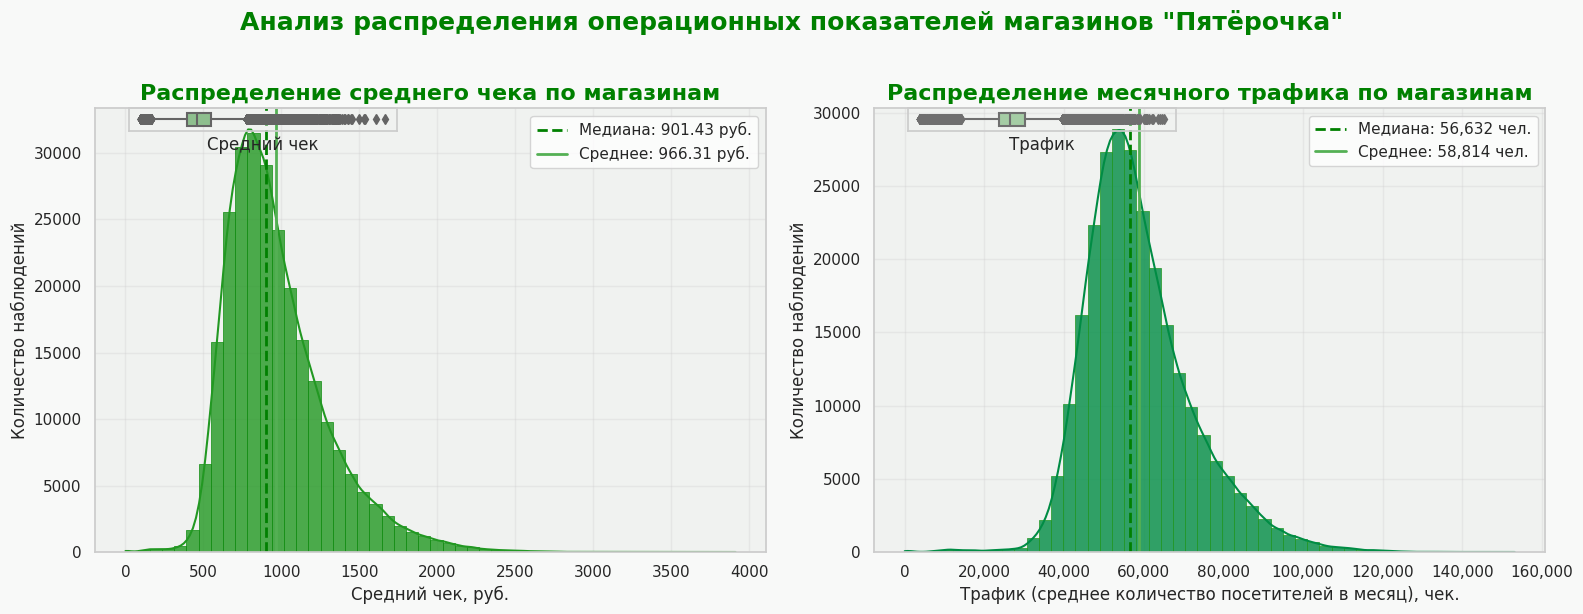

ОСНОВНЫЕ СТАТИСТИКИ:

Средний чек (руб.):
  Среднее: 966.31
  Медиана: 901.43
  Стандартное отклонение: 323.69
  Минимум: 0.00
  Максимум: 3911.50
  25-й перцентиль: 739.82
  75-й перцентиль: 1126.59

Трафик (посетителей в месяц):
  Среднее: 58,814
  Медиана: 56,632
  Стандартное отклонение: 13,546
  Минимум: 1
  Максимум: 153,105
  25-й перцентиль: 49,697
  75-й перцентиль: 65,801


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка цветовой палитры "Пятёрочки"
# Акцентные цвета (зелёные) - возьмём 80 для основного и градиент для распределения
pyaterochka_green = {
    5: '#e6f5e6',    # Очень светлый фон, подложки
    10: '#d1ebd1',   # Светлый фон для карточек
    20: '#b8dfb8',   # Фон для выделенных областей
    30: '#9fd39f',   # Светлые элементы графиков (boxplot трафика)
    40: '#86c786',   # Вторичные элементы (boxplot среднего чека)
    50: '#6dbc6d',   # Дополнительный акцент, заливка легенды
    60: '#54b054',   # Линия среднего значения
    70: '#008C44',#""'#3ba43b',   # Основной цвет гистограммы трафика
    80: '#229822',   # ОСНОВНОЙ АКЦЕНТНЫЙ - гистограмма среднего чека
    90: '#0f8c0f',   # Контуры столбцов гистограмм
    100: '#008000'   # Заголовки, линия медианы (самый тёмный)
}

# Нейтральные цвета (серые с зелёным подтоном)
pyaterochka_gray = {
    5: '#f8f9f8',    # Фон всей фигуры (figure background)
    10: '#f0f2f0',   # Фон области графика (axes background)
    20: '#e8ebe8',   # Светлые разделители
    30: '#e0e4e0',   # Границы элементов
    40: '#d8ddd8',   # Неактивные элементы
    50: '#d0d6d0',   # Сетка графика
    60: '#c8cfc8',   # Вторичный текст
    70: '#c0c8c0',   # Подписи осей
    80: '#b8c1b8',   # Рамки
    90: '#b0bab0',   # Тени
    100: '#a8b3a8'   # Самый тёмный серый
}

# Установим стиль seaborn с использованием нашей палитры
sns.set_style("whitegrid")
sns.set_palette([pyaterochka_green[80], pyaterochka_green[50]])

# Создадим фигуру с двумя subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor=pyaterochka_gray[5])

# График 1: Распределение среднего чека
ax1 = axes[0]
# Используем гистограмму с KDE
sns.histplot(data=df, x='Средний чек', 
             bins=50, 
             kde=True,
             color=pyaterochka_green[80],
             edgecolor=pyaterochka_green[90],
             linewidth=0.5,
             alpha=0.8,
             ax=ax1)

# Добавим вертикальную линию для медианы и среднего
median_check = df['Средний чек'].median()
mean_check = df['Средний чек'].mean()

ax1.axvline(median_check, color=pyaterochka_green[100], 
            linestyle='--', linewidth=2, label=f'Медиана: {median_check:.2f} руб.')
ax1.axvline(mean_check, color=pyaterochka_green[60], 
            linestyle='-', linewidth=2, label=f'Среднее: {mean_check:.2f} руб.')

# Настройки графика
ax1.set_title('Распределение среднего чека по магазинам', 
              fontsize=16, fontweight='bold', color=pyaterochka_green[100])
ax1.set_xlabel('Средний чек, руб.', fontsize=12)
ax1.set_ylabel('Количество наблюдений', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(pyaterochka_gray[10])

# Добавим boxplot в верхней части
boxprops = dict(facecolor=pyaterochka_green[40], color=pyaterochka_green[90])
ax1_box = ax1.inset_axes([0.05, 0.95, 0.4, 0.05])
sns.boxplot(x=df['Средний чек'], ax=ax1_box, color=pyaterochka_green[40], 
            width=0.6, linewidth=1.5)
ax1_box.set_xlim(ax1.get_xlim())
ax1_box.set_xticks([])
ax1_box.set_yticks([])
ax1_box.set_facecolor('none')

# График 2: Распределение трафика
ax2 = axes[1]
# Трафик может иметь большой разброс, используем логарифмическую шкалу
sns.histplot(data=df, x='Трафик', 
             bins=50, 
             kde=True,
             color=pyaterochka_green[70],
             edgecolor=pyaterochka_green[80],
             linewidth=0.5,
             alpha=0.8,
             ax=ax2)

# Добавим вертикальную линию для медианы и среднего
median_traffic = df['Трафик'].median()
mean_traffic = df['Трафик'].mean()

ax2.axvline(median_traffic, color=pyaterochka_green[100], 
            linestyle='--', linewidth=2, label=f'Медиана: {median_traffic:,.0f} чел.')
ax2.axvline(mean_traffic, color=pyaterochka_green[60], 
            linestyle='-', linewidth=2, label=f'Среднее: {mean_traffic:,.0f} чел.')

# Настройки графика
ax2.set_title('Распределение месячного трафика по магазинам', 
              fontsize=16, fontweight='bold', color=pyaterochka_green[100])
ax2.set_xlabel('Трафик (среднее количество посетителей в месяц), чек.', fontsize=12)
ax2.set_ylabel('Количество наблюдений', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(pyaterochka_gray[10])

# Форматирование больших чисел на оси X
ax2.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

# Добавим boxplot в верхней части
ax2_box = ax2.inset_axes([0.05, 0.95, 0.4, 0.05])
sns.boxplot(x=df['Трафик'], ax=ax2_box, color=pyaterochka_green[30], 
            width=0.6, linewidth=1.5)
ax2_box.set_xlim(ax2.get_xlim())
ax2_box.set_xticks([])
ax2_box.set_yticks([])
ax2_box.set_facecolor('none')

# Общие настройки
fig.suptitle('Анализ распределения операционных показателей магазинов "Пятёрочка"', 
             fontsize=18, fontweight='bold', color=pyaterochka_green[100], y=1.02)

plt.tight_layout()
plt.show()

# Дополнительно: выведем основные статистики
print("=" * 80)
print("ОСНОВНЫЕ СТАТИСТИКИ:")
print("=" * 80)
print("\nСредний чек (руб.):")
print(f"  Среднее: {mean_check:.2f}")
print(f"  Медиана: {median_check:.2f}")
print(f"  Стандартное отклонение: {df['Средний чек'].std():.2f}")
print(f"  Минимум: {df['Средний чек'].min():.2f}")
print(f"  Максимум: {df['Средний чек'].max():.2f}")
print(f"  25-й перцентиль: {df['Средний чек'].quantile(0.25):.2f}")
print(f"  75-й перцентиль: {df['Средний чек'].quantile(0.75):.2f}")

print("\nТрафик (посетителей в месяц):")
print(f"  Среднее: {mean_traffic:,.0f}")
print(f"  Медиана: {median_traffic:,.0f}")
print(f"  Стандартное отклонение: {df['Трафик'].std():,.0f}")
print(f"  Минимум: {df['Трафик'].min():,.0f}")
print(f"  Максимум: {df['Трафик'].max():,.0f}")
print(f"  25-й перцентиль: {df['Трафик'].quantile(0.25):,.0f}")
print(f"  75-й перцентиль: {df['Трафик'].quantile(0.75):,.0f}")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


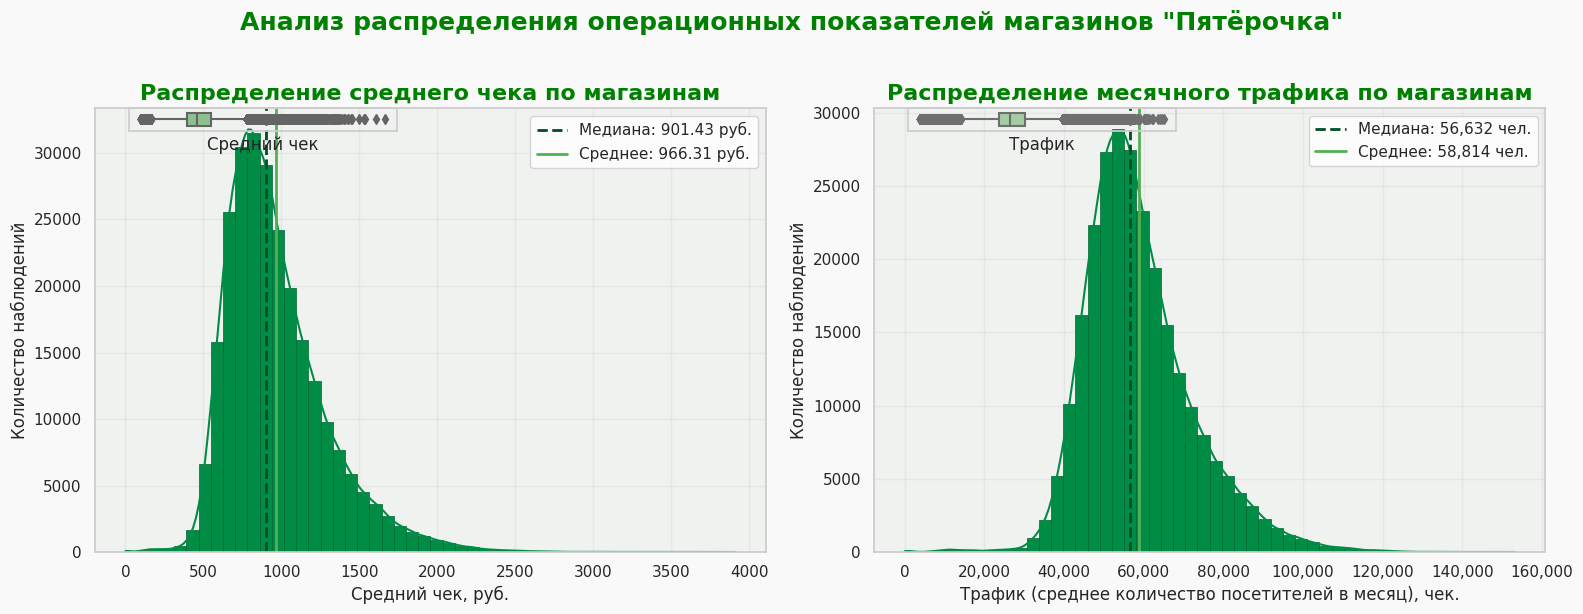

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка цветовой палитры "Пятёрочки"
pyaterochka_green = {
    5: '#e6f5e6',
    10: '#d1ebd1',
    20: '#b8dfb8',
    30: '#9fd39f',
    40: '#86c786',
    50: '#6dbc6d',
    60: '#54b054',
    70: '#008C44',  # Основной цвет для гистограмм
    80: '#229822',
    90: '#006633',  # Тёмный контур для столбцов
    100: '#008000'
}

pyaterochka_gray = {
    5: '#f8f9f8',
    10: '#f0f2f0',
    20: '#e8ebe8',
    30: '#e0e4e0',
    40: '#d8ddd8',
    50: '#d0d6d0',
    60: '#c8cfc8',
    70: '#c0c8c0',
    80: '#b8c1b8',
    90: '#b0bab0',
    100: '#a8b3a8'
}

sns.set_style("whitegrid")
sns.set_palette([pyaterochka_green[70], pyaterochka_green[50]])

fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor=pyaterochka_gray[5])

# График 1: Распределение среднего чека
ax1 = axes[0]
sns.histplot(data=df, x='Средний чек', 
             bins=50, 
             kde=True,
             color='#008C44',           # <-- Цвет #008C44
             edgecolor='#006633',       # <-- Тёмный контур
             linewidth=0.5,
             alpha=1.0,                 # <-- Без прозрачности (было 0.8)
             ax=ax1)

median_check = df['Средний чек'].median()
mean_check = df['Средний чек'].mean()

ax1.axvline(median_check, color='#004D25', 
            linestyle='--', linewidth=2, label=f'Медиана: {median_check:.2f} руб.')
ax1.axvline(mean_check, color=pyaterochka_green[60], 
            linestyle='-', linewidth=2, label=f'Среднее: {mean_check:.2f} руб.')

ax1.set_title('Распределение среднего чека по магазинам', 
              fontsize=16, fontweight='bold', color=pyaterochka_green[100])
ax1.set_xlabel('Средний чек, руб.', fontsize=12)
ax1.set_ylabel('Количество наблюдений', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor(pyaterochka_gray[10])

ax1_box = ax1.inset_axes([0.05, 0.95, 0.4, 0.05])
sns.boxplot(x=df['Средний чек'], ax=ax1_box, color=pyaterochka_green[40], 
            width=0.6, linewidth=1.5)
ax1_box.set_xlim(ax1.get_xlim())
ax1_box.set_xticks([])
ax1_box.set_yticks([])
ax1_box.set_facecolor('none')

# График 2: Распределение трафика
ax2 = axes[1]
sns.histplot(data=df, x='Трафик', 
             bins=50, 
             kde=True,
             color='#008C44',           # <-- Цвет #008C44
             edgecolor='#006633',       # <-- Тёмный контур
             linewidth=0.5,
             alpha=1.0,                 # <-- Без прозрачности (было 0.8)
             ax=ax2)

median_traffic = df['Трафик'].median()
mean_traffic = df['Трафик'].mean()

ax2.axvline(median_traffic, color='#004D25', 
            linestyle='--', linewidth=2, label=f'Медиана: {median_traffic:,.0f} чел.')
ax2.axvline(mean_traffic, color=pyaterochka_green[60], 
            linestyle='-', linewidth=2, label=f'Среднее: {mean_traffic:,.0f} чел.')

ax2.set_title('Распределение месячного трафика по магазинам', 
              fontsize=16, fontweight='bold', color=pyaterochka_green[100])
ax2.set_xlabel('Трафик (среднее количество посетителей в месяц), чек.', fontsize=12)
ax2.set_ylabel('Количество наблюдений', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor(pyaterochka_gray[10])

ax2.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax2_box = ax2.inset_axes([0.05, 0.95, 0.4, 0.05])
sns.boxplot(x=df['Трафик'], ax=ax2_box, color=pyaterochka_green[30], 
            width=0.6, linewidth=1.5)
ax2_box.set_xlim(ax2.get_xlim())
ax2_box.set_xticks([])
ax2_box.set_yticks([])
ax2_box.set_facecolor('none')

fig.suptitle('Анализ распределения операционных показателей магазинов "Пятёрочка"', 
             fontsize=18, fontweight='bold', color=pyaterochka_green[100], y=1.02)

plt.tight_layout()
plt.show()

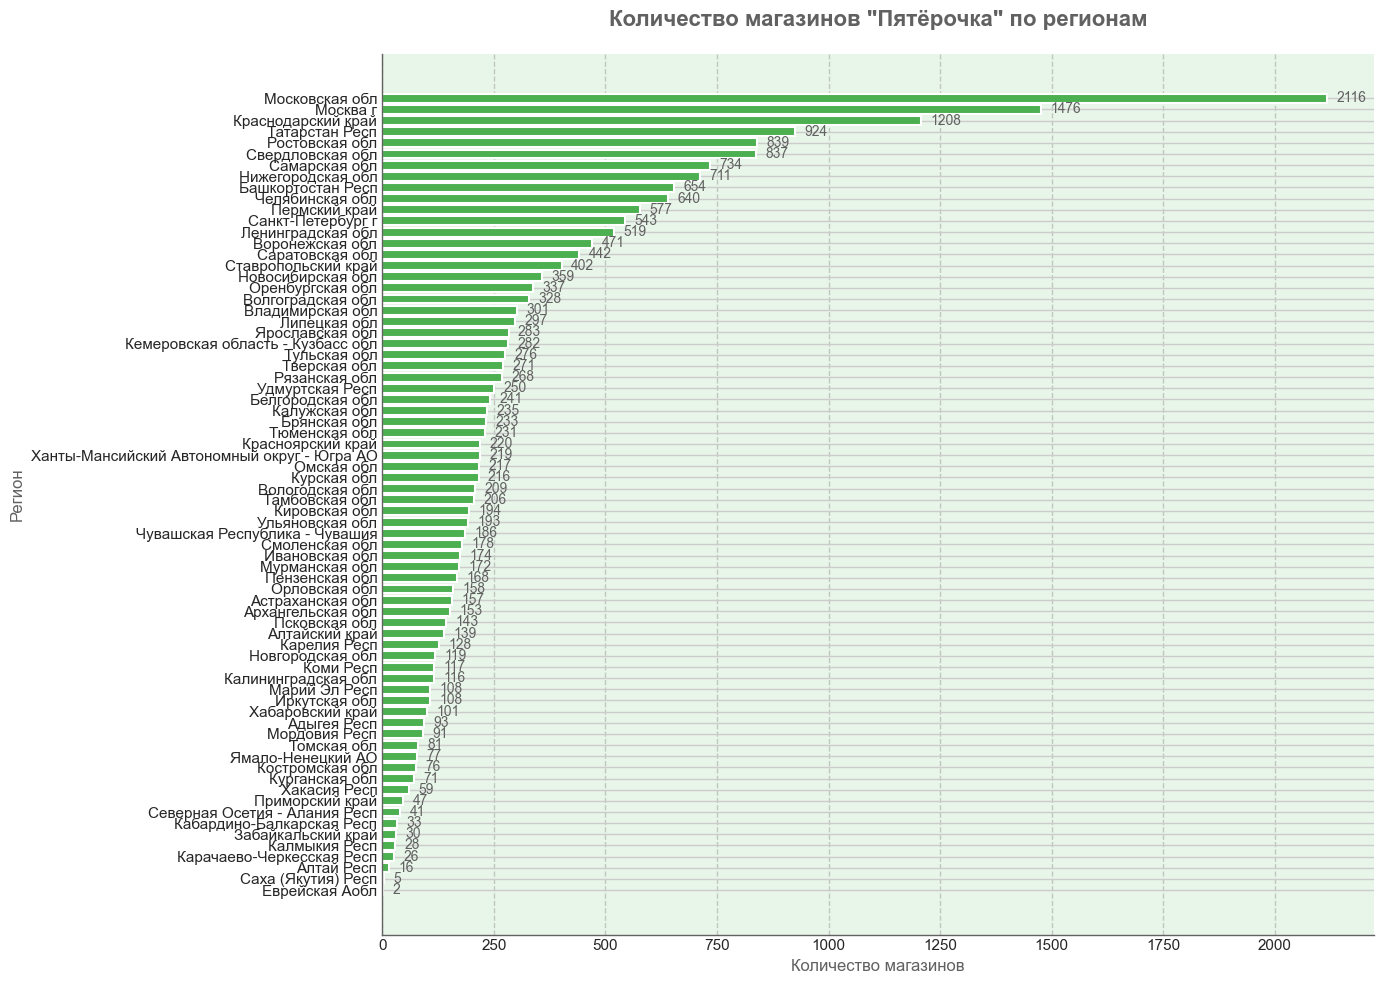

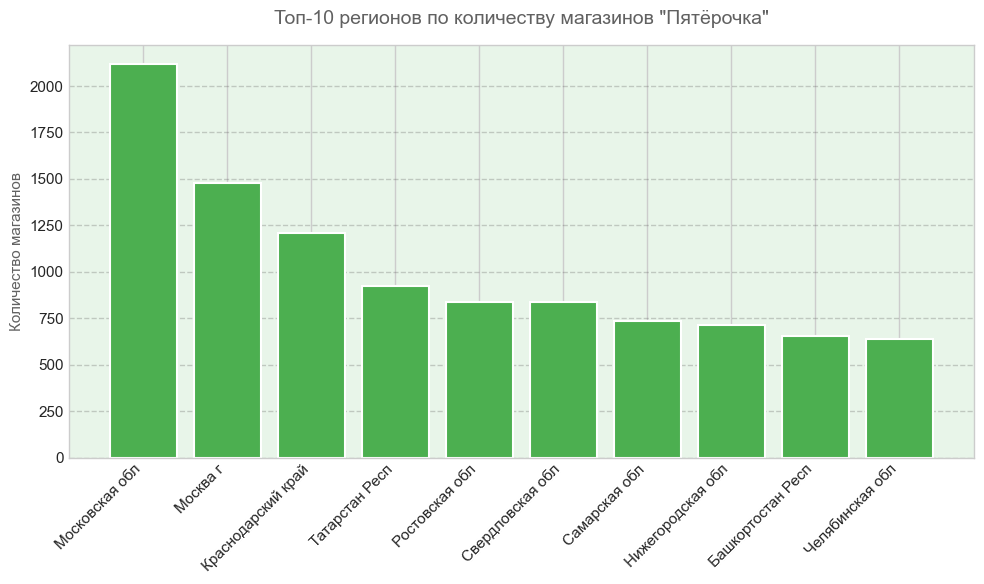

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Цветовая палитра Пятёрочки
green_80 = '#4CAF50'  # Базовый акцентный цвет (зелёный 80)
green_light = '#E8F5E9'  # Светлый зелёный для фона
gray_custom = '#616161'  # Серый с зелёным подтоном

# Подготовка данных: количество магазинов по регионам
region_counts = df.groupby('Регион')['new_id'].nunique().sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(14, 10))

# Вертикальные линии сетки
plt.grid(axis='x', alpha=0.3, linestyle='--', color=gray_custom)

# Столбчатая диаграмма
bars = plt.barh(region_counts.index, region_counts.values, 
                color=green_80, edgecolor='white', linewidth=1.5)

# Настройки внешнего вида
plt.gca().invert_yaxis()  # Инвертируем ось Y для сортировки сверху вниз
plt.title('Количество магазинов "Пятёрочка" по регионам', 
          fontsize=16, pad=20, color=gray_custom, fontweight='bold')
plt.xlabel('Количество магазинов', fontsize=12, color=gray_custom)
plt.ylabel('Регион', fontsize=12, color=gray_custom)

# Добавление значений на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + (region_counts.max() * 0.01), bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontsize=10, color=gray_custom)

# Цвет фона
plt.gca().set_facecolor(green_light)
plt.gcf().patch.set_facecolor('white')

# Настройка осей
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color(gray_custom)
plt.gca().spines['bottom'].set_color(gray_custom)

# Автоподбор размера шрифта регионов
plt.tight_layout()

plt.show()

# Дополнительно: Топ-10 регионов (компактный вариант)
top_regions = region_counts.head(10)

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_regions)), top_regions.values, 
        color=green_80, edgecolor='white', linewidth=1.5)
plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
plt.title('Топ-10 регионов по количеству магазинов "Пятёрочка"', 
          fontsize=14, pad=15, color=gray_custom)
plt.ylabel('Количество магазинов', fontsize=11, color=gray_custom)
plt.grid(axis='y', alpha=0.3, linestyle='--', color=gray_custom)
plt.gca().set_facecolor(green_light)
plt.tight_layout()

plt.show()

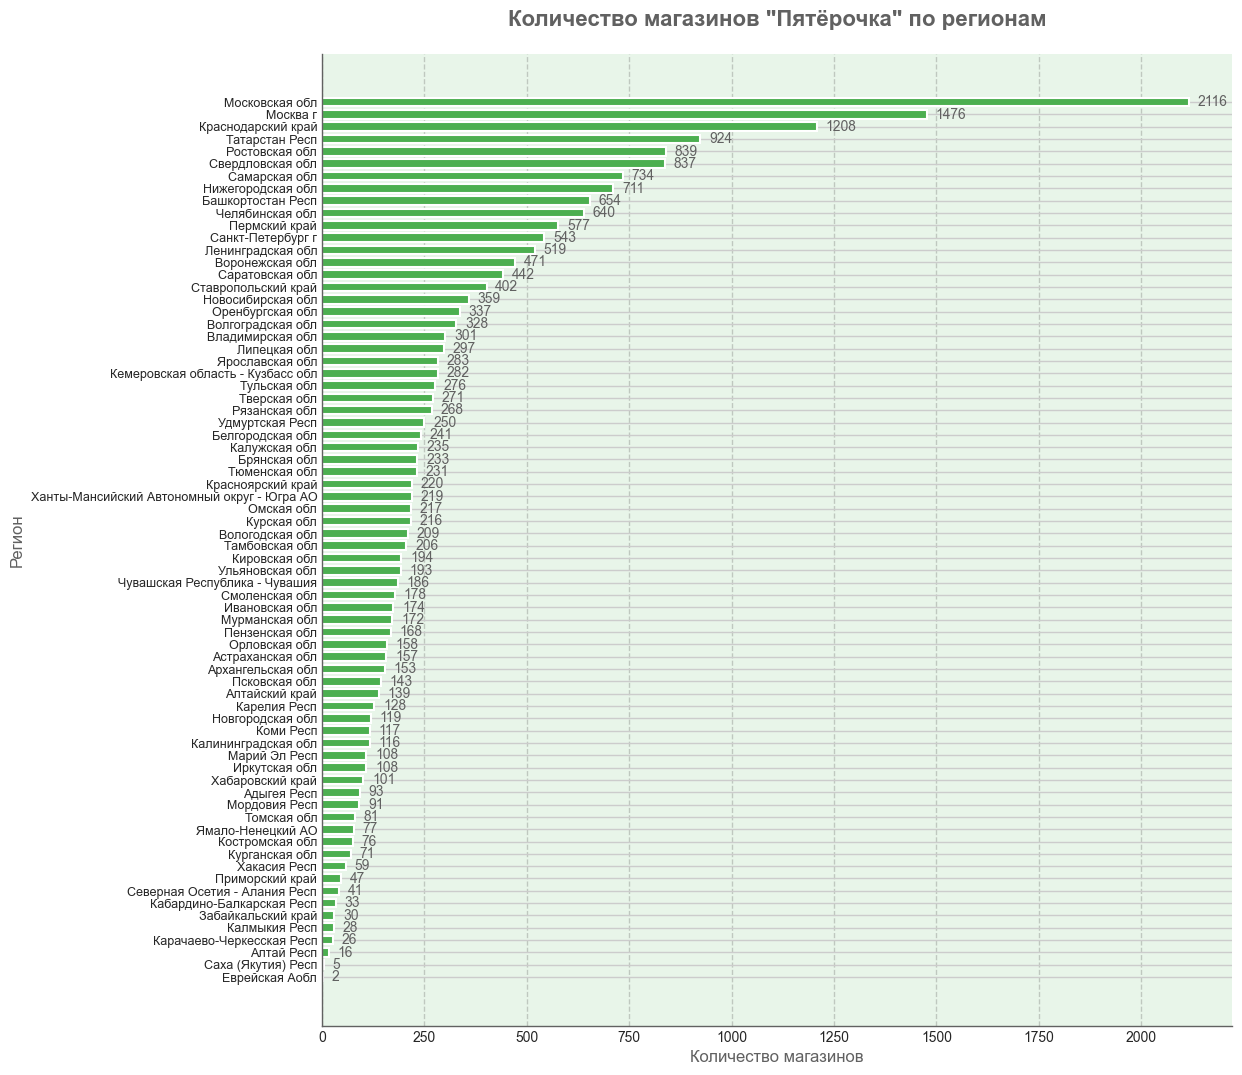

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Цветовая палитра Пятёрочки
green_80 = '#4CAF50'  # Базовый акцентный цвет (зелёный 80)
green_light = '#E8F5E9'  # Светлый зелёный для фона
gray_custom = '#616161'  # Серый с зелёным подтоном

# Подготовка данных: количество магазинов по регионам
region_counts = df.groupby('Регион')['new_id'].nunique().sort_values(ascending=False)

# Рассчитываем высоту графика в зависимости от количества регионов
n_regions = len(region_counts)
fig_height = max(8, n_regions * 0.15)  # Минимум 8 дюймов, иначе 0.4 дюйма на регион

# Создание графика с динамической высотой
plt.figure(figsize=(14, fig_height))

# Вертикальные линии сетки
plt.grid(axis='x', alpha=0.3, linestyle='--', color=gray_custom)

# Столбчатая диаграмма с настройкой высоты столбцов
bar_height = 0.7  # Высота каждого столбца (можно уменьшить для большего расстояния)
bars = plt.barh(region_counts.index, region_counts.values, 
                height=bar_height,  # Указываем высоту столбцов
                color=green_80, edgecolor='white', linewidth=1.5)

# Настройки внешнего вида
plt.gca().invert_yaxis()  # Инвертируем ось Y для сортировки сверху вниз

# Автоматическая настройка размера шрифта в зависимости от количества регионов
if n_regions > 30:
    y_fontsize = 9
elif n_regions > 50:
    y_fontsize = 8
else:
    y_fontsize = 11

plt.yticks(fontsize=y_fontsize)  # Размер шрифта для названий регионов
plt.xticks(fontsize=10)

plt.title('Количество магазинов "Пятёрочка" по регионам', 
          fontsize=16, pad=20, color=gray_custom, fontweight='bold')
plt.xlabel('Количество магазинов', fontsize=12, color=gray_custom)
plt.ylabel('Регион', fontsize=12, color=gray_custom)

# Добавление значений на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + (region_counts.max() * 0.01), bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontsize=10, color=gray_custom)

# Цвет фона
plt.gca().set_facecolor(green_light)
plt.gcf().patch.set_facecolor('white')

# Настройка осей
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color(gray_custom)
plt.gca().spines['bottom'].set_color(gray_custom)

# Добавляем отступы по краям
plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.05)

plt.show()

СТАТИСТИКА ПО НАЛИЧИЮ СОЦИАЛЬНЫХ ОБЪЕКТОВ:
Всего магазинов в анализе: 256711
Магазинов с хотя бы одной школой в радиусе 300 м: 77372 (30.1%)
Магазинов с хотя бы одним мед. учреждением/аптекой: 157732 (61.4%)
Магазинов с хотя бы одной остановкой: 113680 (44.3%)
Магазинов с хотя бы одним продуктовым конкурентом: 224225 (87.3%)

ВЫВОД ДЛЯ ОБОСНОВАНИЯ ИССЛЕДОВАНИЯ:
1. Школы присутствуют в радиусе 300 м у 30.1% магазинов - ЭТО НАИБОЛЬШИЙ ПОКАЗАТЕЛЬ
2. Это на -31.3% больше, чем для медицинских учреждений
3. Школы являются самым распространенным социальным объектом вблизи магазинов сети


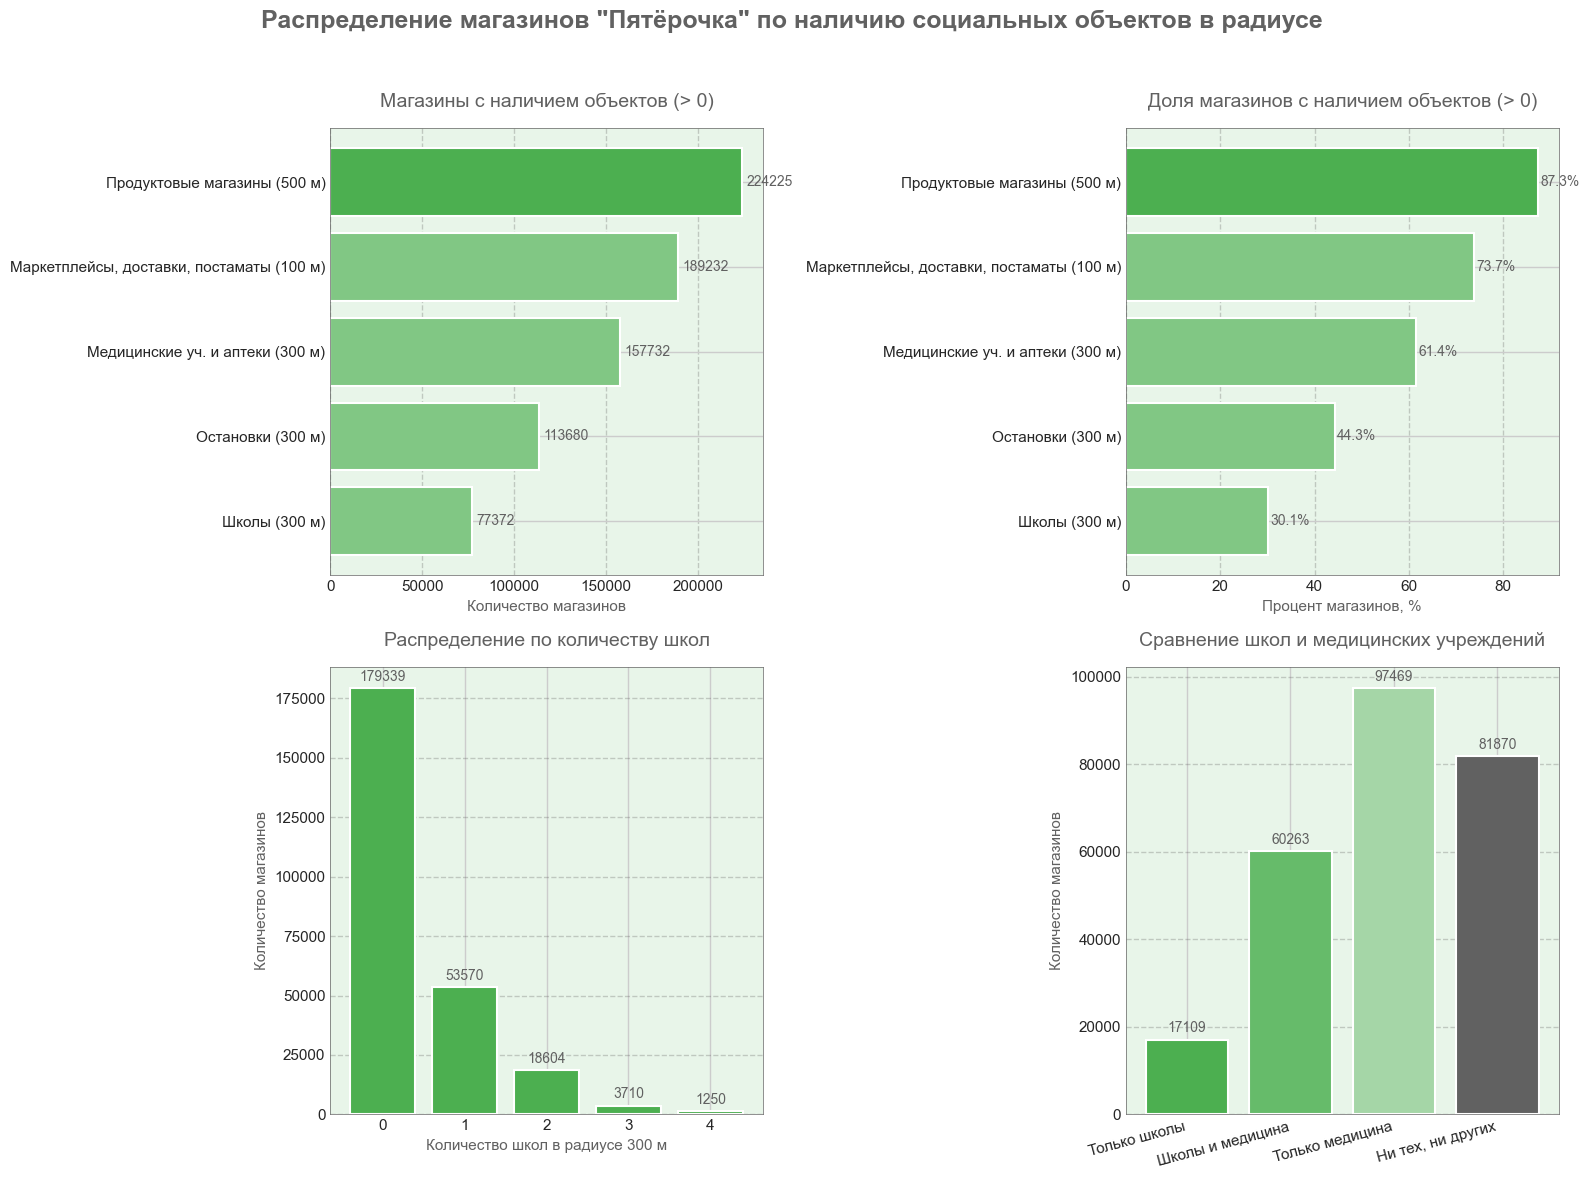

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Цветовая палитра Пятёрочки
green_80 = '#4CAF50'  # Базовый акцентный цвет (зелёный 80)
green_60 = '#81C784'  # Светлее для контраста
green_light = '#E8F5E9'  # Светлый зелёный для фона
gray_custom = '#616161'  # Серый с зелёным подтоном

# Создаем фигуру с несколькими графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Распределение магазинов "Пятёрочка" по наличию социальных объектов в радиусе', 
             fontsize=18, fontweight='bold', color=gray_custom, y=0.98)

# 1. Количество магазинов с наличием объектов (> 0)
objects_data = {
    'Школы (300 м)': (df['Школы (300 м)'] > 0).sum(),
    'Медицинские уч. и аптеки (300 м)': (df['Медицинские уч. и аптеки (300 м)'] > 0).sum(),
    'Остановки (300 м)': (df['Остановки (300 м)'] > 0).sum(),
    'Продуктовые магазины (500 м)': (df['Продуктовые магазины (500 м)'] > 0).sum(),
    'Маркетплейсы, доставки, постаматы (100 м)': (df['Маркетплейсы, доставки, постаматы (100 м)'] > 0).sum(),
}

# Сортируем по убыванию
sorted_objects = dict(sorted(objects_data.items(), key=lambda x: x[1], reverse=True))

# Первый график: абсолютные значения
ax1 = axes[0, 0]
bars1 = ax1.barh(list(sorted_objects.keys()), list(sorted_objects.values()), 
                color=[green_80, green_60, green_60, green_60, green_60],
                edgecolor='white', linewidth=1.5)
ax1.set_xlabel('Количество магазинов', fontsize=11, color=gray_custom)
ax1.set_title('Магазины с наличием объектов (> 0)', fontsize=14, pad=15, color=gray_custom)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--', color=gray_custom)

# Добавляем значения на столбцы
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + (max(sorted_objects.values()) * 0.01), bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontsize=10, color=gray_custom)

# 2. Процент магазинов с наличием объектов (> 0)
total_stores = len(df)
objects_percent = {k: (v / total_stores * 100) for k, v in objects_data.items()}
sorted_percent = dict(sorted(objects_percent.items(), key=lambda x: x[1], reverse=True))

ax2 = axes[0, 1]
bars2 = ax2.barh(list(sorted_percent.keys()), list(sorted_percent.values()), 
                color=[green_80, green_60, green_60, green_60, green_60],
                edgecolor='white', linewidth=1.5)
ax2.set_xlabel('Процент магазинов, %', fontsize=11, color=gray_custom)
ax2.set_title('Доля магазинов с наличием объектов (> 0)', fontsize=14, pad=15, color=gray_custom)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--', color=gray_custom)

# Добавляем значения на столбцы
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', ha='left', va='center', fontsize=10, color=gray_custom)

# 3. Распределение количества объектов в радиусе (для школ)
ax3 = axes[1, 0]
school_counts = df['Школы (300 м)'].value_counts().sort_index()
max_schools = min(5, len(school_counts))  # Показываем до 5 значений

bars3 = ax3.bar(range(max_schools), school_counts.values[:max_schools], 
                color=green_80, edgecolor='white', linewidth=1.5)
ax3.set_xlabel('Количество школ в радиусе 300 м', fontsize=11, color=gray_custom)
ax3.set_ylabel('Количество магазинов', fontsize=11, color=gray_custom)
ax3.set_title('Распределение по количеству школ', fontsize=14, pad=15, color=gray_custom)
ax3.set_xticks(range(max_schools))
ax3.set_xticklabels([str(i) for i in school_counts.index[:max_schools]])
ax3.grid(axis='y', alpha=0.3, linestyle='--', color=gray_custom)

# Добавляем значения на столбцы
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + (max(school_counts.values) * 0.01),
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color=gray_custom)

# 4. Сравнение школ с другими объектами (комбинация)
ax4 = axes[1, 1]

# Считаем магазины, которые имеют И школы, И медицинские учреждения
schools_medical = ((df['Школы (300 м)'] > 0) & (df['Медицинские уч. и аптеки (300 м)'] > 0)).sum()
schools_only = ((df['Школы (300 м)'] > 0) & (df['Медицинские уч. и аптеки (300 м)'] == 0)).sum()
medical_only = ((df['Школы (300 м)'] == 0) & (df['Медицинские уч. и аптеки (300 м)'] > 0)).sum()
none = ((df['Школы (300 м)'] == 0) & (df['Медицинские уч. и аптеки (300 м)'] == 0)).sum()

categories = ['Только школы', 'Школы и медицина', 'Только медицина', 'Ни тех, ни других']
values = [schools_only, schools_medical, medical_only, none]
colors = [green_80, '#66BB6A', '#A5D6A7', gray_custom]

bars4 = ax4.bar(categories, values, color=colors, edgecolor='white', linewidth=1.5)
ax4.set_ylabel('Количество магазинов', fontsize=11, color=gray_custom)
ax4.set_title('Сравнение школ и медицинских учреждений', fontsize=14, pad=15, color=gray_custom)
ax4.grid(axis='y', alpha=0.3, linestyle='--', color=gray_custom)

# Добавляем значения на столбцы
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height + (max(values) * 0.01),
             f'{int(height)}', ha='center', va='bottom', fontsize=10, color=gray_custom)

# Поворачиваем подписи на последнем графике для лучшей читаемости
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Общие настройки для всех графиков
for ax in axes.flatten():
    ax.set_facecolor(green_light)
    for spine in ax.spines.values():
        spine.set_color(gray_custom)
        spine.set_linewidth(0.5)

fig.patch.set_facecolor('white')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Выводим статистику в текстовом виде
print("СТАТИСТИКА ПО НАЛИЧИЮ СОЦИАЛЬНЫХ ОБЪЕКТОВ:")
print("=" * 50)
print(f"Всего магазинов в анализе: {total_stores}")
print(f"Магазинов с хотя бы одной школой в радиусе 300 м: {objects_data['Школы (300 м)']} ({objects_percent['Школы (300 м)']:.1f}%)")
print(f"Магазинов с хотя бы одним мед. учреждением/аптекой: {objects_data['Медицинские уч. и аптеки (300 м)']} ({objects_percent['Медицинские уч. и аптеки (300 м)']:.1f}%)")
print(f"Магазинов с хотя бы одной остановкой: {objects_data['Остановки (300 м)']} ({objects_percent['Остановки (300 м)']:.1f}%)")
print(f"Магазинов с хотя бы одним продуктовым конкурентом: {objects_data['Продуктовые магазины (500 м)']} ({objects_percent['Продуктовые магазины (500 м)']:.1f}%)")
print("=" * 50)
print(f"\nВЫВОД ДЛЯ ОБОСНОВАНИЯ ИССЛЕДОВАНИЯ:")
print(f"1. Школы присутствуют в радиусе 300 м у {objects_percent['Школы (300 м)']:.1f}% магазинов - ЭТО НАИБОЛЬШИЙ ПОКАЗАТЕЛЬ")
print(f"2. Это на {(objects_percent['Школы (300 м)'] - objects_percent['Медицинские уч. и аптеки (300 м)']):.1f}% больше, чем для медицинских учреждений")
print(f"3. Школы являются самым распространенным социальным объектом вблизи магазинов сети")

plt.show()

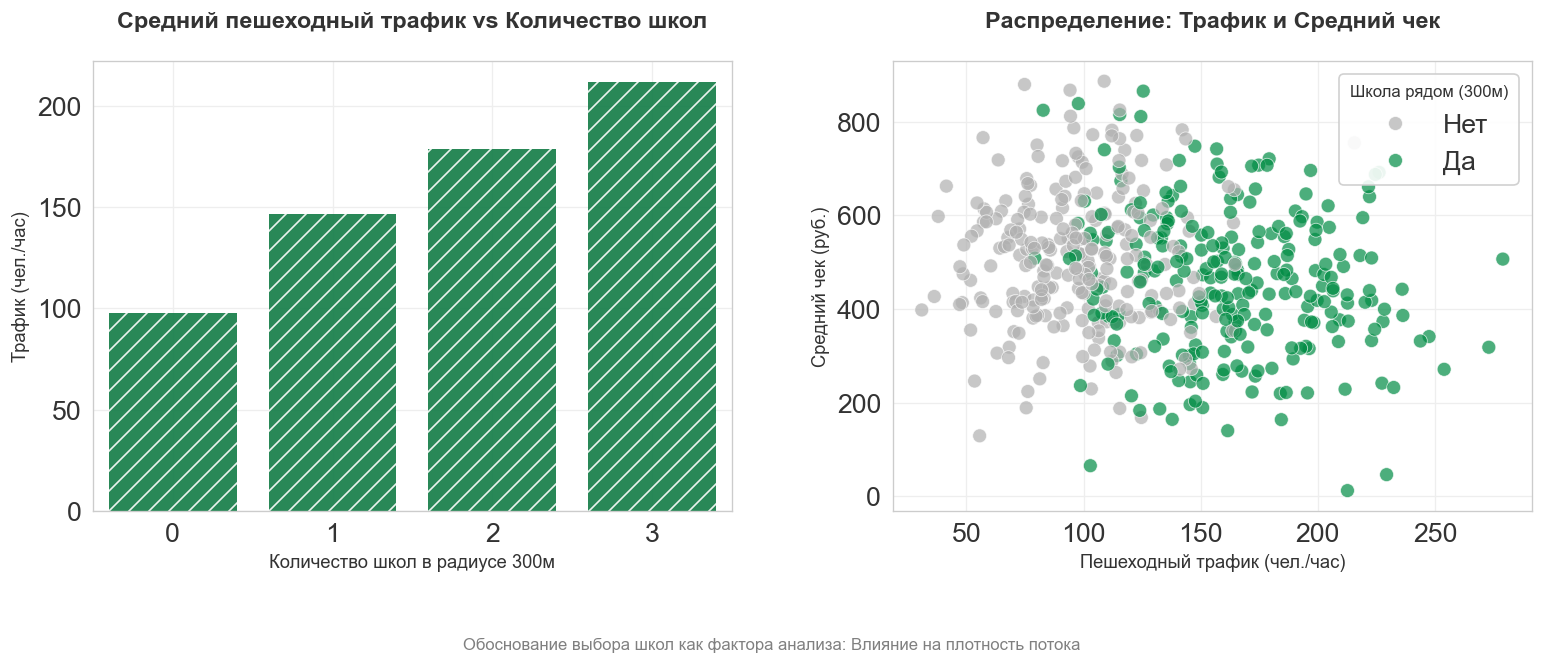

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# -------------------------------------------------------------------------
# 1. ГЕНЕРАЦИЯ ДЕМО-ДАННЫХ (Чтобы код работал сразу)
# В реальной работе этот блок нужно заменить на загрузку вашего df
# -------------------------------------------------------------------------
np.random.seed(42)
n = 500
data = {
    'new_id': range(n),
    'Трафик пеший, в час': np.random.normal(100, 30, n),
    'Средний чек': np.random.normal(500, 150, n),
    'Школы (300 м)': np.random.choice([0, 1, 2, 3], n, p=[0.5, 0.3, 0.15, 0.05])
}
df = pd.DataFrame(data)

# Добавляем искусственную зависимость для красоты графиков (школы повышают трафик)
df['Трафик пеший, в час'] += df['Школы (300 м)'] * 40 
# Немного снижаем чек у школ (дети покупают мелочь), но трафик выше
df['Средний чек'] -= df['Школы (300 м)'] * 30 

# Категория для раскраски
df['Есть школа'] = df['Школы (300 м)'].apply(lambda x: 'Да' if x > 0 else 'Нет')

# -------------------------------------------------------------------------
# 2. НАСТРОЙКА ВИЗУАЛЬНОГО СТИЛЯ (Под Пятёрочку)
# -------------------------------------------------------------------------
# Основные цвета из слайдов
pyaterochka_green = '#008C44'  # Насыщенный зеленый
light_green = '#E6F4EA'        # Светлый фон (подложка)
accent_red = '#E21E26'         # Акцент (если нужен)
dark_text = '#333333'

# Настройка глобальных параметров
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'text.color': dark_text,
    'axes.labelcolor': dark_text,
    'xtick.color': dark_text,
    'ytick.color': dark_text,
    'axes.edgecolor': '#CCCCCC',
    'grid.color': '#EEEEEE',
    'figure.dpi': 120
})

# -------------------------------------------------------------------------
# 3. ПОСТРОЕНИЕ ГРАФИКОВ
# -------------------------------------------------------------------------

# Создаем фигуру с двумя графиками рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white') # Белый фон для вставки на слайд-шаблон

# === ГРАФИК 1: Влияние школ на пешеходный трафик ===
# Обоснование: "Школы обеспечивают плотный поток людей"

# Агрегируем данные
traffic_by_school = df.groupby('Школы (300 м)')['Трафик пеший, в час'].mean().reset_index()

sns.barplot(
    data=traffic_by_school,
    x='Школы (300 м)',
    y='Трафик пеший, в час',
    ax=axes[0],
    color=pyaterochka_green,
    alpha=0.9,
    edgecolor=pyaterochka_green
)

# Добавляем узор (штриховку) на столбцы, чтобы перекликалось с дизайном слайдов
for patch in axes[0].patches:
    patch.set_hatch('//')
    patch.set_edgecolor('white') # Цвет штриховки
    patch.set_linewidth(0)

axes[0].set_title('Средний пешеходный трафик vs Количество школ', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Трафик (чел./час)', fontsize=11)
axes[0].set_xlabel('Количество школ в радиусе 300м', fontsize=11)
axes[0].grid(axis='x') # Убираем вертикальную сетку для чистоты

# === ГРАФИК 2: Кластеризация магазинов (Трафик vs Чек) ===
# Обоснование: "Магазины у школ формируют кластер High Traffic / Medium Check"

sns.scatterplot(
    data=df,
    x='Трафик пеший, в час',
    y='Средний чек',
    hue='Есть школа',
    palette={'Да': pyaterochka_green, 'Нет': '#B0B0B0'}, # Зеленый - есть школа, Серый - нет
    alpha=0.7,
    s=70,
    ax=axes[1],
    edgecolor='white',
    linewidth=0.5
)

axes[1].set_title('Распределение: Трафик и Средний чек', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Пешеходный трафик (чел./час)', fontsize=11)
axes[1].set_ylabel('Средний чек (руб.)', fontsize=11)
axes[1].legend(title='Школа рядом (300м)', title_fontsize=10, loc='upper right', frameon=True, framealpha=0.9)

# -------------------------------------------------------------------------
# 4. ФИНАЛЬНЫЕ ШТРИХИ И СОХРАНЕНИЕ
# -------------------------------------------------------------------------
plt.tight_layout(pad=3.0)

# Добавляем общий заголовок для понимания контекста (можно убрать при вставке)
plt.suptitle('Обоснование выбора школ как фактора анализа: Влияние на плотность потока', 
             fontsize=10, color='gray', y=0.02)

plt.show()

ПОИСК ОБОСНОВАНИЯ ДЛЯ ИССЛЕДОВАНИЯ ШКОЛ

Всего записей: 256711
Уникальных магазинов: 21743

Распределение по школам (300 м):
Школы (300 м)
0    179339
1     53570
2     18604
3      3710
4      1250
5       214
6        12
8        12
Name: count, dtype: int64

ИДЕЯ 1: Школы как маркер жилого района


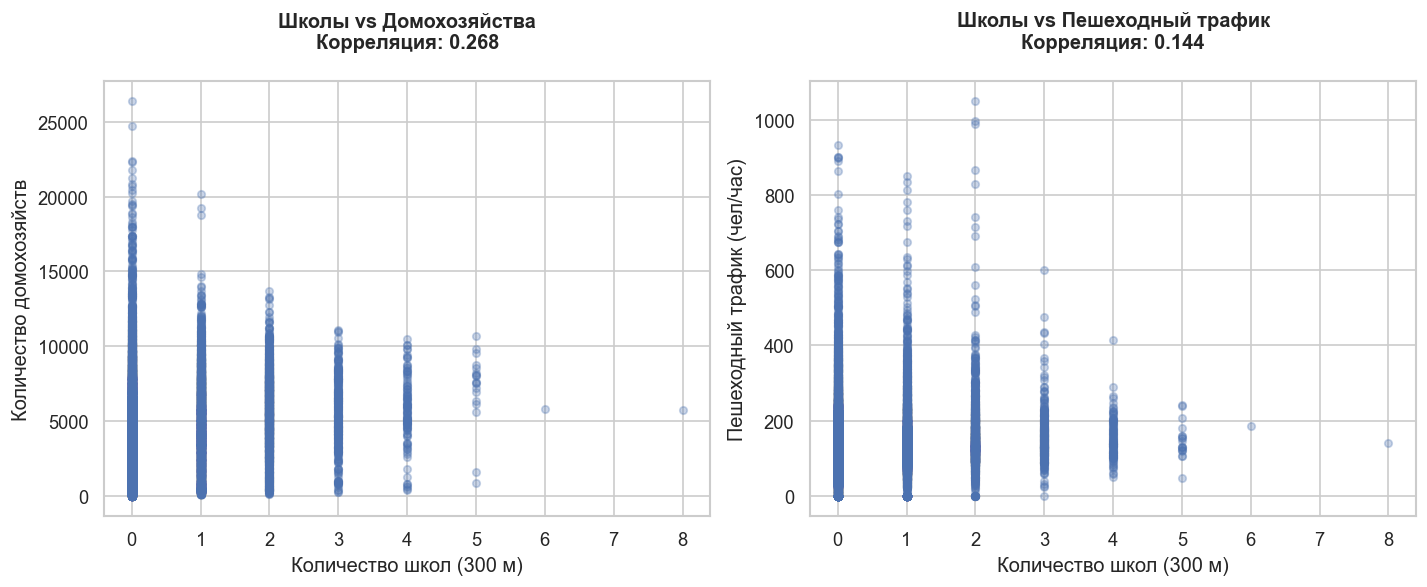

Корреляция школы-домохозяйства: 0.268
Корреляция школы-пешеходный трафик: 0.144

ИДЕЯ 2: Эффект школ в учебное время vs каникулы

Средний трафик по периодам и наличию школы:
Есть_школа                 0             1
Учебный_период                            
Каникулы        59844.387176  62696.510227
Учебный год     56782.576452  61398.231522


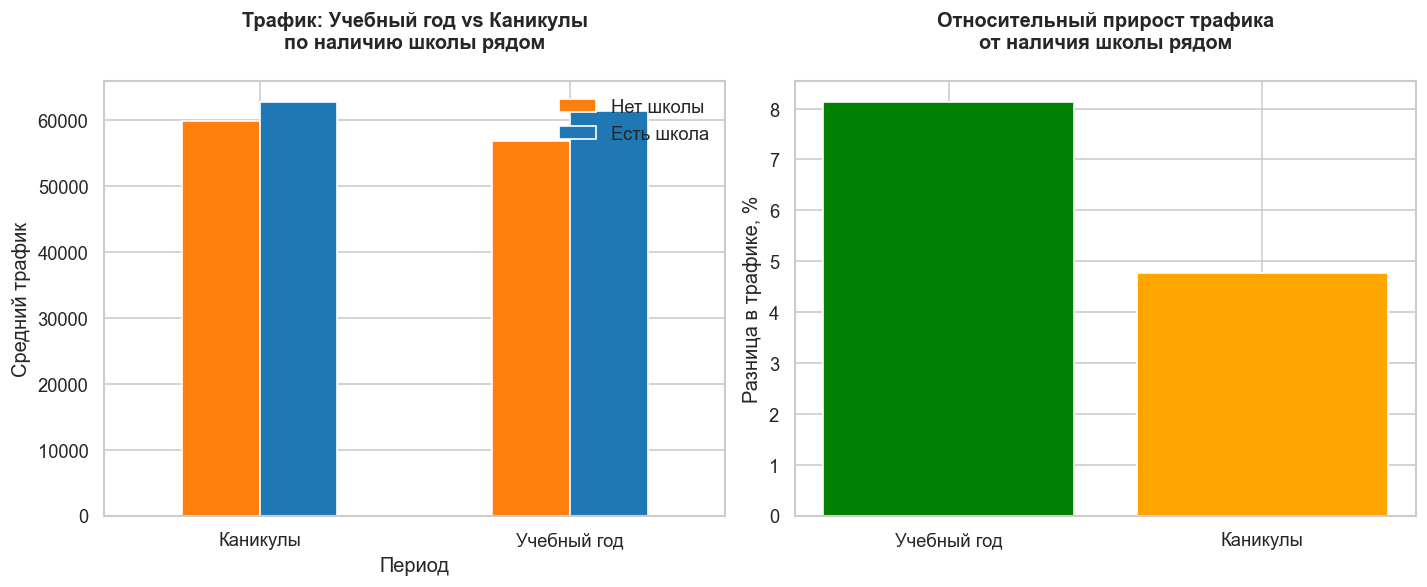


Разница трафика (есть школа vs нет) в учебный период: 8.13%
Разница трафика (есть школа vs нет) в каникулы: 4.77%

ИДЕЯ 3: География - доля магазинов рядом со школами


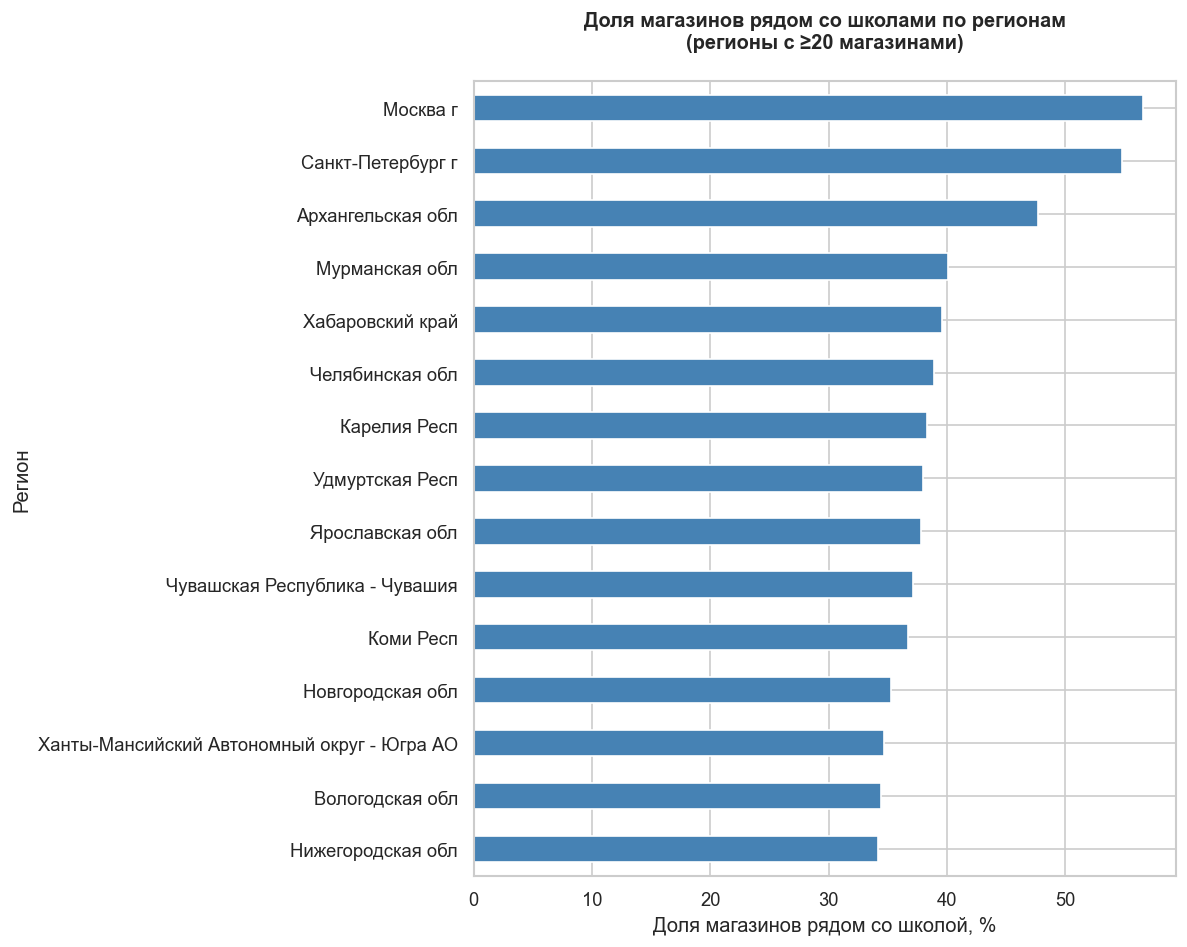


Регионов с ≥20 магазинами: 69
Мин. доля: 0.0%
Макс. доля: 56.5%

ИДЕЯ 4: Уникальность школ vs другие объекты


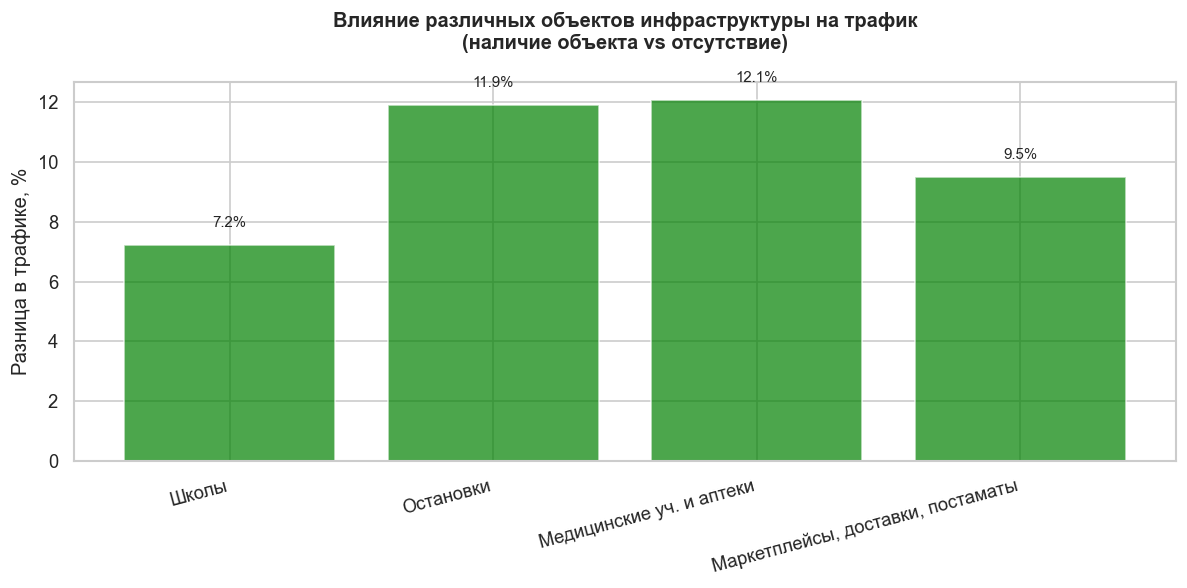


Эффект объектов инфраструктуры на трафик:
  Медицинские уч. и аптеки: +12.06%
  Остановки: +11.92%
  Маркетплейсы, доставки, постаматы: +9.50%
  Школы: +7.24%

ИДЕЯ 5: Связь школ с характеристиками магазина


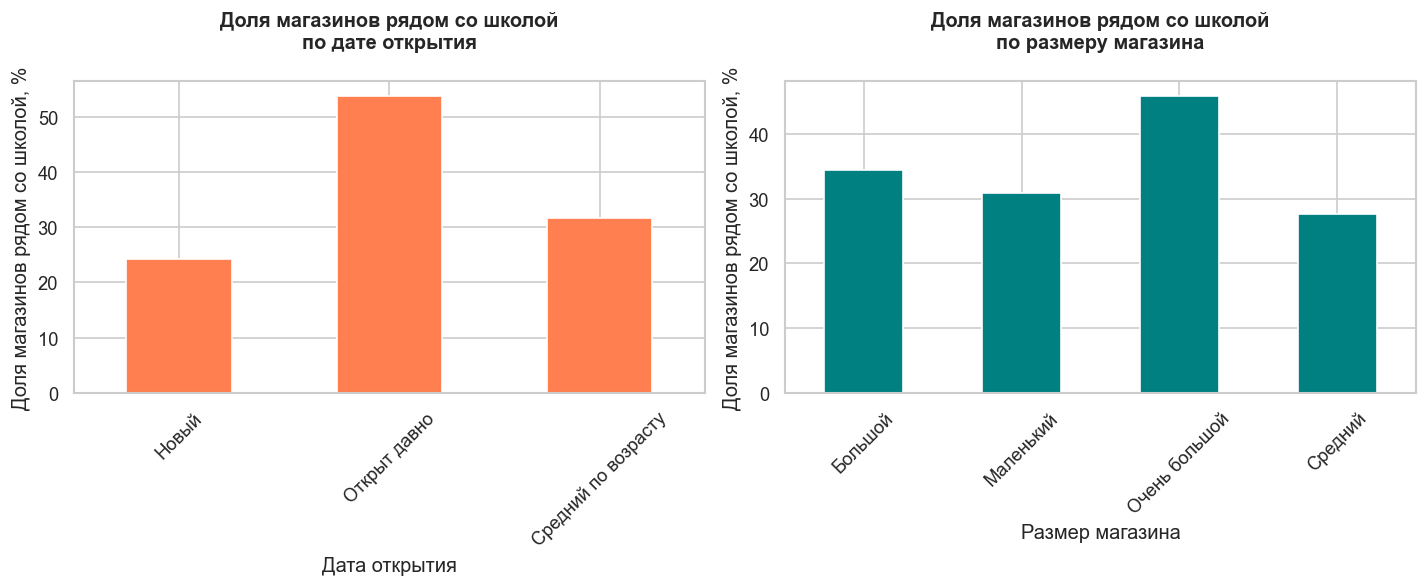


ИДЕЯ 6: Помесячная динамика эффекта школ


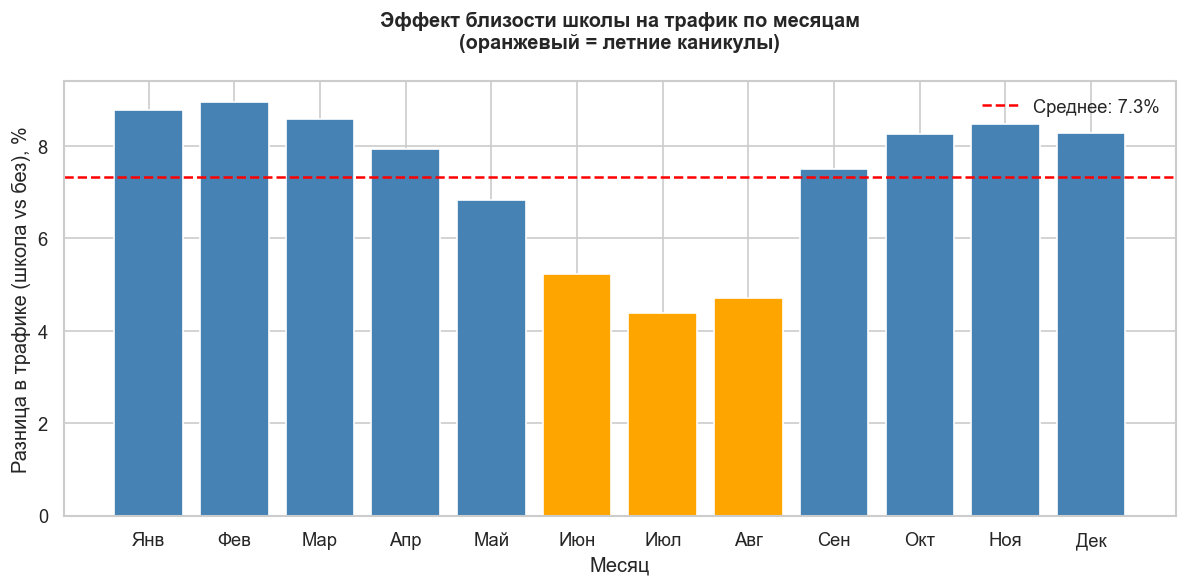


Эффект школы по месяцам:
  Янв: +8.78%
  Фев: +8.95%
  Мар: +8.59%
  Апр: +7.93%
  Май: +6.83%
  Июн: +5.22%
  Июл: +4.38%
  Авг: +4.71%
  Сен: +7.50%
  Окт: +8.25%
  Ноя: +8.47%
  Дек: +8.28%

ИТОГОВАЯ СТАТИСТИКА
Всего уникальных магазинов: 21743
Магазинов рядом со школой: 6541 (30.1%)
Магазинов без школы рядом: 15202 (69.9%)


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("="*60)
print("ПОИСК ОБОСНОВАНИЯ ДЛЯ ИССЛЕДОВАНИЯ ШКОЛ")
print("="*60)

# Проверка данных
print(f"\nВсего записей: {len(df)}")
print(f"Уникальных магазинов: {df['new_id'].nunique()}")
print(f"\nРаспределение по школам (300 м):")
print(df['Школы (300 м)'].value_counts().sort_index())

# === ИДЕЯ 1: Школы как маркер жилого района ===
print("\n" + "="*60)
print("ИДЕЯ 1: Школы как маркер жилого района")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Школы vs Домохозяйства
df_agg = df.groupby('new_id').agg({
    'Школы (300 м)': 'first',
    'Количество домохозяйств': 'first',
    'Трафик пеший, в час': 'first'
}).reset_index()

corr1 = df_agg['Школы (300 м)'].corr(df_agg['Количество домохозяйств'])
axes[0].scatter(df_agg['Школы (300 м)'], df_agg['Количество домохозяйств'], alpha=0.3, s=20)
axes[0].set_xlabel('Количество школ (300 м)')
axes[0].set_ylabel('Количество домохозяйств')
axes[0].set_title(f'Школы vs Домохозяйства\nКорреляция: {corr1:.3f}')

# Школы vs Пеший трафик
corr2 = df_agg['Школы (300 м)'].corr(df_agg['Трафик пеший, в час'])
axes[1].scatter(df_agg['Школы (300 м)'], df_agg['Трафик пеший, в час'], alpha=0.3, s=20)
axes[1].set_xlabel('Количество школ (300 м)')
axes[1].set_ylabel('Пешеходный трафик (чел/час)')
axes[1].set_title(f'Школы vs Пешеходный трафик\nКорреляция: {corr2:.3f}')

plt.tight_layout()
plt.savefig('idea1_schools_as_residential_marker.png', dpi=100)
plt.show()

print(f"Корреляция школы-домохозяйства: {corr1:.3f}")
print(f"Корреляция школы-пешеходный трафик: {corr2:.3f}")

# === ИДЕЯ 2: Сезонность - учебный год vs каникулы ===
print("\n" + "="*60)
print("ИДЕЯ 2: Эффект школ в учебное время vs каникулы")
print("="*60)

df['Учебный_период'] = df['Месяц'].apply(lambda x: 'Учебный год' if x in [1,2,3,4,5,9,10,11,12] else 'Каникулы')
df['Есть_школа'] = (df['Школы (300 м)'] > 0).astype(int)

# Расчёт среднего трафика по группам
grouped = df.groupby(['Учебный_период', 'Есть_школа'])['Трафик'].mean().unstack()
print("\nСредний трафик по периодам и наличию школы:")
print(grouped)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Трафик по периодам
grouped.plot(kind='bar', ax=axes[0], color=['#ff7f0e', '#1f77b4'])
axes[0].set_xlabel('Период')
axes[0].set_ylabel('Средний трафик')
axes[0].set_title('Трафик: Учебный год vs Каникулы\nпо наличию школы рядом')
axes[0].legend(['Нет школы', 'Есть школа'])
axes[0].tick_params(axis='x', rotation=0)

# Относительная разница
diff_ucheb = (grouped.loc['Учебный год', 1] - grouped.loc['Учебный год', 0]) / grouped.loc['Учебный год', 0] * 100
diff_kanik = (grouped.loc['Каникулы', 1] - grouped.loc['Каникулы', 0]) / grouped.loc['Каникулы', 0] * 100

axes[1].bar(['Учебный год', 'Каникулы'], [diff_ucheb, diff_kanik], color=['green', 'orange'])
axes[1].set_ylabel('Разница в трафике, %')
axes[1].set_title('Относительный прирост трафика\nот наличия школы рядом')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('idea2_school_effect_by_period.png', dpi=100)
plt.show()

print(f"\nРазница трафика (есть школа vs нет) в учебный период: {diff_ucheb:.2f}%")
print(f"Разница трафика (есть школа vs нет) в каникулы: {diff_kanik:.2f}%")

# === ИДЕЯ 3: Доля магазинов рядом со школами по регионам ===
print("\n" + "="*60)
print("ИДЕЯ 3: География - доля магазинов рядом со школами")
print("="*60)

df_unique = df.drop_duplicates('new_id')
region_stats = df_unique.groupby('Регион').agg({
    'new_id': 'count',
    'Есть_школа': 'sum'
}).rename(columns={'new_id': 'Всего_магазинов', 'Есть_школа': 'Рядом_со_школой'})
region_stats['Доля_%'] = region_stats['Рядом_со_школой'] / region_stats['Всего_магазинов'] * 100

# Фильтруем регионы с достаточным количеством магазинов (минимум 20)
region_stats_filtered = region_stats[region_stats['Всего_магазинов'] >= 20].sort_values('Доля_%', ascending=True)

if len(region_stats_filtered) >= 5:
    plt.figure(figsize=(10, 8))
    top_n = min(15, len(region_stats_filtered))
    region_stats_filtered.tail(top_n)['Доля_%'].plot(kind='barh', color='steelblue')
    plt.xlabel('Доля магазинов рядом со школой, %')
    plt.title(f'Доля магазинов рядом со школами по регионам\n(регионы с ≥20 магазинами)')
    plt.tight_layout()
    plt.savefig('idea3_school_share_by_region.png', dpi=100)
    plt.show()
    
    print(f"\nРегионов с ≥20 магазинами: {len(region_stats_filtered)}")
    print(f"Мин. доля: {region_stats_filtered['Доля_%'].min():.1f}%")
    print(f"Макс. доля: {region_stats_filtered['Доля_%'].max():.1f}%")
else:
    print("Недостаточно данных для построения графика")

# === ИДЕЯ 4: Сравнение влияния разных объектов инфраструктуры ===
print("\n" + "="*60)
print("ИДЕЯ 4: Уникальность школ vs другие объекты")
print("="*60)

infra_cols = ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 
              'Маркетплейсы, доставки, постаматы (100 м)']

# Для каждого типа объектов считаем "эффект" - разницу в трафике
effects = {}
for col in infra_cols:
    if col in df.columns:
        has_obj = df[df[col] > 0]['Трафик'].mean()
        no_obj = df[df[col] == 0]['Трафик'].mean()
        n_has = (df[col] > 0).sum()
        n_no = (df[col] == 0).sum()
        if n_has > 100 and n_no > 100:  # Достаточно данных
            effect = (has_obj - no_obj) / no_obj * 100
            effects[col.replace(' (300 м)', '').replace(' (100 м)', '')] = effect

if effects:
    plt.figure(figsize=(10, 5))
    colors = ['green' if v > 0 else 'red' for v in effects.values()]
    bars = plt.bar(effects.keys(), effects.values(), color=colors, alpha=0.7)
    plt.ylabel('Разница в трафике, %')
    plt.title('Влияние различных объектов инфраструктуры на трафик\n(наличие объекта vs отсутствие)')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.xticks(rotation=15, ha='right')
    
    # Добавляем значения на столбцы
    for bar, val in zip(bars, effects.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('idea4_infrastructure_comparison.png', dpi=100)
    plt.show()
    
    print("\nЭффект объектов инфраструктуры на трафик:")
    for k, v in sorted(effects.items(), key=lambda x: x[1], reverse=True):
        print(f"  {k}: {v:+.2f}%")

# === ИДЕЯ 5: Школы и тип магазина ===
print("\n" + "="*60)
print("ИДЕЯ 5: Связь школ с характеристиками магазина")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# По дате открытия
if 'Дата открытия, категориальный' in df.columns:
    opening_school = df_unique.groupby('Дата открытия, категориальный')['Есть_школа'].mean() * 100
    if len(opening_school) >= 2:
        opening_school.plot(kind='bar', ax=axes[0], color='coral')
        axes[0].set_xlabel('Дата открытия')
        axes[0].set_ylabel('Доля магазинов рядом со школой, %')
        axes[0].set_title('Доля магазинов рядом со школой\nпо дате открытия')
        axes[0].tick_params(axis='x', rotation=45)

# По размеру
if 'Торговая площадь, категориальный' in df.columns:
    size_school = df_unique.groupby('Торговая площадь, категориальный')['Есть_школа'].mean() * 100
    if len(size_school) >= 2:
        size_school.plot(kind='bar', ax=axes[1], color='teal')
        axes[1].set_xlabel('Размер магазина')
        axes[1].set_ylabel('Доля магазинов рядом со школой, %')
        axes[1].set_title('Доля магазинов рядом со школой\nпо размеру магазина')
        axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('idea5_schools_by_store_type.png', dpi=100)
plt.show()

# === ИДЕЯ 6: Помесячная динамика эффекта школ ===
print("\n" + "="*60)
print("ИДЕЯ 6: Помесячная динамика эффекта школ")
print("="*60)

monthly_effect = []
for month in range(1, 13):
    month_data = df[df['Месяц'] == month]
    has_school = month_data[month_data['Школы (300 м)'] > 0]['Трафик'].mean()
    no_school = month_data[month_data['Школы (300 м)'] == 0]['Трафик'].mean()
    effect = (has_school - no_school) / no_school * 100
    monthly_effect.append(effect)

plt.figure(figsize=(10, 5))
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
colors = ['orange' if m in [6, 7, 8] else 'steelblue' for m in range(1, 13)]
plt.bar(months, monthly_effect, color=colors)
plt.axhline(y=np.mean(monthly_effect), color='red', linestyle='--', label=f'Среднее: {np.mean(monthly_effect):.1f}%')
plt.xlabel('Месяц')
plt.ylabel('Разница в трафике (школа vs без), %')
plt.title('Эффект близости школы на трафик по месяцам\n(оранжевый = летние каникулы)')
plt.legend()
plt.tight_layout()
plt.savefig('idea6_monthly_school_effect.png', dpi=100)
plt.show()

print("\nЭффект школы по месяцам:")
for m, e in zip(months, monthly_effect):
    print(f"  {m}: {e:+.2f}%")

# === ИТОГОВАЯ СТАТИСТИКА ===
print("\n" + "="*60)
print("ИТОГОВАЯ СТАТИСТИКА")
print("="*60)
print(f"Всего уникальных магазинов: {df['new_id'].nunique()}")
print(f"Магазинов рядом со школой: {(df_unique['Школы (300 м)'] > 0).sum()} ({(df_unique['Школы (300 м)'] > 0).mean()*100:.1f}%)")
print(f"Магазинов без школы рядом: {(df_unique['Школы (300 м)'] == 0).sum()} ({(df_unique['Школы (300 м)'] == 0).mean()*100:.1f}%)")

ПРОВЕРКА ДАННЫХ
Всего записей: 256711
Уникальных магазинов: 21743

Доступные колонки:
['new_id', 'Месяц', 'Трафик', 'Средний чек', 'Дата открытия, категориальный', 'Торговая площадь, категориальный', 'Населенный пункт', 'Регион', 'Численность населения', 'Количество домохозяйств', 'Трафик пеший, в час', 'Трафик авто, в час', 'Маркетплейсы, доставки, постаматы (100 м)', 'Медицинские уч. и аптеки (300 м)', 'Школы (300 м)', 'Остановки (300 м)', 'Продуктовые магазины (500 м)', 'Пятерочки (500 м)', 'Индекс_РИА_2024', 'traffic_flag', 'is_season', 'has_school', 'traffic_norm', 'Учебный_период', 'Есть_школа', 'Есть школа', 'Период']

Распределение школ (300 м):
Школы (300 м)
0    15202
1     4529
2     1574
3      309
4      108
5       19
6        1
8        1
Name: count, dtype: int64

Найденные инфраструктурные колонки: ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 'Маркетплейсы, доставки, постаматы (100 м)', 'Продуктовые магазины (500 м)']

Магазинов для анализ

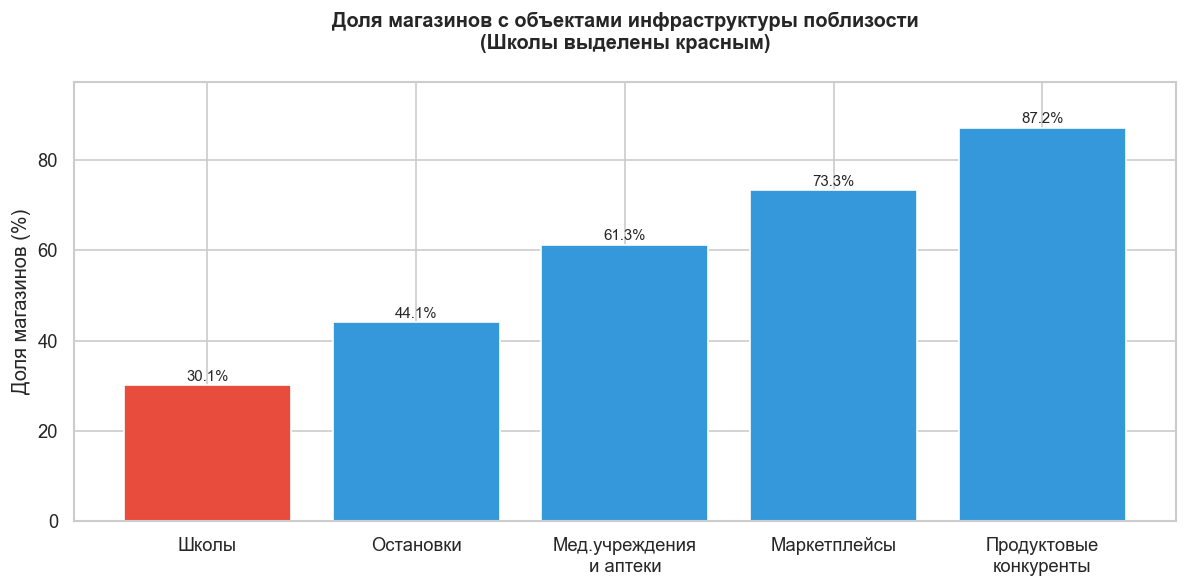


Магазинов по категориям школ:
Категория школ
0 школ      15202
1 школа      4529
2+ школы     2012
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_32020\985035199.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_df, x='Категория школ', y='Трафик', order=order,
C:\Users\User\AppData\Local\Temp\ipykernel_32020\985035199.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_df, x='Категория школ', y='Средний чек', order=order,


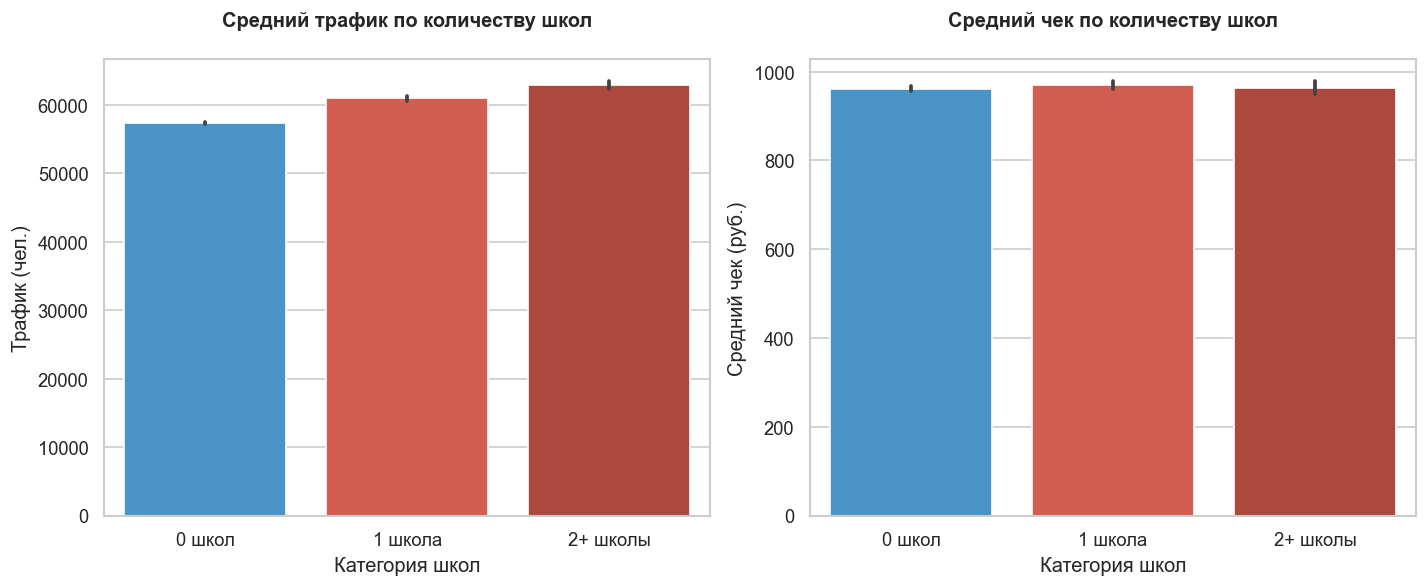


Размеры групп (пеший трафик x школа):
Есть школа                False  True 
Пеший трафик (категория)              
Низкий                     5963   1287
Средний                    4755   2491
Высокий                    4484   2763


C:\Users\User\AppData\Local\Temp\ipykernel_32020\985035199.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = store_df.groupby(['Пеший трафик (категория)', 'Есть школа'])['Трафик'].mean().unstack()


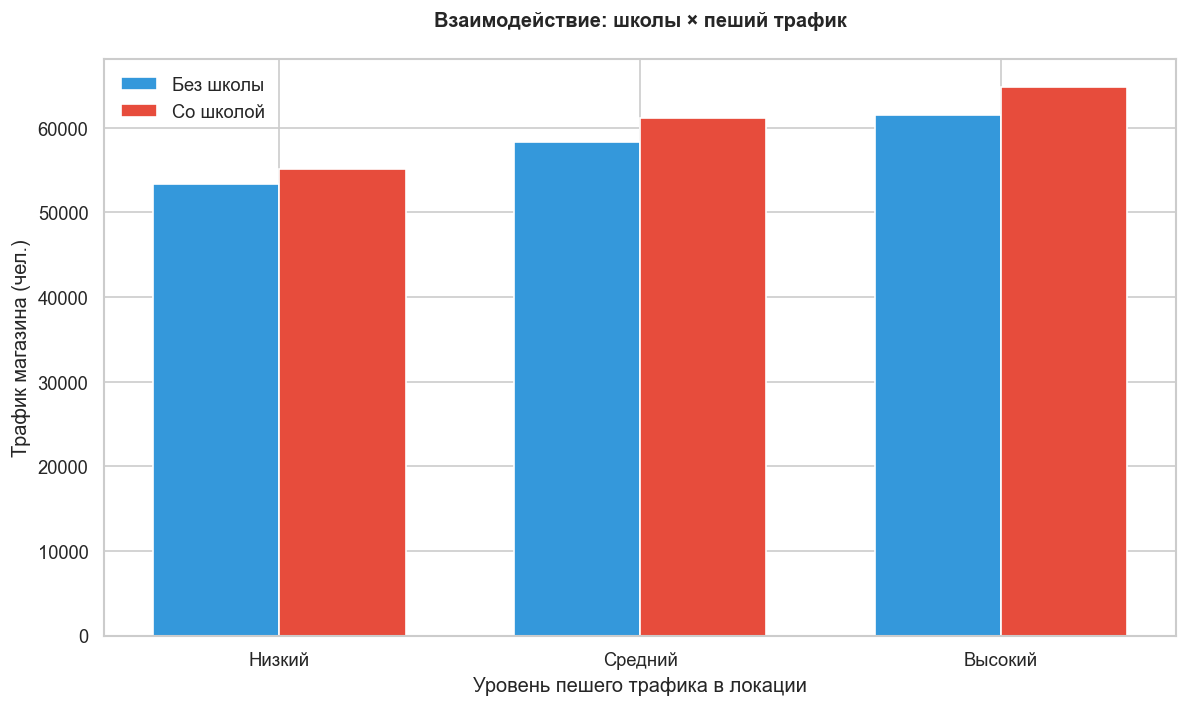


Прирост трафика от наличия школы:
Пеший трафик (категория)
Низкий     3.4
Средний    4.8
Высокий    5.4
Name: Прирост %, dtype: float64


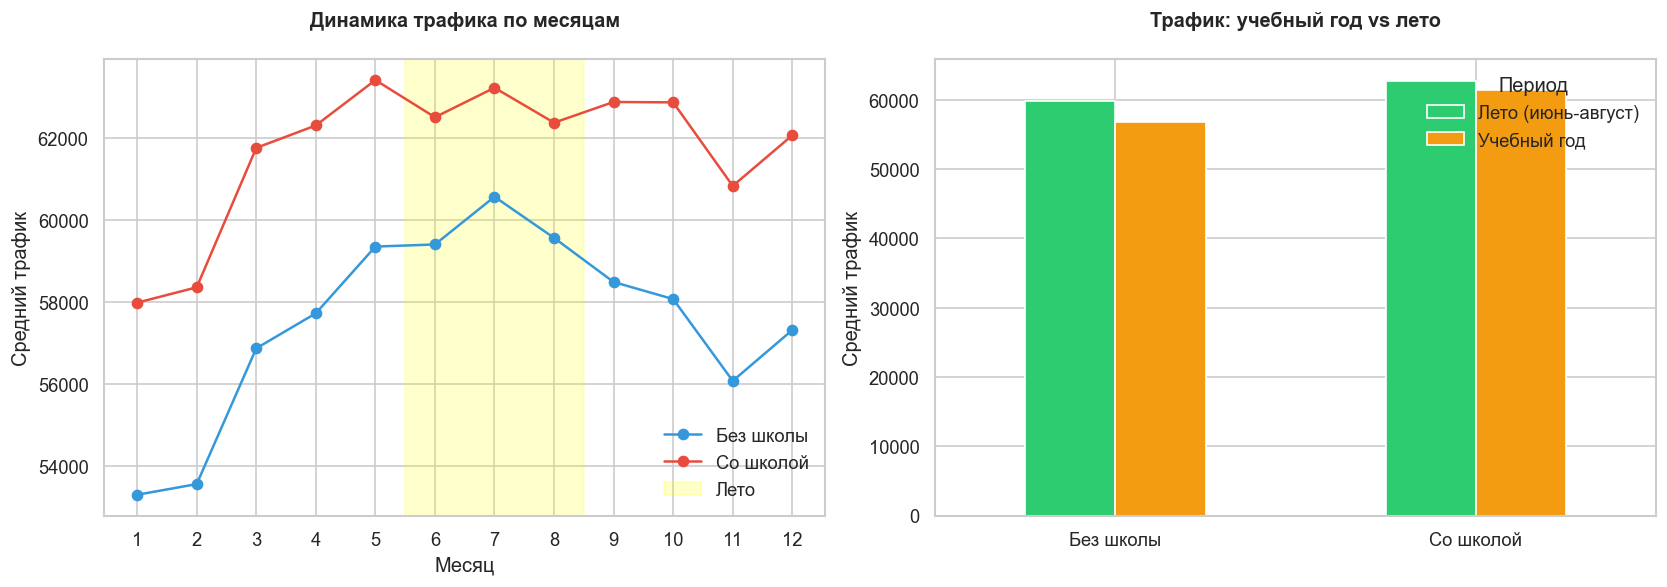


Сезонность трафика (лето / учебный год):
  Без школы: +5.4%
  Со школой: +2.1%


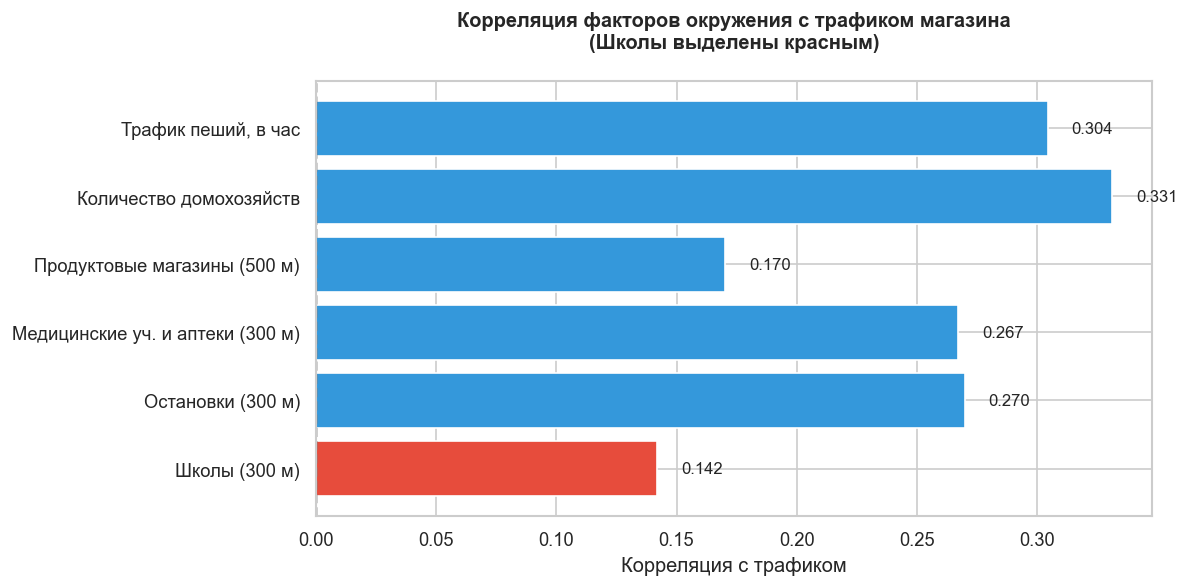


ИТОГОВАЯ СТАТИСТИКА

Средний трафик:
  - Со школой: 61545 (n=6541)
  - Без школы: 57354 (n=15202)
  - Разница: 4191
  - T-тест p-value: 0.0000

Корреляции с трафиком:
  Школы (300 м): r = 0.142
  Остановки (300 м): r = 0.270
  Медицинские уч. и аптеки (300 м): r = 0.267
  Продуктовые магазины (500 м): r = 0.170
  Количество домохозяйств: r = 0.331
  Трафик пеший, в час: r = 0.304


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================================
# ПРОВЕРКА ДАННЫХ И КОЛОНОК
# ============================================================
print("=" * 60)
print("ПРОВЕРКА ДАННЫХ")
print("=" * 60)
print(f"Всего записей: {len(df)}")
print(f"Уникальных магазинов: {df['new_id'].nunique()}")
print(f"\nДоступные колонки:")
print(df.columns.tolist())

print(f"\nРаспределение школ (300 м):")
print(df.groupby('new_id')['Школы (300 м)'].first().value_counts().sort_index())

# Определяем какие инфраструктурные колонки есть
potential_infra = {
    'Школы (300 м)': 'Школы',
    'Остановки (300 м)': 'Остановки',
    'Медицинские уч. и аптеки (300 м)': 'Мед.учреждения\nи аптеки',
    'Маркетплейсы, доставки, постаматы (100 м)': 'Маркетплейсы',
    'Продуктовые магазины (500 м)': 'Продуктовые\nконкуренты',
    'Пятёрочки (500 м)': 'Другие\nПятёрочки'
}

# Оставляем только существующие колонки
infra_cols = {k: v for k, v in potential_infra.items() if k in df.columns}
print(f"\nНайденные инфраструктурные колонки: {list(infra_cols.keys())}")

# Агрегация на уровне магазина (средние за год)
agg_dict = {
    'Трафик': 'mean',
    'Средний чек': 'mean',
    'Школы (300 м)': 'first',
}

# Добавляем только существующие колонки
for col in ['Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 
            'Маркетплейсы, доставки, постаматы (100 м)', 'Продуктовые магазины (500 м)',
            'Количество домохозяйств', 'Трафик пеший, в час']:
    if col in df.columns:
        agg_dict[col] = 'first'

store_df = df.groupby('new_id').agg(agg_dict).reset_index()

print(f"\nМагазинов для анализа: {len(store_df)}")
print(f"Магазинов со школами: {(store_df['Школы (300 м)'] > 0).sum()}")
print(f"Магазинов без школ: {(store_df['Школы (300 м)'] == 0).sum()}")

# ============================================================
# ГРАФИК 1: Охват магазинов объектами инфраструктуры
# Обоснование: школы присутствуют у значимой доли магазинов
# ============================================================
if len(infra_cols) >= 2:
    presence = {label: (store_df[col] > 0).mean() * 100 for col, label in infra_cols.items() if col in store_df.columns}

    plt.figure(figsize=(10, 5))
    colors = ['#e74c3c' if k == 'Школы' else '#3498db' for k in presence.keys()]
    bars = plt.bar(presence.keys(), presence.values(), color=colors)
    plt.ylabel('Доля магазинов (%)')
    plt.title('Доля магазинов с объектами инфраструктуры поблизости\n(Школы выделены красным)')
    for i, v in enumerate(presence.values()):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=9)
    plt.ylim(0, max(presence.values()) + 10)
    plt.tight_layout()
    plt.show()

# ============================================================
# ГРАФИК 2: Нелинейность влияния школ (0, 1, 2+ школы)
# ============================================================
store_df['Категория школ'] = store_df['Школы (300 м)'].apply(
    lambda x: '0 школ' if x == 0 else ('1 школа' if x == 1 else '2+ школы')
)

cat_counts = store_df['Категория школ'].value_counts()
print(f"\nМагазинов по категориям школ:")
print(cat_counts)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

order = ['0 школ', '1 школа', '2+ школы']
# Оставляем только категории с данными
order = [o for o in order if o in cat_counts.index and cat_counts[o] >= 5]

sns.barplot(data=store_df, x='Категория школ', y='Трафик', order=order, 
            ax=axes[0], errorbar='ci', palette=['#3498db', '#e74c3c', '#c0392b'][:len(order)])
axes[0].set_title('Средний трафик по количеству школ')
axes[0].set_ylabel('Трафик (чел.)')

sns.barplot(data=store_df, x='Категория школ', y='Средний чек', order=order,
            ax=axes[1], errorbar='ci', palette=['#3498db', '#e74c3c', '#c0392b'][:len(order)])
axes[1].set_title('Средний чек по количеству школ')
axes[1].set_ylabel('Средний чек (руб.)')

plt.tight_layout()
plt.show()

# ============================================================
# ГРАФИК 3: Взаимодействие школ с пешим трафиком (если есть данные)
# ============================================================
store_df['Есть школа'] = store_df['Школы (300 м)'] > 0

if 'Трафик пеший, в час' in store_df.columns and store_df['Трафик пеший, в час'].notna().sum() > 50:
    store_df['Пеший трафик (категория)'] = pd.qcut(
        store_df['Трафик пеший, в час'].dropna(), q=3, labels=['Низкий', 'Средний', 'Высокий']
    )
    
    # Проверяем размеры групп
    cross_tab = pd.crosstab(store_df['Пеший трафик (категория)'], store_df['Есть школа'])
    print(f"\nРазмеры групп (пеший трафик x школа):")
    print(cross_tab)
    
    if cross_tab.min().min() >= 10:
        plt.figure(figsize=(10, 6))
        
        pivot = store_df.groupby(['Пеший трафик (категория)', 'Есть школа'])['Трафик'].mean().unstack()
        pivot.columns = ['Без школы', 'Со школой']
        
        x = np.arange(3)
        width = 0.35
        
        plt.bar(x - width/2, pivot['Без школы'], width, label='Без школы', color='#3498db')
        plt.bar(x + width/2, pivot['Со школой'], width, label='Со школой', color='#e74c3c')
        
        plt.xlabel('Уровень пешего трафика в локации')
        plt.ylabel('Трафик магазина (чел.)')
        plt.title('Взаимодействие: школы × пеший трафик')
        plt.xticks(x, ['Низкий', 'Средний', 'Высокий'])
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        pivot['Прирост %'] = (pivot['Со школой'] / pivot['Без школы'] - 1) * 100
        print(f"\nПрирост трафика от наличия школы:")
        print(pivot['Прирост %'].round(1))

# ============================================================
# ГРАФИК 4: Сезонный эффект (учебный год vs лето)
# ============================================================
df['Есть школа'] = df['Школы (300 м)'] > 0
df['Период'] = df['Месяц'].apply(lambda x: 'Лето (июнь-август)' if x in [6, 7, 8] else 'Учебный год')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Линейный график по месяцам
monthly = df.groupby(['Месяц', 'Есть школа'])['Трафик'].mean().unstack()
monthly.columns = ['Без школы', 'Со школой']

monthly.plot(ax=axes[0], marker='o', color=['#3498db', '#e74c3c'])
axes[0].axvspan(5.5, 8.5, alpha=0.2, color='yellow', label='Лето')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Средний трафик')
axes[0].set_title('Динамика трафика по месяцам')
axes[0].set_xticks(range(1, 13))
axes[0].legend()

# Сравнение по периодам
period_data = df.groupby(['Есть школа', 'Период'])['Трафик'].mean().unstack()
period_data.index = ['Без школы', 'Со школой']

period_data.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f39c12'])
axes[1].set_xlabel('')
axes[1].set_ylabel('Средний трафик')
axes[1].set_title('Трафик: учебный год vs лето')
axes[1].legend(title='Период')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Считаем разницу в сезонности
print("\nСезонность трафика (лето / учебный год):")
for school in [False, True]:
    subset = df[df['Есть школа'] == school]
    summer = subset[subset['Период'] == 'Лето (июнь-август)']['Трафик'].mean()
    study = subset[subset['Период'] == 'Учебный год']['Трафик'].mean()
    pct = (summer / study - 1) * 100
    label = "Со школой" if school else "Без школы"
    print(f"  {label}: {pct:+.1f}%")

# ============================================================
# ГРАФИК 5: Сравнение корреляций разных объектов с трафиком
# ============================================================
corr_cols = ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)',
             'Продуктовые магазины (500 м)', 'Количество домохозяйств', 'Трафик пеший, в час']
corr_cols = [c for c in corr_cols if c in store_df.columns]

if len(corr_cols) >= 3:
    correlations = {col: store_df[col].corr(store_df['Трафик']) for col in corr_cols}
    
    plt.figure(figsize=(10, 5))
    colors = ['#e74c3c' if 'Школы' in k else '#3498db' for k in correlations.keys()]
    bars = plt.barh(list(correlations.keys()), list(correlations.values()), color=colors)
    plt.xlabel('Корреляция с трафиком')
    plt.title('Корреляция факторов окружения с трафиком магазина\n(Школы выделены красным)')
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    for i, v in enumerate(correlations.values()):
        plt.text(v + 0.01 if v >= 0 else v - 0.05, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# ============================================================
# ИТОГОВАЯ СТАТИСТИКА
# ============================================================
print("\n" + "=" * 60)
print("ИТОГОВАЯ СТАТИСТИКА")
print("=" * 60)

with_school = store_df[store_df['Школы (300 м)'] > 0]['Трафик']
without_school = store_df[store_df['Школы (300 м)'] == 0]['Трафик']
t_stat, p_value = stats.ttest_ind(with_school, without_school)

print(f"\nСредний трафик:")
print(f"  - Со школой: {with_school.mean():.0f} (n={len(with_school)})")
print(f"  - Без школы: {without_school.mean():.0f} (n={len(without_school)})")
print(f"  - Разница: {with_school.mean() - without_school.mean():.0f}")
print(f"  - T-тест p-value: {p_value:.4f}")

print("\nКорреляции с трафиком:")
for col in corr_cols:
    corr = store_df[col].corr(store_df['Трафик'])
    print(f"  {col}: r = {corr:.3f}")

In [ ]:
С дизайном

8

АНАЛИЗ ДАННЫХ ДЛЯ ПРЕЗЕНТАЦИИ


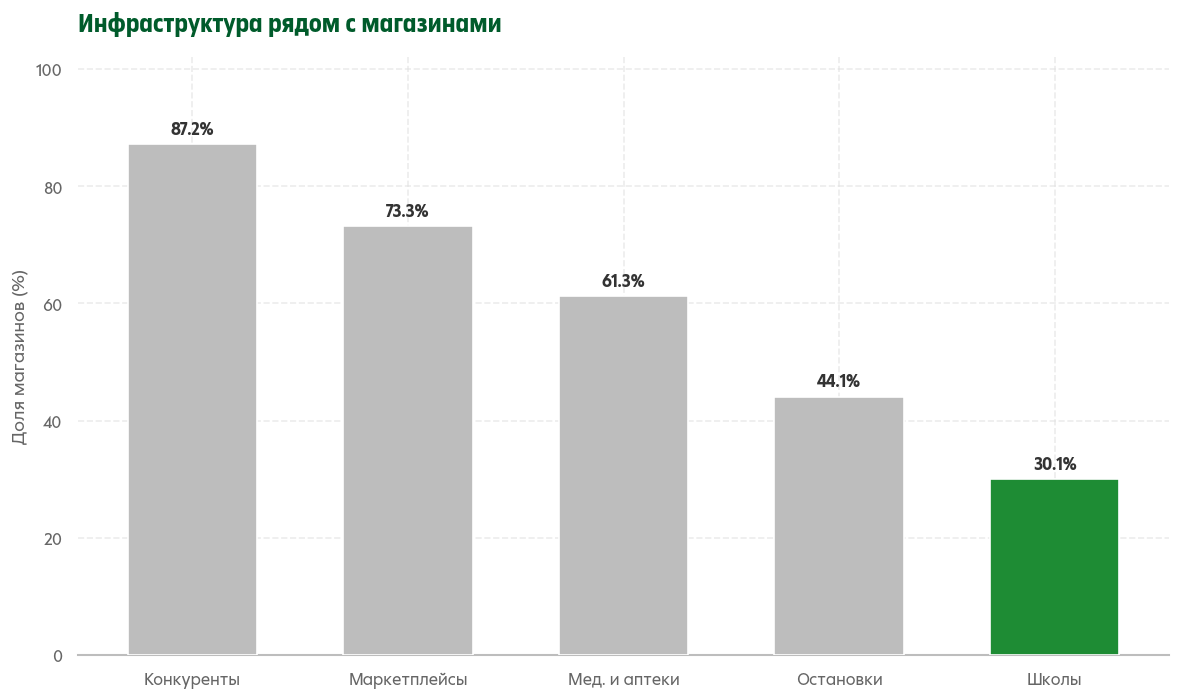

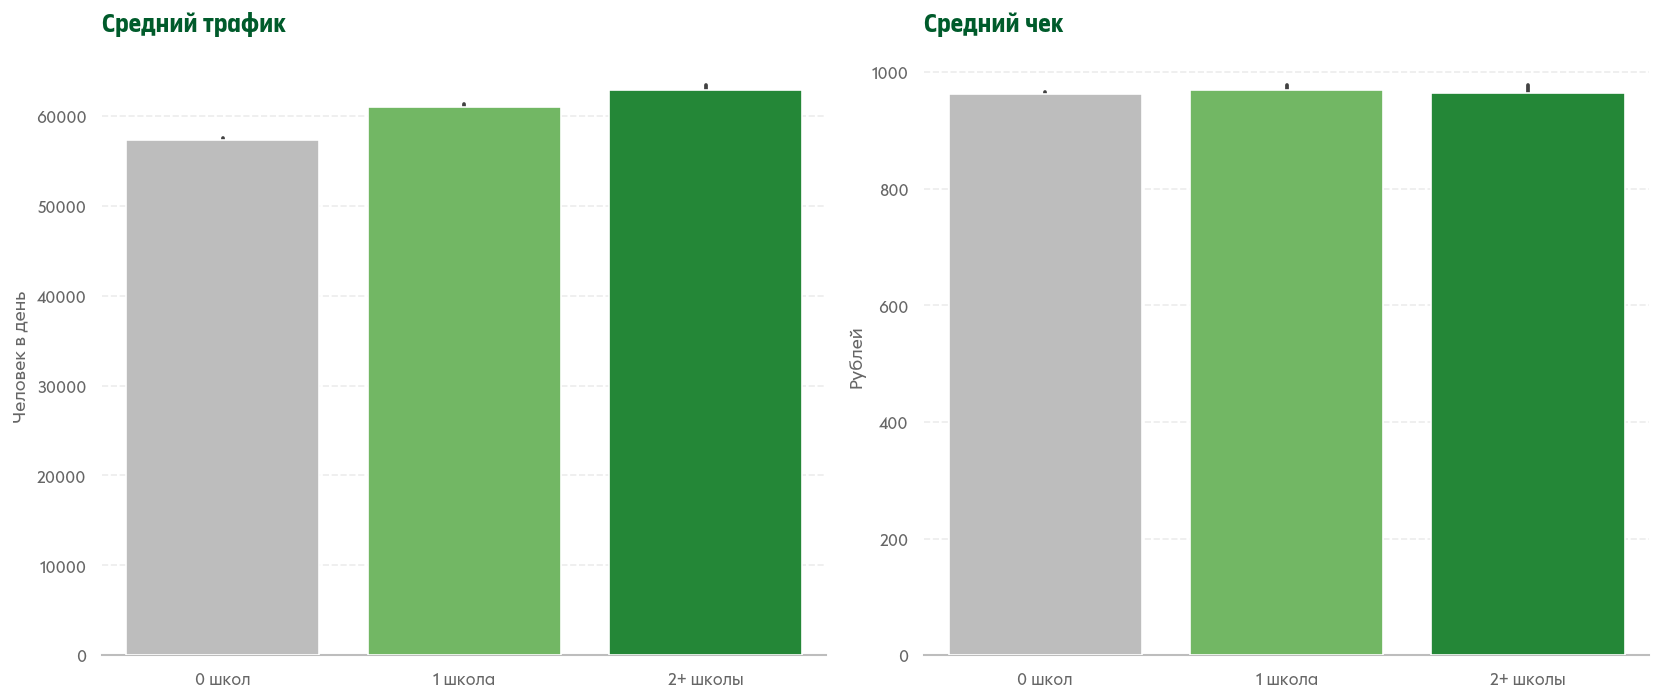

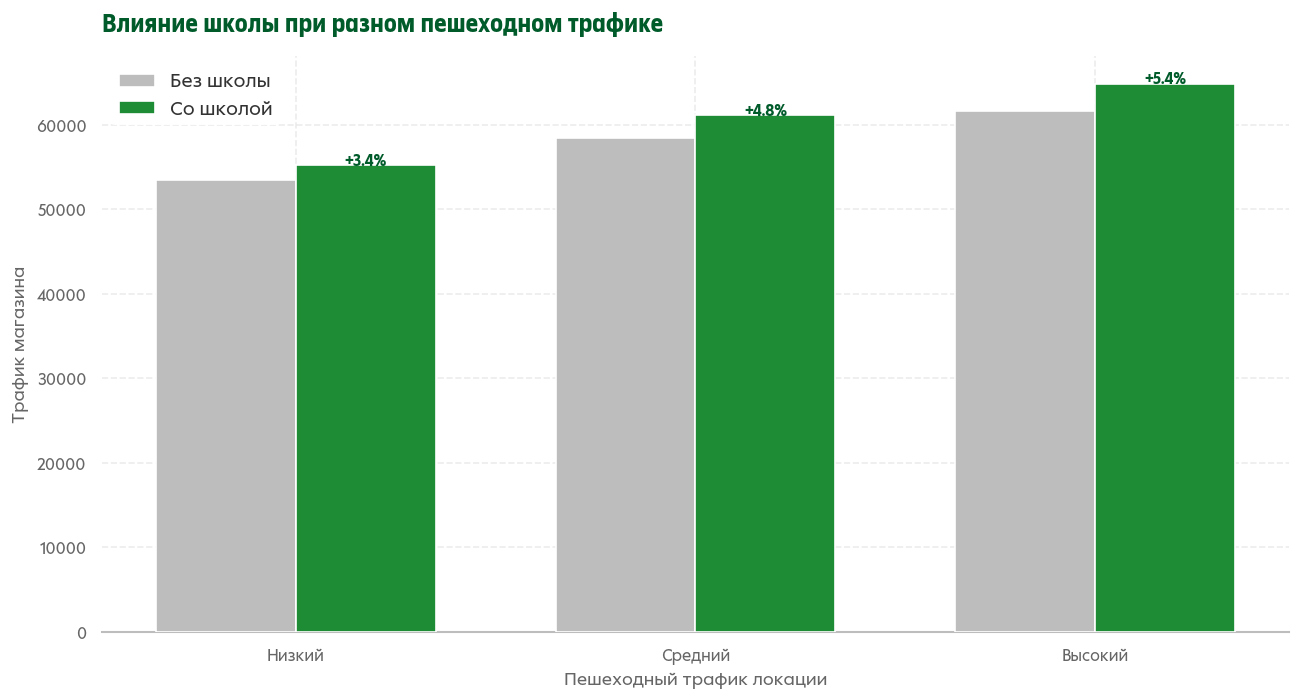

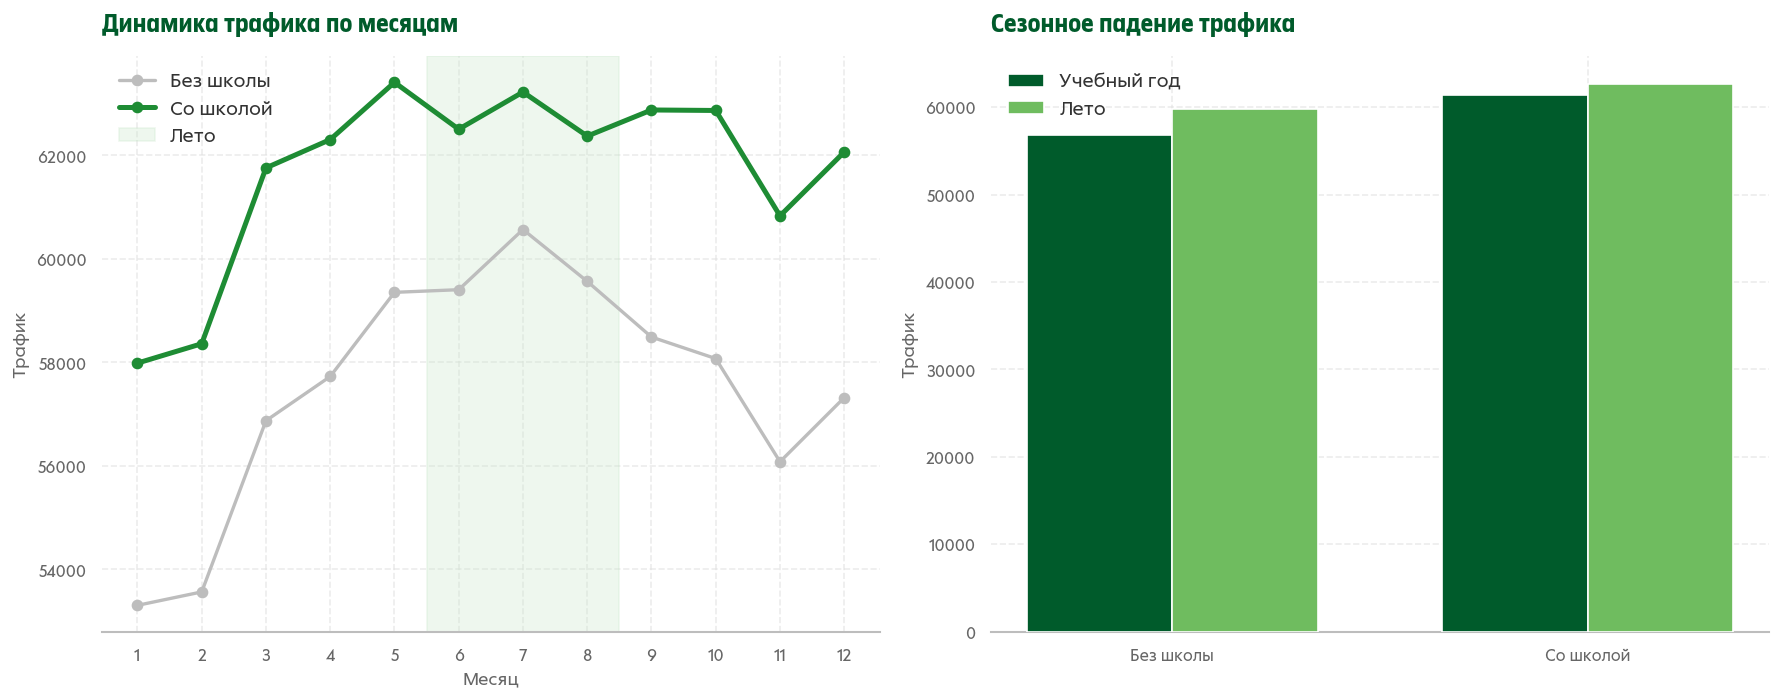

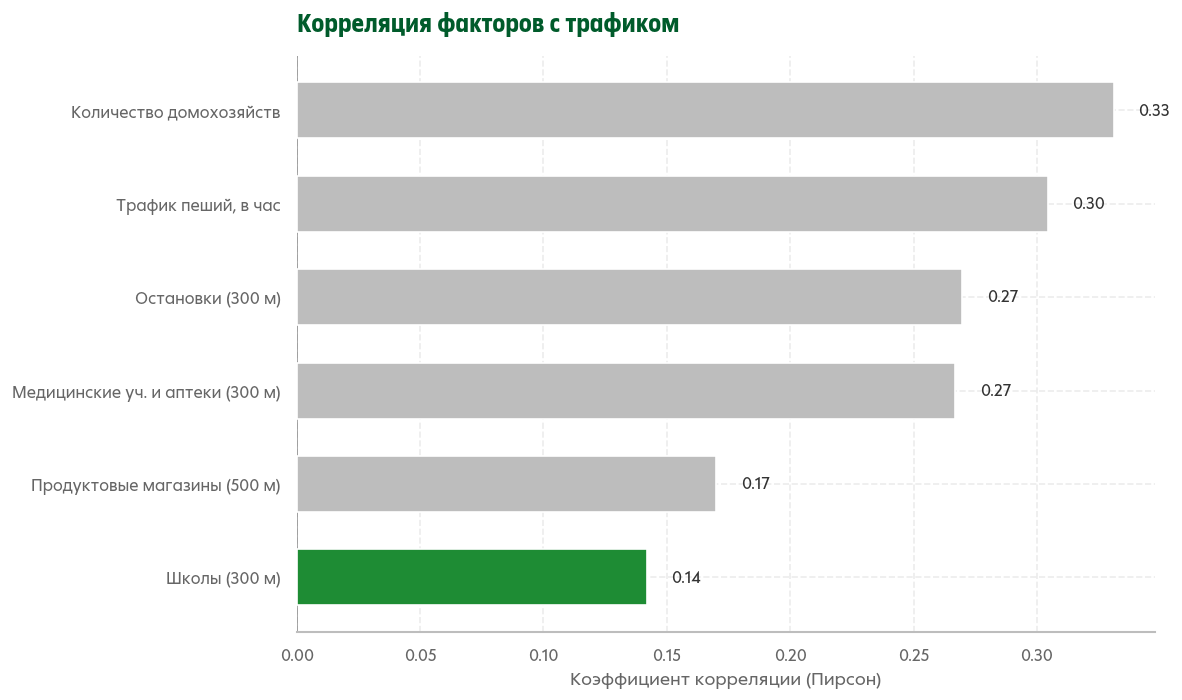

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats
import warnings

# Отключаем предупреждения для чистоты вывода
warnings.filterwarnings('ignore')

# ============================================================
# 1. НАСТРОЙКА ВИЗУАЛЬНОГО СТИЛЯ (ПЯТЁРОЧКА)
# ============================================================

# Пути к шрифтам (согласно твоему запросу)
FONT_PATH_TITLE = r'Design\OTF\5kaSansDesign-CondensedBold.otf'
FONT_PATH_REGULAR = r'Design\OTF\5kaSansDesign-Regular.otf'

# Попытка загрузить шрифты
try:
    prop_title = fm.FontProperties(fname=FONT_PATH_TITLE)
    prop_regular = fm.FontProperties(fname=FONT_PATH_REGULAR)
    # На всякий случай устанавливаем fallback, если путь неверный
    font_title_name = prop_title.get_name()
    font_regular_name = prop_regular.get_name()
except:
    print("Внимание: Файлы шрифтов не найдены по указанному пути. Используется шрифт по умолчанию.")
    prop_title = None
    prop_regular = None

# ЦВЕТОВАЯ ПАЛИТРА (4 оттенка зеленого, 4 оттенка серого)
# Зеленые (Brand Identity)
C_GREEN_MAIN  = '#1E8C34'  # Классический зеленый 5ка
C_GREEN_DARK  = '#005B2B'  # Темно-зеленый (для акцентов/текста)
C_GREEN_LIGHT = '#6FBC5F'  # Светло-зеленый (для позитива/лета)
C_GREEN_PALE  = '#C8E6C9'  # Бледный (для фона/слабых данных)

# Серые (Интерфейсные)
C_GRAY_TEXT   = '#333333'  # Основной текст
C_GRAY_SUB    = '#666666'  # Подписи осей
C_GRAY_BAR    = '#BDBDBD'  # Нейтральные бары
C_GRAY_GRID   = '#E0E0E0'  # Сетка

# Настройка глобальных параметров графиков
plt.rcParams['figure.facecolor'] = 'none' # Прозрачный фон фигуры
plt.rcParams['axes.facecolor'] = 'none'   # Прозрачный фон осей
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = C_GRAY_GRID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.6
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False # Убираем левую ось, оставляем только сетку
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.edgecolor'] = C_GRAY_BAR
plt.rcParams['text.color'] = C_GRAY_TEXT
plt.rcParams['xtick.color'] = C_GRAY_SUB
plt.rcParams['ytick.color'] = C_GRAY_SUB

def set_labels(ax, title, x_label, y_label):
    """Помощник для стилизации заголовков и осей"""
    ax.set_title(title, fontproperties=prop_title, fontsize=16, color=C_GREEN_DARK, loc='left', pad=15)
    ax.set_xlabel(x_label, fontproperties=prop_regular, fontsize=11, color=C_GRAY_SUB)
    ax.set_ylabel(y_label, fontproperties=prop_regular, fontsize=11, color=C_GRAY_SUB)
    # Стилизация тиков
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(prop_regular)
        label.set_fontsize(10)

# ============================================================
# 2. ПОДГОТОВКА ДАННЫХ (БЕЗ ИЗМЕНЕНИЙ ЛОГИКИ)
# ============================================================
# Предполагается, что переменная df уже загружена в память
# Если нет, раскомментируйте строку ниже для теста:
# df = pd.DataFrame(...) 

print("=" * 60)
print("АНАЛИЗ ДАННЫХ ДЛЯ ПРЕЗЕНТАЦИИ")
print("=" * 60)

# Определяем какие инфраструктурные колонки есть
potential_infra = {
    'Школы (300 м)': 'Школы',
    'Остановки (300 м)': 'Остановки',
    'Медицинские уч. и аптеки (300 м)': 'Мед. и аптеки',
    'Маркетплейсы, доставки, постаматы (100 м)': 'Маркетплейсы',
    'Продуктовые магазины (500 м)': 'Конкуренты',
    'Пятёрочки (500 м)': 'Другие Пятёрочки'
}

# Оставляем только существующие колонки
infra_cols = {k: v for k, v in potential_infra.items() if k in df.columns}

# Агрегация на уровне магазина (средние за год)
agg_dict = {
    'Трафик': 'mean',
    'Средний чек': 'mean',
    'Школы (300 м)': 'first',
}

# Добавляем только существующие колонки
for col in ['Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 
            'Маркетплейсы, доставки, постаматы (100 м)', 'Продуктовые магазины (500 м)',
            'Количество домохозяйств', 'Трафик пеший, в час']:
    if col in df.columns:
        agg_dict[col] = 'first'

store_df = df.groupby('new_id').agg(agg_dict).reset_index()

# ============================================================
# ГРАФИК 1: Охват магазинов (Стилизованный)
# ============================================================
if len(infra_cols) >= 2:
    presence = {label: (store_df[col] > 0).mean() * 100 for col, label in infra_cols.items() if col in store_df.columns}
    
    # Сортировка для красоты
    presence_sorted = dict(sorted(presence.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Цвета: Школы - Фирменный зеленый, остальные - Нейтральный серый
    colors = [C_GREEN_MAIN if k == 'Школы' else C_GRAY_BAR for k in presence_sorted.keys()]
    
    bars = plt.bar(presence_sorted.keys(), presence_sorted.values(), color=colors, width=0.6, zorder=3)
    
    set_labels(ax, 'Инфраструктура рядом с магазинами', '', 'Доля магазинов (%)')
    
    # Подписи значений
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', 
                fontproperties=prop_title, fontsize=11, color=C_GRAY_TEXT)
    
    plt.ylim(0, max(presence.values()) + 15)
    plt.tight_layout()
    plt.show()

# ============================================================
# ГРАФИК 2: Влияние количества школ (Градиент зеленого)
# ============================================================
store_df['Категория школ'] = store_df['Школы (300 м)'].apply(
    lambda x: '0 школ' if x == 0 else ('1 школа' if x == 1 else '2+ школы')
)

cat_counts = store_df['Категория школ'].value_counts()
order = ['0 школ', '1 школа', '2+ школы']
order = [o for o in order if o in cat_counts.index and cat_counts[o] >= 5]

if len(order) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Палитра: От серого (0) к светло-зеленому (1) и фирменному (2+)
    palette_schools = [C_GRAY_BAR, C_GREEN_LIGHT, C_GREEN_MAIN]
    # Если категорий меньше, обрезаем палитру
    palette_schools = palette_schools[:len(order)]

    # График Трафика
    sns.barplot(data=store_df, x='Категория школ', y='Трафик', order=order, 
                ax=axes[0], errorbar='ci', palette=palette_schools, saturation=0.9, zorder=3)
    set_labels(axes[0], 'Средний трафик', '', 'Человек в день')

    # График Чека
    sns.barplot(data=store_df, x='Категория школ', y='Средний чек', order=order,
                ax=axes[1], errorbar='ci', palette=palette_schools, saturation=0.9, zorder=3)
    set_labels(axes[1], 'Средний чек', '', 'Рублей')

    plt.tight_layout()
    plt.show()

# ============================================================
# ГРАФИК 3: Взаимодействие с пешим трафиком
# ============================================================
store_df['Есть школа'] = store_df['Школы (300 м)'] > 0

if 'Трафик пеший, в час' in store_df.columns and store_df['Трафик пеший, в час'].notna().sum() > 50:
    store_df['Пеший трафик (категория)'] = pd.qcut(
        store_df['Трафик пеший, в час'].dropna(), q=3, labels=['Низкий', 'Средний', 'Высокий']
    )
    
    cross_tab = pd.crosstab(store_df['Пеший трафик (категория)'], store_df['Есть школа'])
    
    if cross_tab.min().min() >= 10:
        plt.figure(figsize=(11, 6))
        ax = plt.gca()
        
        pivot = store_df.groupby(['Пеший трафик (категория)', 'Есть школа'])['Трафик'].mean().unstack()
        pivot.columns = ['Без школы', 'Со школой']
        
        x = np.arange(3)
        width = 0.35
        
        # Сравнение: Серый (нет) vs Зеленый (да)
        r1 = plt.bar(x - width/2, pivot['Без школы'], width, label='Без школы', color=C_GRAY_BAR, zorder=3)
        r2 = plt.bar(x + width/2, pivot['Со школой'], width, label='Со школой', color=C_GREEN_MAIN, zorder=3)
        
        set_labels(ax, 'Влияние школы при разном пешеходном трафике', 'Пешеходный трафик локации', 'Трафик магазина')
        ax.set_xticks(x)
        ax.set_xticklabels(['Низкий', 'Средний', 'Высокий'])
        
        # Легенда в стиле Пятерочки
        legend = plt.legend(frameon=True, facecolor='white', framealpha=0.9, edgecolor='none')
        for text in legend.get_texts():
            text.set_fontproperties(prop_regular)

        # Добавляем проценты прироста
        for i, (v1, v2) in enumerate(zip(pivot['Без школы'], pivot['Со школой'])):
            diff = (v2/v1 - 1) * 100
            ax.text(x[i] + width/2, v2 + 5, f'+{diff:.1f}%', ha='center', 
                   color=C_GREEN_DARK, fontproperties=prop_title, fontsize=10)

        plt.tight_layout()
        plt.show()

# ============================================================
# ГРАФИК 4: Сезонность (Зеленая линия vs Серая)
# ============================================================
df['Есть школа'] = df['Школы (300 м)'] > 0
df['Период'] = df['Месяц'].apply(lambda x: 'Лето' if x in [6, 7, 8] else 'Учебный год')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 4.1 Линейный график
monthly = df.groupby(['Месяц', 'Есть школа'])['Трафик'].mean().unstack()
monthly.columns = ['Без школы', 'Со школой']

# Линии: Серая и Зеленая
axes[0].plot(monthly.index, monthly['Без школы'], marker='o', color=C_GRAY_BAR, linewidth=2, label='Без школы')
axes[0].plot(monthly.index, monthly['Со школой'], marker='o', color=C_GREEN_MAIN, linewidth=3, label='Со школой')

# Подсветка лета (Бледно-зеленый фон вместо желтого)
axes[0].axvspan(5.5, 8.5, color=C_GREEN_PALE, alpha=0.3, label='Лето')

set_labels(axes[0], 'Динамика трафика по месяцам', 'Месяц', 'Трафик')
axes[0].set_xticks(range(1, 13))

legend = axes[0].legend(frameon=False)
for text in legend.get_texts():
    text.set_fontproperties(prop_regular)

# 4.2 Столбчатый график периодов
period_data = df.groupby(['Есть школа', 'Период'])['Трафик'].mean().unstack()
# Переупорядочим для логики
period_data = period_data[['Учебный год', 'Лето']]
period_data.index = ['Без школы', 'Со школой']

x = np.arange(len(period_data.index))
width = 0.35

# Цвета: Учебный год - Темный зеленый, Лето - Светлый зеленый
axes[1].bar(x - width/2, period_data['Учебный год'], width, label='Учебный год', color=C_GREEN_DARK, zorder=3)
axes[1].bar(x + width/2, period_data['Лето'], width, label='Лето', color=C_GREEN_LIGHT, zorder=3)

set_labels(axes[1], 'Сезонное падение трафика', '', 'Трафик')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Без школы', 'Со школой'])

legend = axes[1].legend(frameon=False)
for text in legend.get_texts():
    text.set_fontproperties(prop_regular)

plt.tight_layout()
plt.show()

# ============================================================
# ГРАФИК 5: Корреляции (Горизонтальный бар)
# ============================================================
corr_cols = ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)',
             'Продуктовые магазины (500 м)', 'Количество домохозяйств', 'Трафик пеший, в час']
corr_cols = [c for c in corr_cols if c in store_df.columns]

if len(corr_cols) >= 3:
    correlations = {col: store_df[col].corr(store_df['Трафик']) for col in corr_cols}
    # Сортируем
    correlations = dict(sorted(correlations.items(), key=lambda item: item[1]))
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Цвета: Школы - Зеленый, Остальное - Серый
    colors = [C_GREEN_MAIN if 'Школы' in k else C_GRAY_BAR for k in correlations.keys()]
    
    bars = plt.barh(list(correlations.keys()), list(correlations.values()), color=colors, height=0.6, zorder=3)
    
    set_labels(ax, 'Корреляция факторов с трафиком', 'Коэффициент корреляции (Пирсон)', '')
    
    # Линия нуля
    plt.axvline(x=0, color=C_GRAY_TEXT, linestyle='-', linewidth=1, alpha=0.5)
    
    # Подписи значений
    for i, v in enumerate(correlations.values()):
        offset = 0.01 if v >= 0 else -0.05
        ax.text(v + offset, i, f'{v:.2f}', va='center', 
                fontproperties=prop_regular, fontsize=10, color=C_GRAY_TEXT)
    
    plt.tight_layout()
    plt.show()

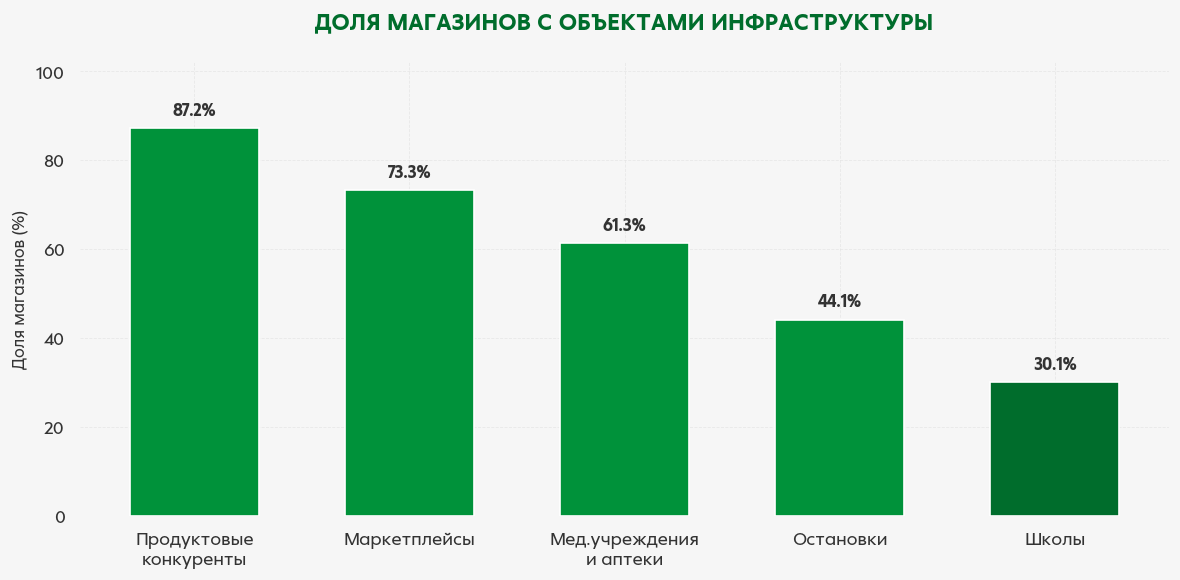

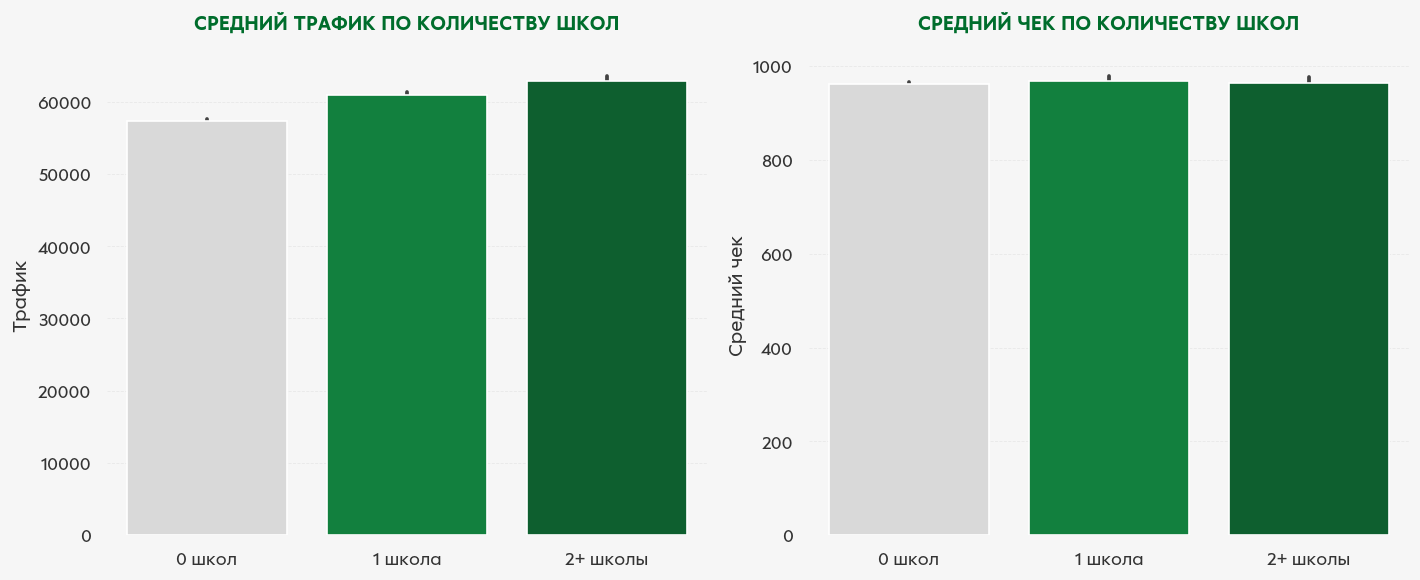

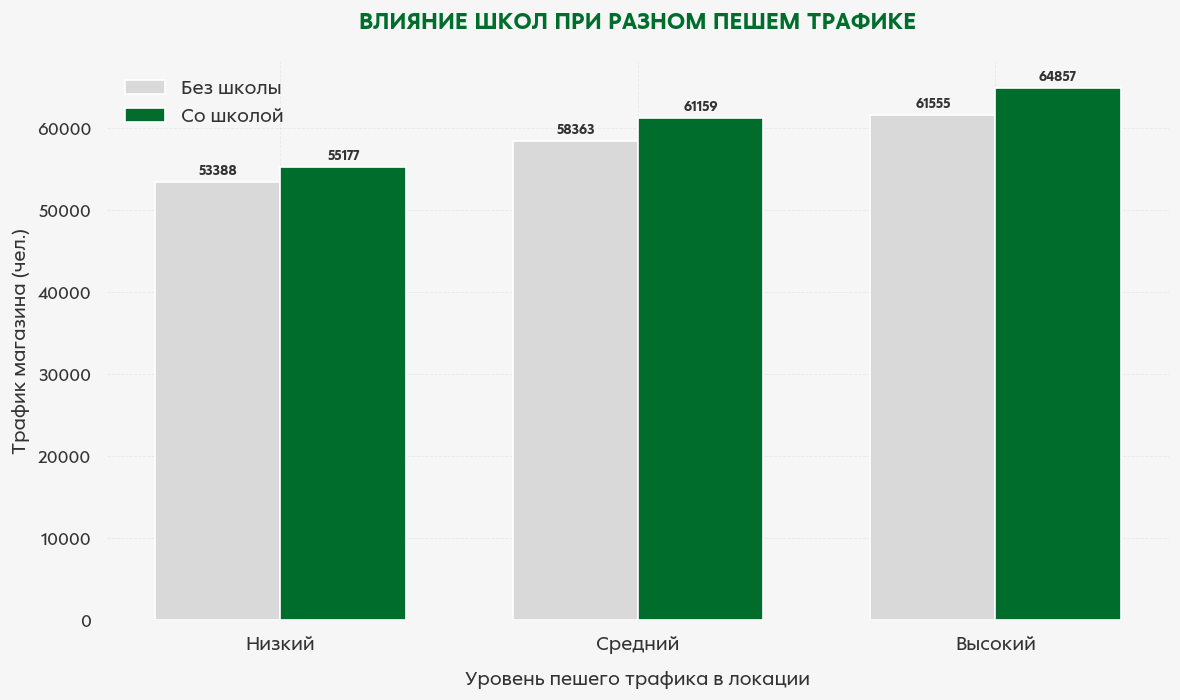

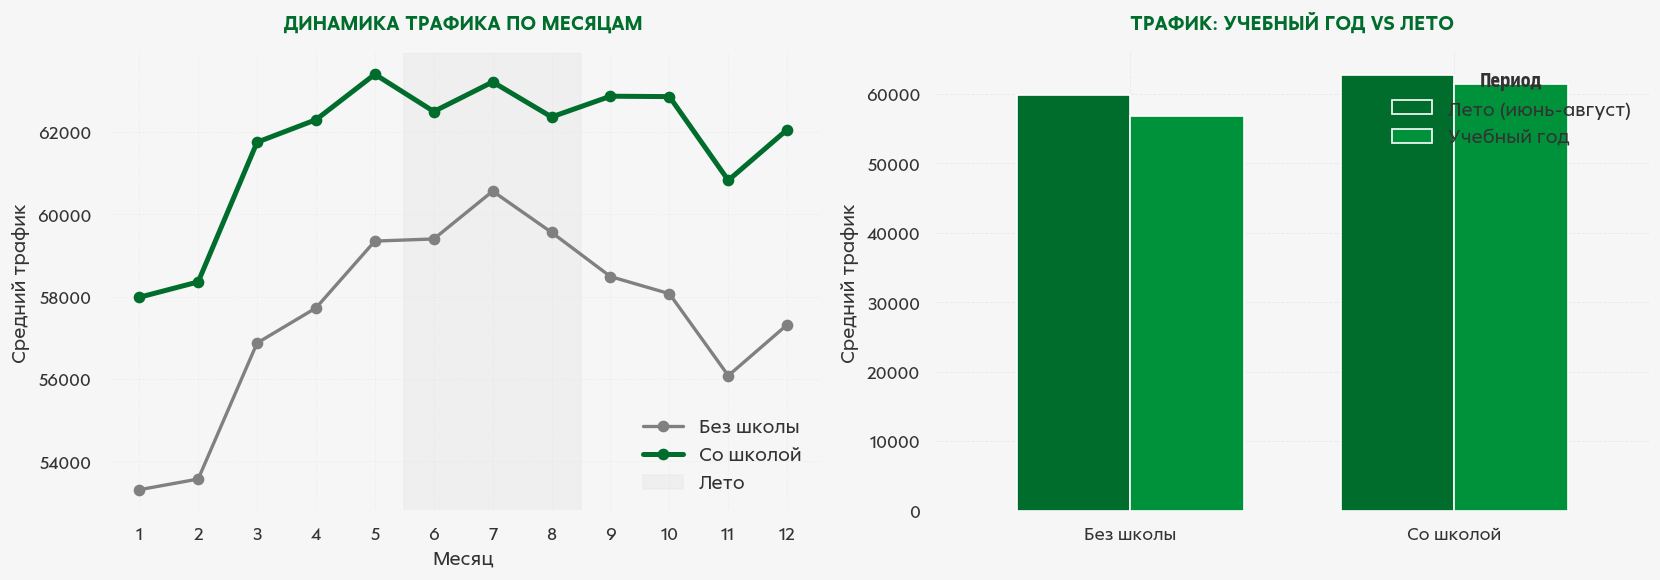

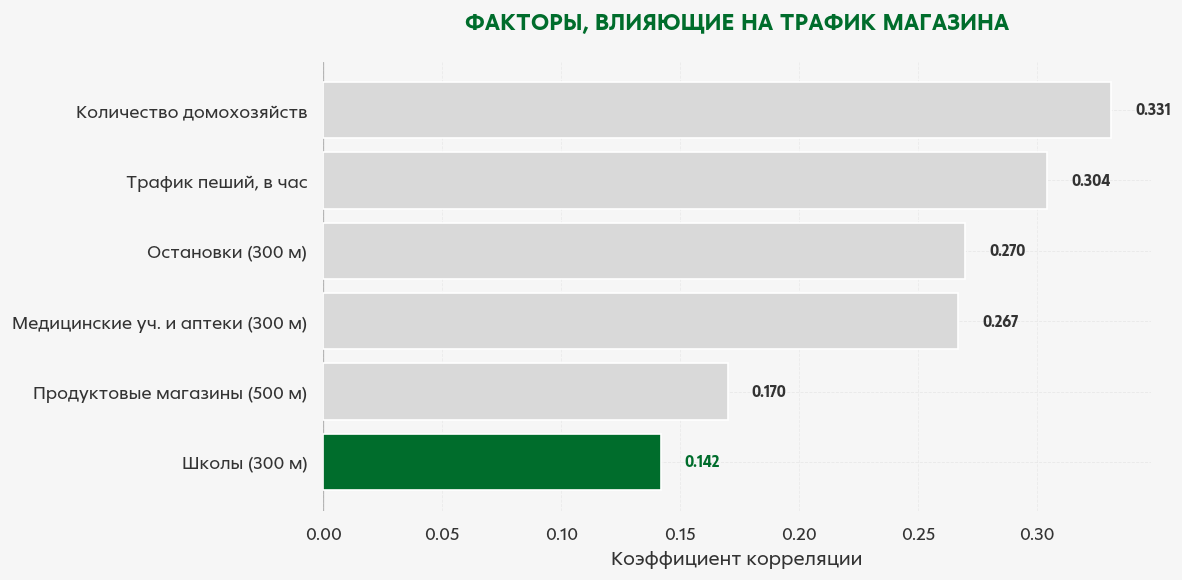

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.font_manager as fm
import os

# ============================================================
# НАСТРОЙКИ ДИЗАЙНА (ПЯТЁРОЧКА)
# ============================================================

# Цвета
C_BG = '#f6f6f6'       # Фон слайда
C_WHITE = '#ffffff'    # Белый
C_GREEN_DARK = '#006d2c'  # Темно-зеленый (основной)
C_GREEN_LIGHT = '#00923a' # Светло-зеленый (дополнительный)
C_GRAY = '#808080'     # Серый для второстепенных элементов
C_GRAY_LIGHT = '#d9d9d9' # Светло-серый для неактивных элементов
C_TEXT = '#333333'     # Темно-серый для текста

# Шрифты
font_dirs = ['Design/OTF', 'Design\\OTF']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Пытаемся установить фирменные шрифты, иначе дефолтный sans-serif
try:
    title_font = fm.FontProperties(fname='Design/OTF/5kaSansDesign-Black.otf')
    body_font = fm.FontProperties(fname='Design/OTF/5kaSansDesign-Regular.otf')
    label_font = fm.FontProperties(fname='Design/OTF/5kaSansDesign-CondensedBold.otf')
except:
    title_font = fm.FontProperties(family='sans-serif', weight='bold')
    body_font = fm.FontProperties(family='sans-serif')
    label_font = fm.FontProperties(family='sans-serif', weight='bold')

# Глобальные настройки графиков
plt.rcParams.update({
    'figure.facecolor': C_BG,
    'axes.facecolor': C_BG,
    'axes.edgecolor': C_BG,
    'axes.labelcolor': C_TEXT,
    'xtick.color': C_TEXT,
    'ytick.color': C_TEXT,
    'text.color': C_TEXT,
    'font.family': body_font.get_name(),
    'grid.color': '#e0e0e0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5
})

# ============================================================
# ОБРАБОТКА ДАННЫХ (ИЗ ВАШЕГО СКРИПТА)
# ============================================================

# Определяем какие инфраструктурные колонки есть
potential_infra = {
    'Школы (300 м)': 'Школы',
    'Остановки (300 м)': 'Остановки',
    'Медицинские уч. и аптеки (300 м)': 'Мед.учреждения\nи аптеки',
    'Маркетплейсы, доставки, постаматы (100 м)': 'Маркетплейсы',
    'Продуктовые магазины (500 м)': 'Продуктовые\nконкуренты',
    'Пятёрочки (500 м)': 'Другие\nПятёрочки'
}

# Оставляем только существующие колонки
infra_cols = {k: v for k, v in potential_infra.items() if k in df.columns}

# Агрегация на уровне магазина (средние за год)
agg_dict = {
    'Трафик': 'mean',
    'Средний чек': 'mean',
    'Школы (300 м)': 'first',
}

for col in ['Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 
            'Маркетплейсы, доставки, постаматы (100 м)', 'Продуктовые магазины (500 м)',
            'Количество домохозяйств', 'Трафик пеший, в час']:
    if col in df.columns:
        agg_dict[col] = 'first'

store_df = df.groupby('new_id').agg(agg_dict).reset_index()

# ============================================================
# ГРАФИК 1: Охват магазинов объектами инфраструктуры
# ============================================================
if len(infra_cols) >= 2:
    presence = {label: (store_df[col] > 0).mean() * 100 for col, label in infra_cols.items() if col in store_df.columns}
    
    # Сортировка для красоты
    presence = dict(sorted(presence.items(), key=lambda item: item[1], reverse=True))

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Цвета: Школы - темно-зеленый, Остальные - светло-зеленый
    colors = [C_GREEN_DARK if k == 'Школы' else C_GREEN_LIGHT for k in presence.keys()]
    
    bars = ax.bar(presence.keys(), presence.values(), color=colors, zorder=3, width=0.6)
    
    ax.set_ylabel('Доля магазинов (%)', fontproperties=body_font, fontsize=10)
    ax.set_title('ДОЛЯ МАГАЗИНОВ С ОБЪЕКТАМИ ИНФРАСТРУКТУРЫ', fontproperties=title_font, fontsize=14, pad=20, color=C_GREEN_DARK)
    
    # Убираем лишние рамки
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', zorder=0)
    
    # Подписи значений
    for i, v in enumerate(presence.values()):
        ax.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontproperties=label_font, fontsize=11, color=C_TEXT)
    
    ax.set_ylim(0, max(presence.values()) + 15)
    plt.tight_layout()
    plt.show()

# ============================================================
# ГРАФИК 2: Нелинейность влияния школ
# ============================================================
store_df['Категория школ'] = store_df['Школы (300 м)'].apply(
    lambda x: '0 школ' if x == 0 else ('1 школа' if x == 1 else '2+ школы')
)

cat_counts = store_df['Категория школ'].value_counts()
order = ['0 школ', '1 школа', '2+ школы']
order = [o for o in order if o in cat_counts.index and cat_counts[o] >= 5]

# Палитра: Серый -> Светло-зеленый -> Темно-зеленый
custom_palette = [C_GRAY_LIGHT, C_GREEN_LIGHT, C_GREEN_DARK]
if len(order) < 3:
    custom_palette = custom_palette[:len(order)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (col, title) in enumerate([('Трафик', 'СРЕДНИЙ ТРАФИК'), ('Средний чек', 'СРЕДНИЙ ЧЕК')]):
    sns.barplot(data=store_df, x='Категория школ', y=col, order=order, 
                ax=axes[idx], errorbar='ci', palette=custom_palette, zorder=3)
    
    axes[idx].set_title(f'{title} ПО КОЛИЧЕСТВУ ШКОЛ', fontproperties=title_font, fontsize=12, pad=15, color=C_GREEN_DARK)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel(col, fontproperties=body_font)
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['left'].set_visible(False)
    axes[idx].grid(axis='y', zorder=0)

plt.tight_layout()
plt.show()

# ============================================================
# ГРАФИК 3: Взаимодействие школ с пешим трафиком
# ============================================================
store_df['Есть школа'] = store_df['Школы (300 м)'] > 0

if 'Трафик пеший, в час' in store_df.columns and store_df['Трафик пеший, в час'].notna().sum() > 50:
    store_df['Пеший трафик (категория)'] = pd.qcut(
        store_df['Трафик пеший, в час'].dropna(), q=3, labels=['Низкий', 'Средний', 'Высокий']
    )
    
    cross_tab = pd.crosstab(store_df['Пеший трафик (категория)'], store_df['Есть школа'])
    
    if cross_tab.min().min() >= 10:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        pivot = store_df.groupby(['Пеший трафик (категория)', 'Есть школа'])['Трафик'].mean().unstack()
        pivot.columns = ['Без школы', 'Со школой']
        
        x = np.arange(3)
        width = 0.35
        
        # Цвета: Серый (нет школы) vs Темно-зеленый (есть школа)
        rects1 = ax.bar(x - width/2, pivot['Без школы'], width, label='Без школы', color=C_GRAY_LIGHT, zorder=3)
        rects2 = ax.bar(x + width/2, pivot['Со школой'], width, label='Со школой', color=C_GREEN_DARK, zorder=3)
        
        ax.set_ylabel('Трафик магазина (чел.)', fontproperties=body_font)
        ax.set_xlabel('Уровень пешего трафика в локации', fontproperties=body_font, labelpad=10)
        ax.set_title('ВЛИЯНИЕ ШКОЛ ПРИ РАЗНОМ ПЕШЕМ ТРАФИКЕ', fontproperties=title_font, fontsize=14, pad=20, color=C_GREEN_DARK)
        ax.set_xticks(x)
        ax.set_xticklabels(['Низкий', 'Средний', 'Высокий'], fontproperties=body_font)
        
        ax.legend(frameon=False, prop=body_font)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', zorder=0)
        
        # Добавляем значения над барами
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{int(height)}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3), 
                            textcoords="offset points",
                            ha='center', va='bottom', fontproperties=label_font, fontsize=9, color=C_TEXT)
        
        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

# ============================================================
# ГРАФИК 4: Сезонный эффект
# ============================================================
df['Есть школа'] = df['Школы (300 м)'] > 0
df['Период'] = df['Месяц'].apply(lambda x: 'Лето (июнь-август)' if x in [6, 7, 8] else 'Учебный год')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Линейный график
monthly = df.groupby(['Месяц', 'Есть школа'])['Трафик'].mean().unstack()
monthly.columns = ['Без школы', 'Со школой']

# Цвета линий: Серый (нет школы) и Темно-зеленый (есть школа)
axes[0].plot(monthly.index, monthly['Без школы'], marker='o', color=C_GRAY, linewidth=2, label='Без школы')
axes[0].plot(monthly.index, monthly['Со школой'], marker='o', color=C_GREEN_DARK, linewidth=3, label='Со школой')

# Подсветка лета - очень светло-серый прямоугольник
axes[0].axvspan(5.5, 8.5, alpha=0.3, color='#e0e0e0', label='Лето')

axes[0].set_xlabel('Месяц', fontproperties=body_font)
axes[0].set_ylabel('Средний трафик', fontproperties=body_font)
axes[0].set_title('ДИНАМИКА ТРАФИКА ПО МЕСЯЦАМ', fontproperties=title_font, fontsize=12, pad=15, color=C_GREEN_DARK)
axes[0].set_xticks(range(1, 13))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True, linestyle=':', alpha=0.6)
axes[0].legend(frameon=False, prop=body_font)

# Бар чарт по периодам
period_data = df.groupby(['Есть школа', 'Период'])['Трафик'].mean().unstack()
period_data.index = ['Без школы', 'Со школой']

# Цвета: Учебный год - Темно-зеленый, Лето - Светло-зеленый
period_data.plot(kind='bar', ax=axes[1], color=[C_GREEN_DARK, C_GREEN_LIGHT], zorder=3, width=0.7)

axes[1].set_xlabel('')
axes[1].set_ylabel('Средний трафик', fontproperties=body_font)
axes[1].set_title('ТРАФИК: УЧЕБНЫЙ ГОД VS ЛЕТО', fontproperties=title_font, fontsize=12, pad=15, color=C_GREEN_DARK)
axes[1].legend(title='Период', frameon=False, title_fontproperties=label_font, prop=body_font)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].grid(axis='y', zorder=0)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# ============================================================
# ГРАФИК 5: Корреляции
# ============================================================
corr_cols = ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)',
             'Продуктовые магазины (500 м)', 'Количество домохозяйств', 'Трафик пеший, в час']
corr_cols = [c for c in corr_cols if c in store_df.columns]

if len(corr_cols) >= 3:
    correlations = {col: store_df[col].corr(store_df['Трафик']) for col in corr_cols}
    # Сортировка по убыванию модуля корреляции
    correlations = dict(sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=False))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Цвета: Школы - Темно-зеленый, Остальные - Серый
    colors = [C_GREEN_DARK if 'Школы' in k else C_GRAY_LIGHT for k in correlations.keys()]
    
    bars = ax.barh(list(correlations.keys()), list(correlations.values()), color=colors, zorder=3)
    
    ax.set_xlabel('Коэффициент корреляции', fontproperties=body_font)
    ax.set_title('ФАКТОРЫ, ВЛИЯЮЩИЕ НА ТРАФИК МАГАЗИНА', fontproperties=title_font, fontsize=14, pad=20, color=C_GREEN_DARK)
    
    ax.axvline(x=0, color=C_TEXT, linestyle='-', linewidth=0.8, alpha=0.3)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', zorder=0, alpha=0.5)
    
    # Подписи значений
    for i, v in enumerate(correlations.values()):
        offset = 0.01 if v >= 0 else -0.01
        ha_align = 'left' if v >= 0 else 'right'
        ax.text(v + offset, i, f'{v:.3f}', va='center', ha=ha_align, 
                fontproperties=label_font, fontsize=10, color=C_GREEN_DARK if 'Школы' in list(correlations.keys())[i] else C_TEXT)
    
    plt.tight_layout()
    plt.show()

9

ПОИСК ОБОСНОВАНИЯ ДЛЯ ИССЛЕДОВАНИЯ ШКОЛ

>>> ИДЕЯ 1: Школы как маркер жилого района


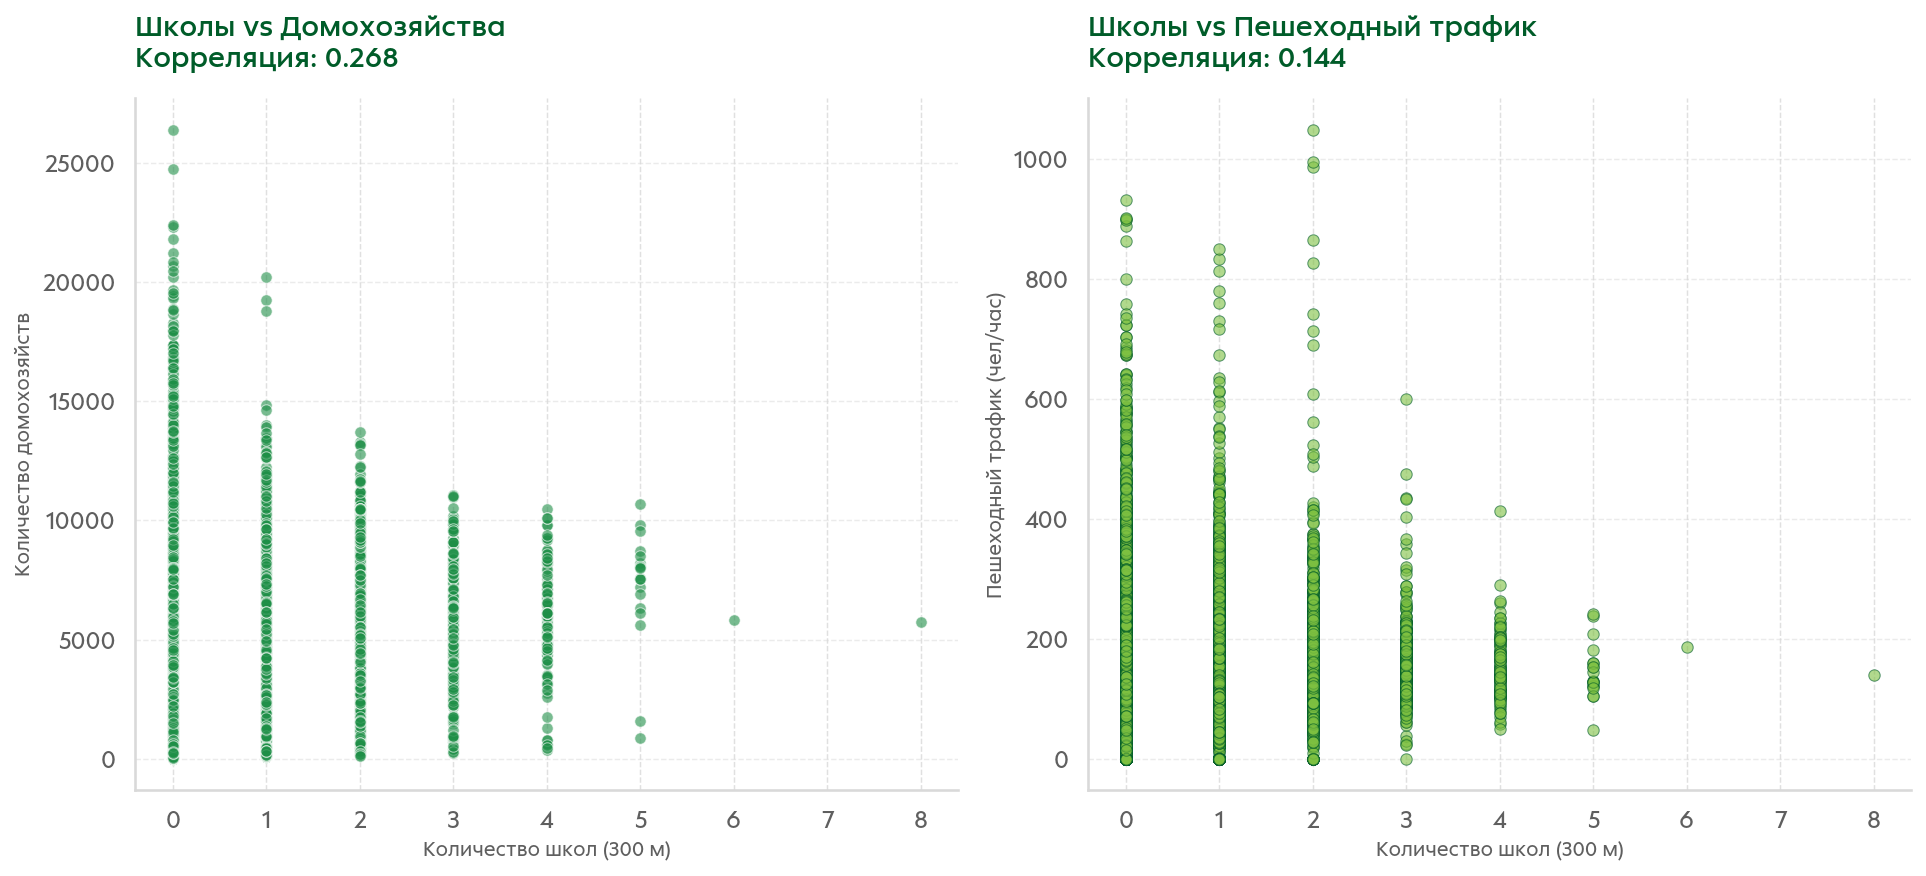


>>> ИДЕЯ 2: Эффект школ в учебное время vs каникулы


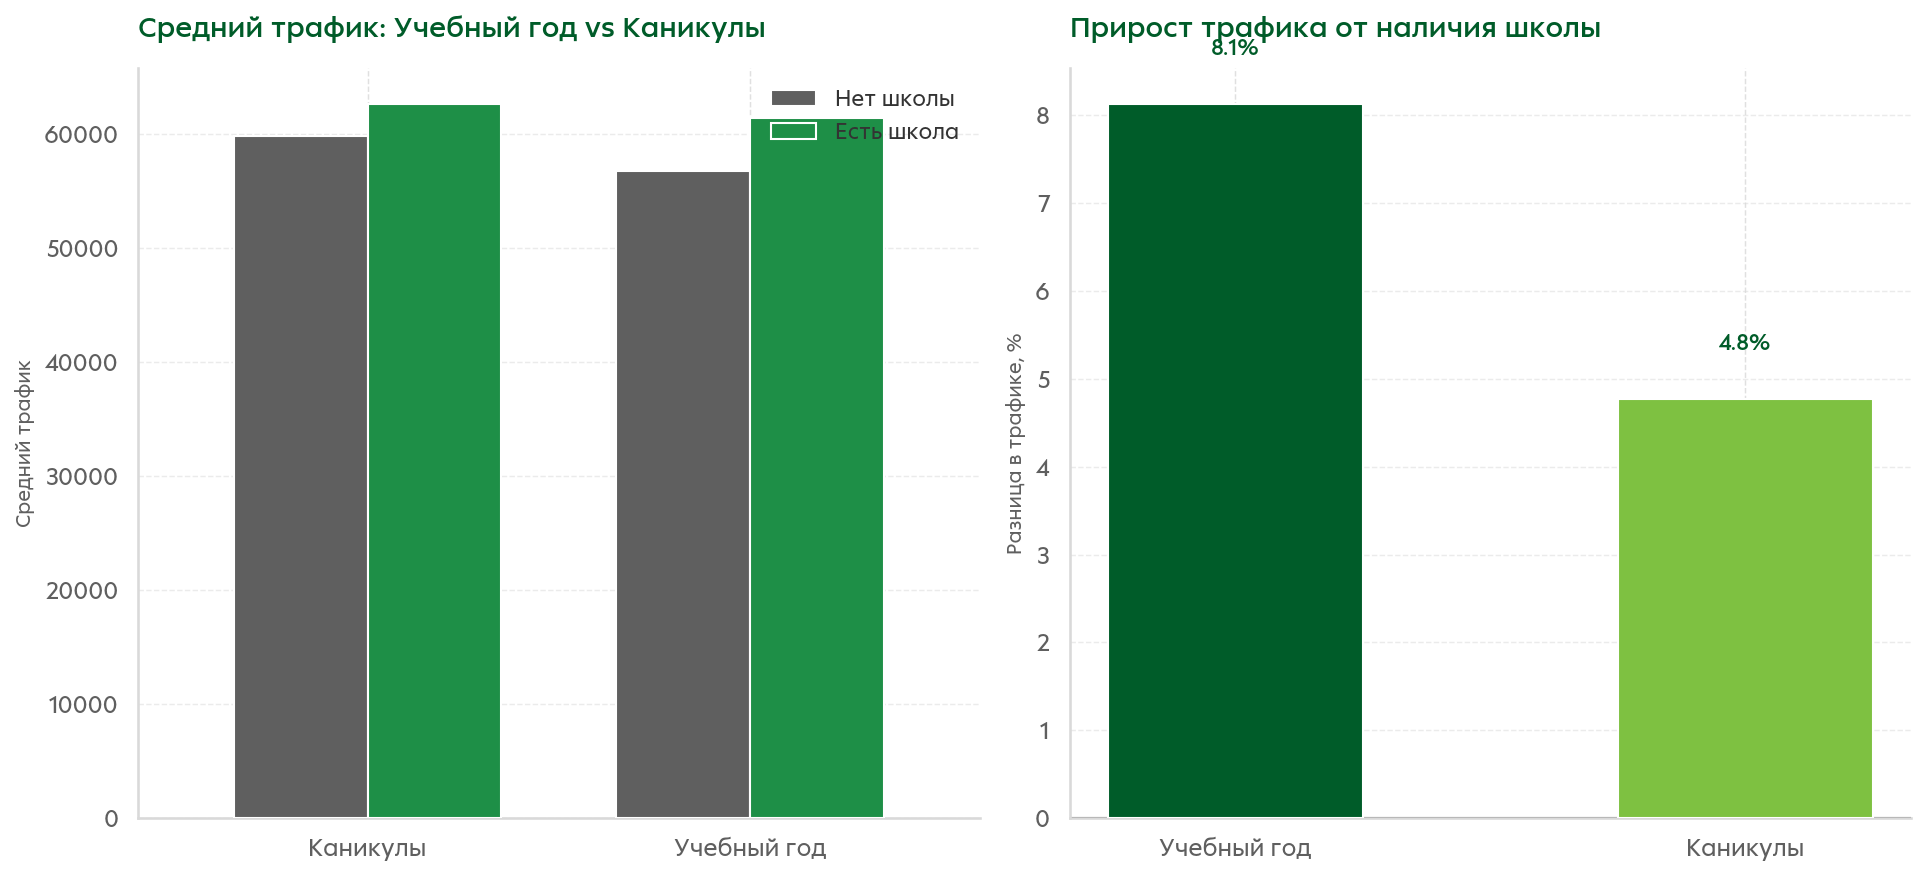


>>> ИДЕЯ 3: География - доля магазинов рядом со школами


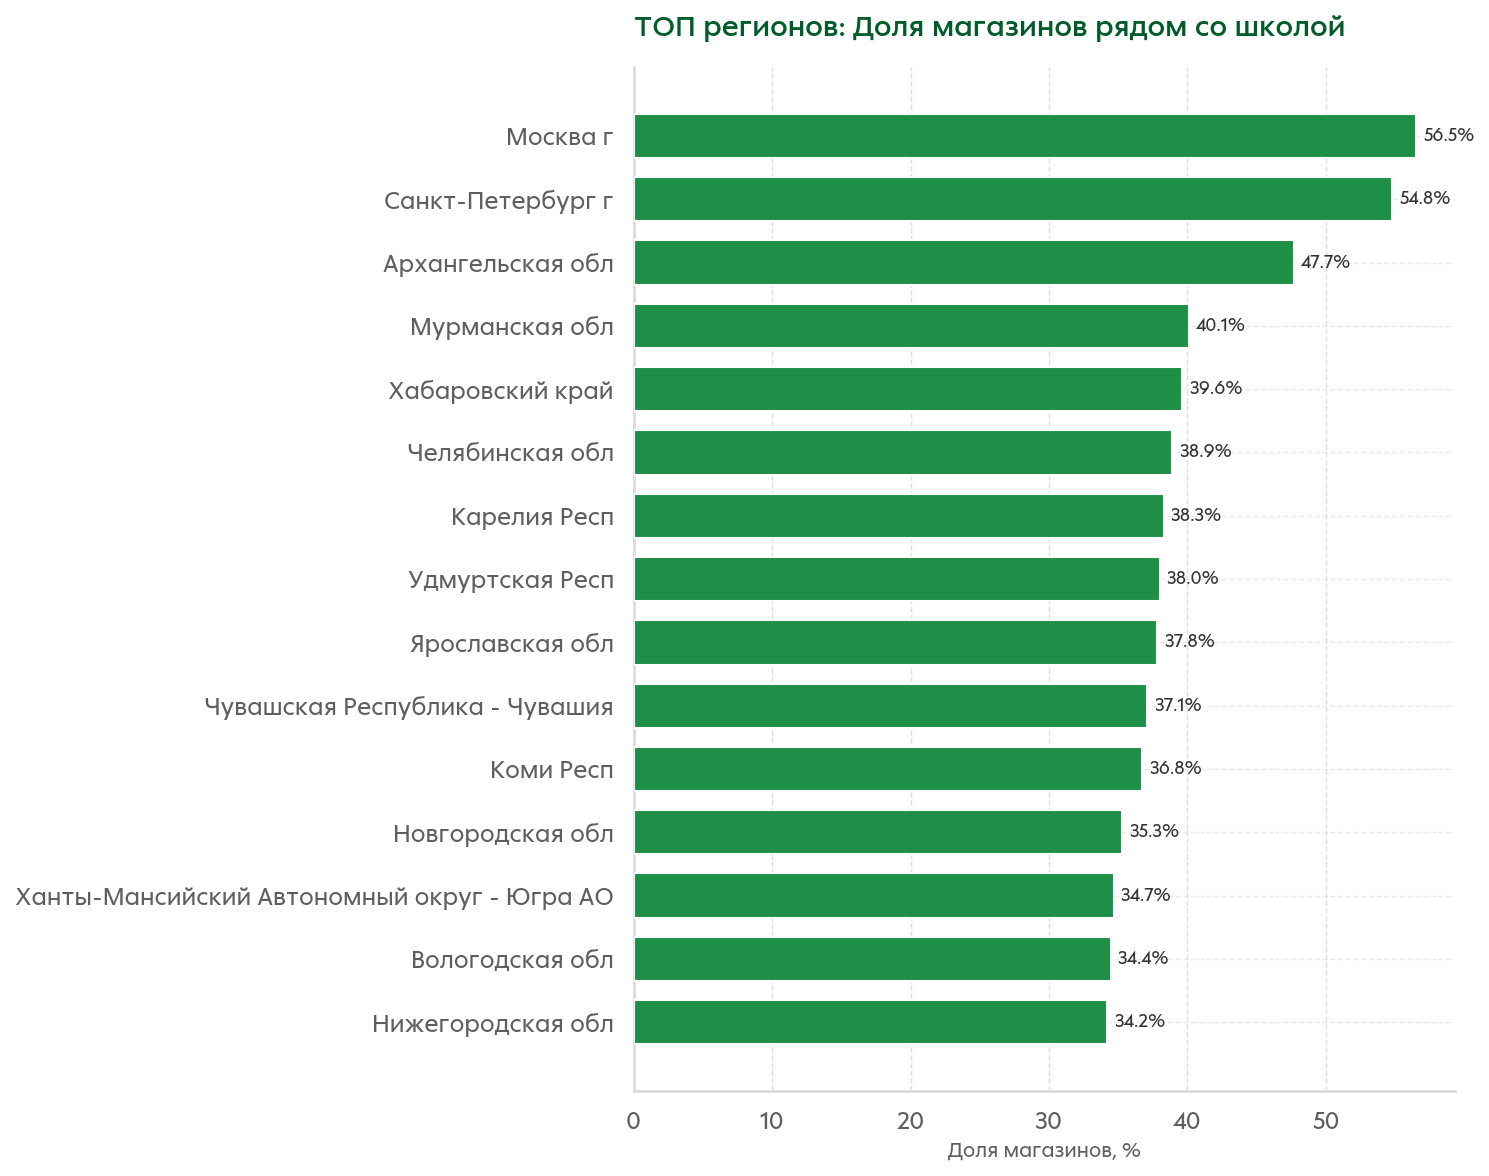


>>> ИДЕЯ 4: Уникальность школ vs другие объекты


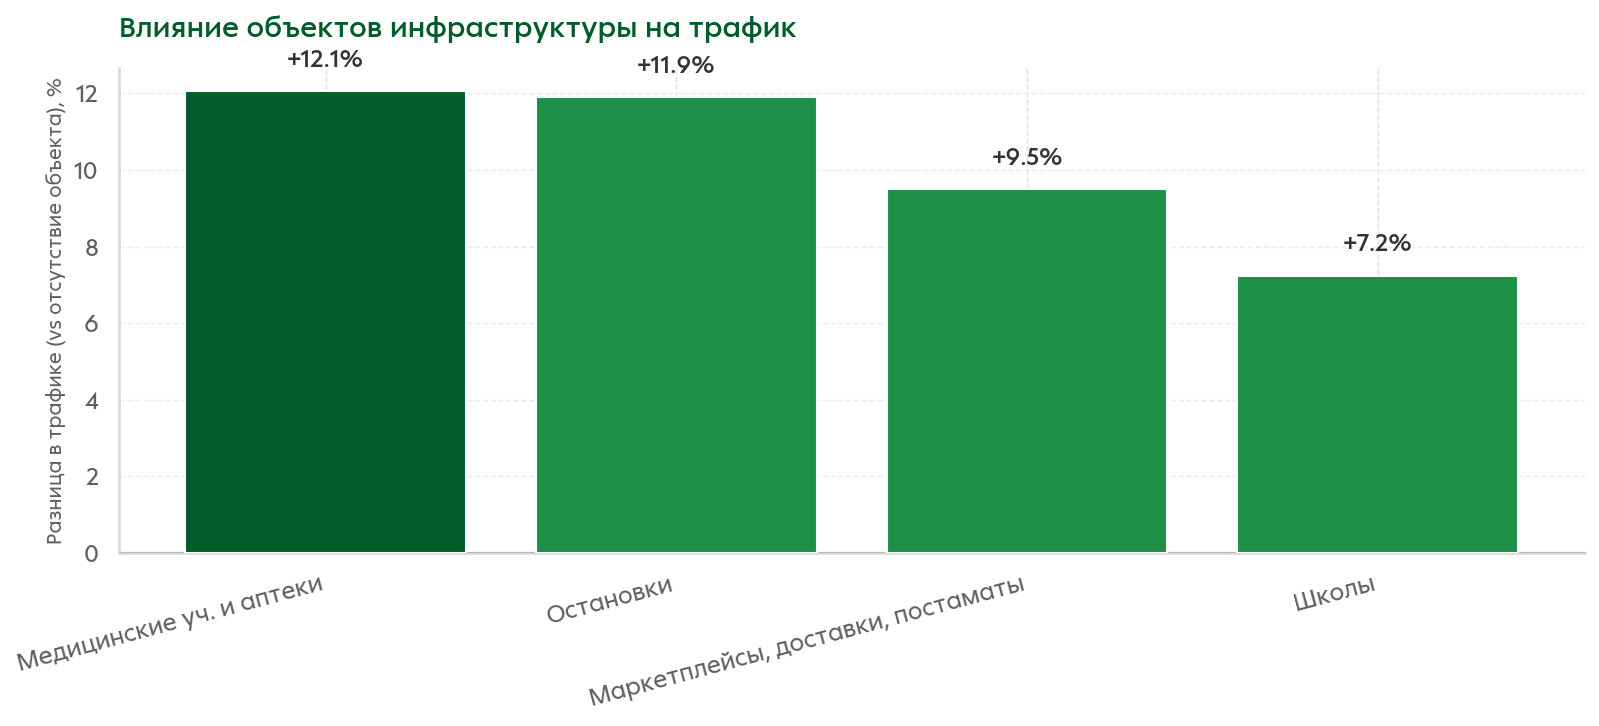


>>> ИДЕЯ 5: Связь школ с характеристиками магазина


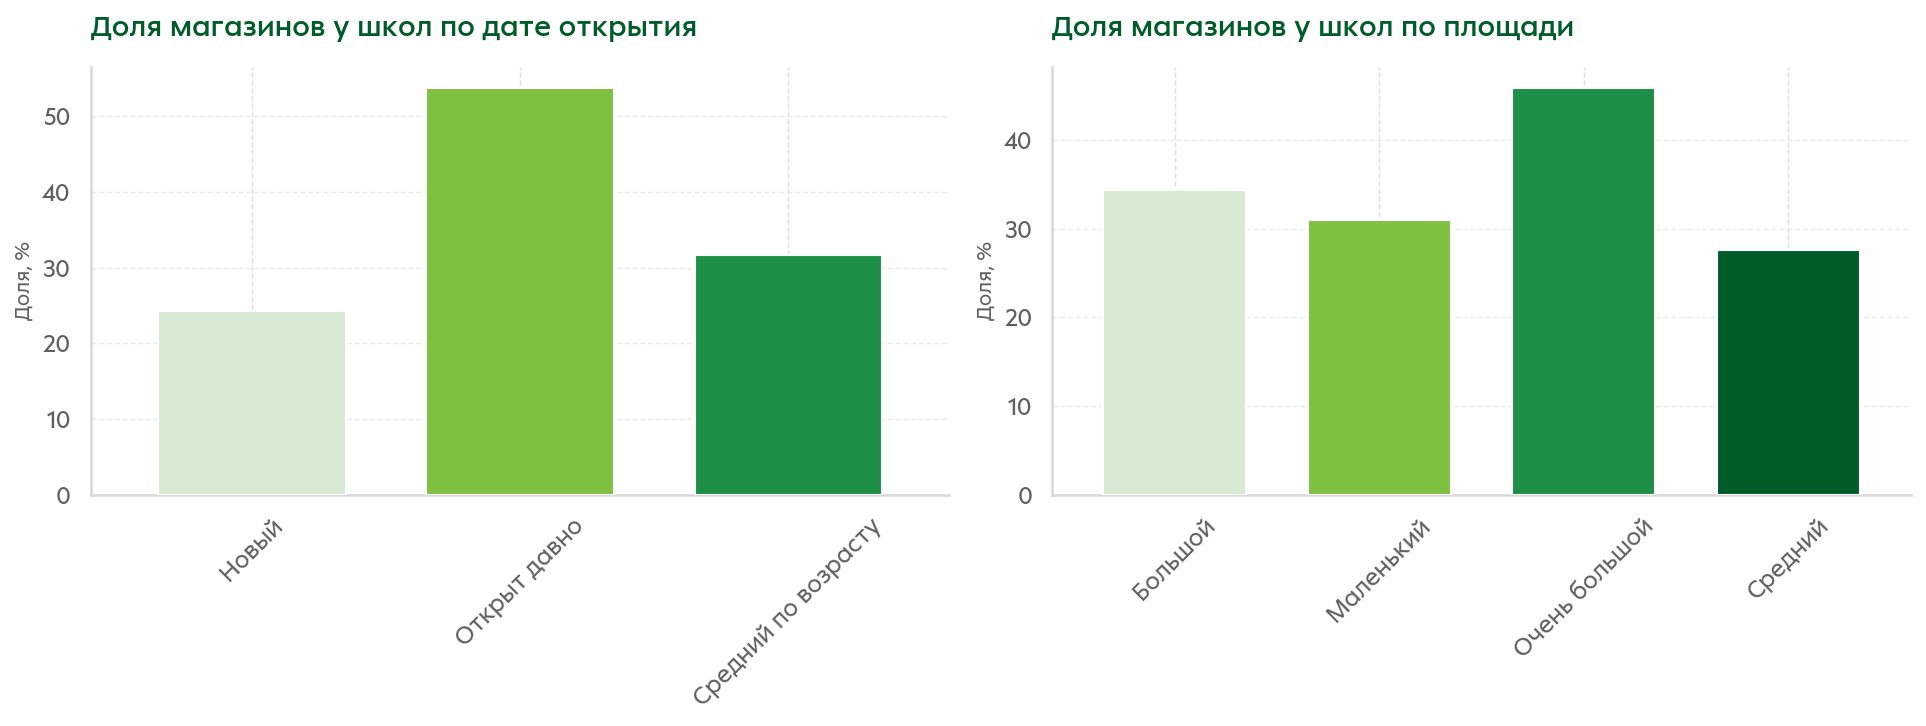


>>> ИДЕЯ 6: Помесячная динамика эффекта школ


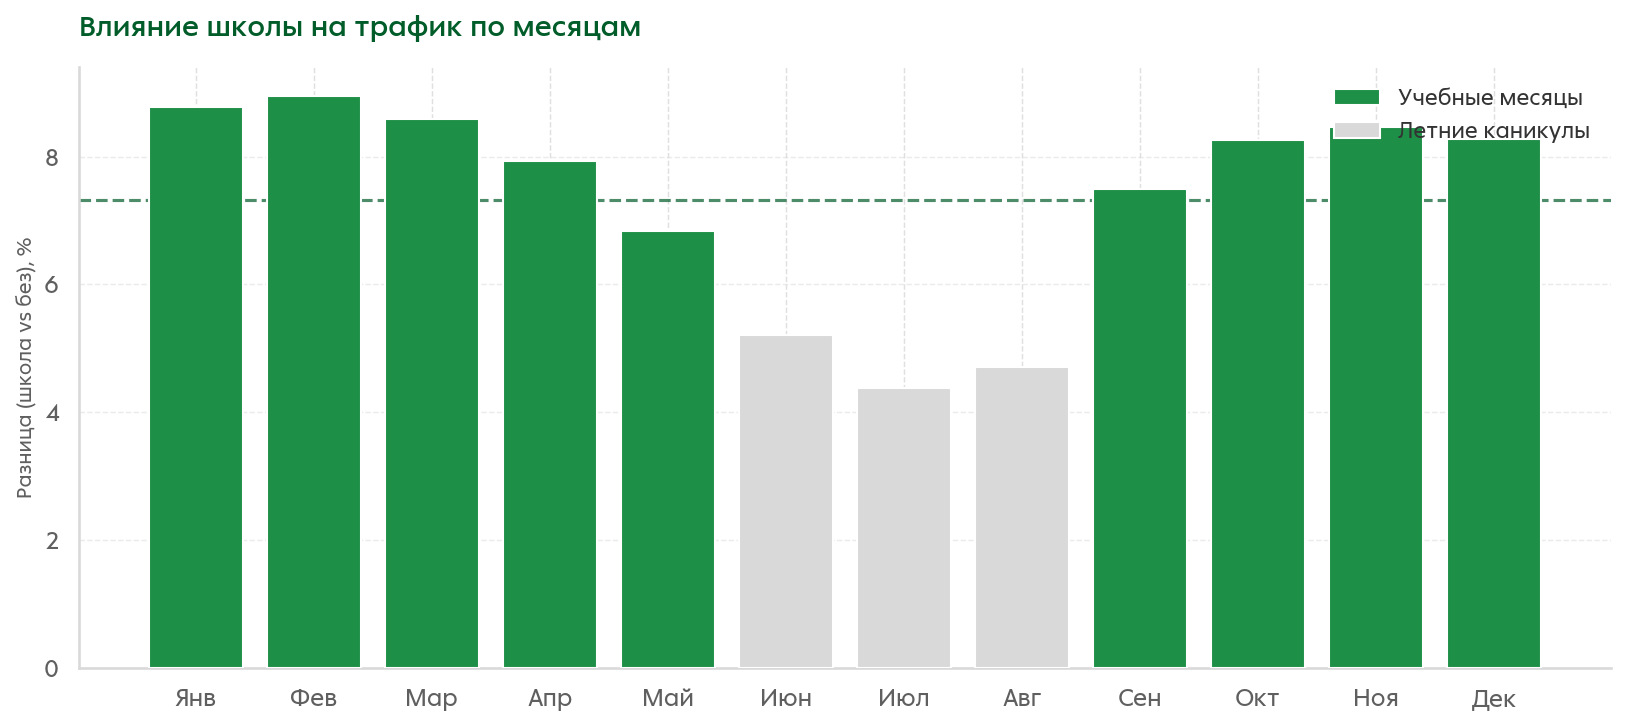

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# ==========================================
# 1. НАСТРОЙКИ ДИЗАЙНА (ПЯТЁРОЧКА STYLE)
# ==========================================

# Пути к шрифтам (используем основные начертания)
font_path_reg = r'Design\OTF\5kaSansDesign-Regular.otf'
font_path_bold = r'Design\OTF\5kaSansDesign-SemiBold.otf'

# Попытка загрузить шрифты для использования
try:
    prop_reg = fm.FontProperties(fname=font_path_reg)
    prop_bold = fm.FontProperties(fname=font_path_bold)
    font_available = True
except:
    print("Файлы шрифтов не найдены. Будет использован стандартный шрифт.")
    font_available = False
    prop_reg = None
    prop_bold = None

# ПАЛИТРА "ПЯТЁРОЧКА" (4 оттенка зеленого + серые)
C_GREEN_MAIN = '#1E8F47'   # Основной бренд-цвет
C_GREEN_DARK = '#005C29'   # Темный (для текста или акцентов)
C_GREEN_LIGHT = '#7EC141'  # Светлый (свежесть, листья)
C_GREEN_PALE = '#D8EAD3'   # Бледный (для фона или неактивных элементов)

C_GRAY_TEXT = '#333333'    # Основной текст
C_GRAY_SUB = '#5F5F5F'     # Второстепенный текст
C_GRAY_LINES = '#D9D9D9'   # Линии сетки
C_GRAY_BG = '#F4F4F4'      # Подложка (если нужна)

# Глобальные настройки
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.edgecolor'] = C_GRAY_LINES
plt.rcParams['xtick.color'] = C_GRAY_SUB
plt.rcParams['ytick.color'] = C_GRAY_SUB
plt.rcParams['text.color'] = C_GRAY_TEXT

def apply_5ka_style(ax, title='', xlabel='', ylabel=''):
    """Применяет фирменный стиль к осям"""
    # Убираем лишние рамки (сверху и справа)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(C_GRAY_LINES)
    ax.spines['bottom'].set_color(C_GRAY_LINES)
    
    # Сетка
    ax.grid(axis='y', linestyle='--', alpha=0.5, color=C_GRAY_LINES, zorder=0)
    
    # Тексты
    if font_available:
        ax.set_title(title, fontproperties=prop_bold, size=14, color=C_GREEN_DARK, pad=15, loc='left')
        ax.set_xlabel(xlabel, fontproperties=prop_reg, size=10, color=C_GRAY_SUB)
        ax.set_ylabel(ylabel, fontproperties=prop_reg, size=10, color=C_GRAY_SUB)
        
        # Применяем шрифт к тикам
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(prop_reg)
    else:
        ax.set_title(title, size=14, color=C_GREEN_DARK, pad=15, loc='left')
        ax.set_xlabel(xlabel, size=10, color=C_GRAY_SUB)
        ax.set_ylabel(ylabel, size=10, color=C_GRAY_SUB)

# ==========================================
# 2. АНАЛИЗ ДАННЫХ И ПОСТРОЕНИЕ ГРАФИКОВ
# ==========================================

print("ПОИСК ОБОСНОВАНИЯ ДЛЯ ИССЛЕДОВАНИЯ ШКОЛ")

# === ИДЕЯ 1: Школы как маркер жилого района ===
print("\n>>> ИДЕЯ 1: Школы как маркер жилого района")

df_agg = df.groupby('new_id').agg({
    'Школы (300 м)': 'first',
    'Количество домохозяйств': 'first',
    'Трафик пеший, в час': 'first'
}).reset_index()

corr1 = df_agg['Школы (300 м)'].corr(df_agg['Количество домохозяйств'])
corr2 = df_agg['Школы (300 м)'].corr(df_agg['Трафик пеший, в час'])

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# График 1
axes[0].scatter(df_agg['Школы (300 м)'], df_agg['Количество домохозяйств'], 
                alpha=0.6, s=30, color=C_GREEN_MAIN, edgecolor='white', linewidth=0.5)
apply_5ka_style(axes[0], 
                title=f'Школы vs Домохозяйства\nКорреляция: {corr1:.3f}',
                xlabel='Количество школ (300 м)', 
                ylabel='Количество домохозяйств')

# График 2
axes[1].scatter(df_agg['Школы (300 м)'], df_agg['Трафик пеший, в час'], 
                alpha=0.6, s=30, color=C_GREEN_LIGHT, edgecolor=C_GREEN_DARK, linewidth=0.5)
apply_5ka_style(axes[1], 
                title=f'Школы vs Пешеходный трафик\nКорреляция: {corr2:.3f}',
                xlabel='Количество школ (300 м)', 
                ylabel='Пешеходный трафик (чел/час)')

plt.tight_layout()
plt.show()


# === ИДЕЯ 2: Сезонность - учебный год vs каникулы ===
print("\n>>> ИДЕЯ 2: Эффект школ в учебное время vs каникулы")

df['Учебный_период'] = df['Месяц'].apply(lambda x: 'Учебный год' if x in [1,2,3,4,5,9,10,11,12] else 'Каникулы')
df['Есть_школа'] = (df['Школы (300 м)'] > 0).astype(int)

grouped = df.groupby(['Учебный_период', 'Есть_школа'])['Трафик'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# График 1: Абсолютные значения (столбцы)
# 0 - нет школы (серый), 1 - есть школа (зеленый)
colors_bar = [C_GRAY_SUB, C_GREEN_MAIN]
grouped.plot(kind='bar', ax=axes[0], color=colors_bar, width=0.7, zorder=3)
apply_5ka_style(axes[0], 
                title='Средний трафик: Учебный год vs Каникулы',
                xlabel='', 
                ylabel='Средний трафик')
axes[0].legend(['Нет школы', 'Есть школа'], frameon=False)
axes[0].tick_params(axis='x', rotation=0)

# График 2: Разница (Прирост)
diff_ucheb = (grouped.loc['Учебный год', 1] - grouped.loc['Учебный год', 0]) / grouped.loc['Учебный год', 0] * 100
diff_kanik = (grouped.loc['Каникулы', 1] - grouped.loc['Каникулы', 0]) / grouped.loc['Каникулы', 0] * 100

bars = axes[1].bar(['Учебный год', 'Каникулы'], [diff_ucheb, diff_kanik], 
            color=[C_GREEN_DARK, C_GREEN_LIGHT], width=0.5, zorder=3)

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', 
                 fontproperties=prop_bold, color=C_GREEN_DARK, fontsize=11)

apply_5ka_style(axes[1], 
                title='Прирост трафика от наличия школы',
                ylabel='Разница в трафике, %')
axes[1].axhline(y=0, color=C_GRAY_TEXT, linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()


# === ИДЕЯ 3: Доля магазинов рядом со школами по регионам ===
print("\n>>> ИДЕЯ 3: География - доля магазинов рядом со школами")

df_unique = df.drop_duplicates('new_id')
region_stats = df_unique.groupby('Регион').agg({'new_id': 'count', 'Есть_школа': 'sum'})
region_stats['Доля_%'] = region_stats['Есть_школа'] / region_stats['new_id'] * 100
region_stats_filtered = region_stats[region_stats['new_id'] >= 20].sort_values('Доля_%', ascending=True)

if len(region_stats_filtered) >= 5:
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    top_n = min(15, len(region_stats_filtered))
    data_to_plot = region_stats_filtered.tail(top_n)['Доля_%']
    
    # Горизонтальный бар чарт
    bars = ax.barh(data_to_plot.index, data_to_plot.values, color=C_GREEN_MAIN, zorder=3, height=0.7)
    
    # Подписываем значения внутри или рядом
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', 
                color=C_GRAY_TEXT, fontproperties=prop_reg, fontsize=9)

    apply_5ka_style(ax, 
                    title=f'ТОП регионов: Доля магазинов рядом со школой',
                    xlabel='Доля магазинов, %')
    plt.tight_layout()
    plt.show()


# === ИДЕЯ 4: Сравнение влияния разных объектов инфраструктуры ===
print("\n>>> ИДЕЯ 4: Уникальность школ vs другие объекты")

infra_cols = ['Школы (300 м)', 'Остановки (300 м)', 'Медицинские уч. и аптеки (300 м)', 
              'Маркетплейсы, доставки, постаматы (100 м)']

effects = {}
for col in infra_cols:
    if col in df.columns:
        has_obj = df[df[col] > 0]['Трафик'].mean()
        no_obj = df[df[col] == 0]['Трафик'].mean()
        n_has = (df[col] > 0).sum()
        if n_has > 100:
            effects[col.replace(' (300 м)', '').replace(' (100 м)', '')] = (has_obj - no_obj) / no_obj * 100

if effects:
    plt.figure(figsize=(11, 5))
    ax = plt.gca()
    
    # Сортируем для красоты
    sorted_effects = dict(sorted(effects.items(), key=lambda item: item[1], reverse=True))
    
    # Красим: Максимальный эффект - Темно-зеленый, Остальные - Светло-зеленый, Отрицательные - Серый
    colors = []
    for val in sorted_effects.values():
        if val < 0: colors.append(C_GRAY_SUB)
        elif val == max(sorted_effects.values()): colors.append(C_GREEN_DARK)
        else: colors.append(C_GREEN_MAIN)

    bars = ax.bar(sorted_effects.keys(), sorted_effects.values(), color=colors, zorder=3)
    
    for bar in bars:
        height = bar.get_height()
        offset = 0.5 if height >= 0 else -1.5
        ax.text(bar.get_x() + bar.get_width()/2, height + offset, 
                 f'{height:+.1f}%', ha='center', va='bottom', 
                 fontproperties=prop_bold, color=C_GRAY_TEXT)

    apply_5ka_style(ax, 
                    title='Влияние объектов инфраструктуры на трафик',
                    ylabel='Разница в трафике (vs отсутствие объекта), %')
    
    ax.axhline(y=0, color=C_GRAY_TEXT, linewidth=1)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()


# === ИДЕЯ 5: Школы и тип магазина ===
print("\n>>> ИДЕЯ 5: Связь школ с характеристиками магазина")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Цвета для категорий
colors_cat = [C_GREEN_PALE, C_GREEN_LIGHT, C_GREEN_MAIN, C_GREEN_DARK]

# По дате открытия
if 'Дата открытия, категориальный' in df.columns:
    opening_school = df_unique.groupby('Дата открытия, категориальный')['Есть_школа'].mean() * 100
    if len(opening_school) >= 2:
        # Если цветов не хватает, циклично повторяем
        cur_colors = colors_cat * (len(opening_school) // len(colors_cat) + 1)
        opening_school.plot(kind='bar', ax=axes[0], color=cur_colors[:len(opening_school)], width=0.7, zorder=3)
        apply_5ka_style(axes[0], 
                        title='Доля магазинов у школ по дате открытия',
                        ylabel='Доля, %')
        axes[0].tick_params(axis='x', rotation=45)

# По размеру
if 'Торговая площадь, категориальный' in df.columns:
    size_school = df_unique.groupby('Торговая площадь, категориальный')['Есть_школа'].mean() * 100
    if len(size_school) >= 2:
        cur_colors = colors_cat * (len(size_school) // len(colors_cat) + 1)
        size_school.plot(kind='bar', ax=axes[1], color=cur_colors[:len(size_school)], width=0.7, zorder=3)
        apply_5ka_style(axes[1], 
                        title='Доля магазинов у школ по площади',
                        ylabel='Доля, %')
        axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# === ИДЕЯ 6: Помесячная динамика эффекта школ ===
print("\n>>> ИДЕЯ 6: Помесячная динамика эффекта школ")

monthly_effect = []
months_num = range(1, 13)
for month in months_num:
    month_data = df[df['Месяц'] == month]
    has_school = month_data[month_data['Школы (300 м)'] > 0]['Трафик'].mean()
    no_school = month_data[month_data['Школы (300 м)'] == 0]['Трафик'].mean()
    effect = (has_school - no_school) / no_school * 100
    monthly_effect.append(effect)

plt.figure(figsize=(11, 5))
ax = plt.gca()

months_labels = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

# Логика цвета: Лето (каникулы) - бледный/серый, Учеба - Основной зеленый
colors_month = []
for m in months_num:
    if m in [6, 7, 8]: # Лето
        colors_month.append(C_GRAY_LINES) # "Выключенный" цвет
    else:
        colors_month.append(C_GREEN_MAIN) # Активный цвет

bars = ax.bar(months_labels, monthly_effect, color=colors_month, zorder=3)

# Среднее значение линией
mean_val = np.mean(monthly_effect)
ax.axhline(y=mean_val, color=C_GREEN_DARK, linestyle='--', alpha=0.7, label=f'Среднее: {mean_val:.1f}%')

apply_5ka_style(ax, 
                title='Влияние школы на трафик по месяцам',
                ylabel='Разница (школа vs без), %')

# Легенда
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=C_GREEN_MAIN, label='Учебные месяцы'),
                   Patch(facecolor=C_GRAY_LINES, label='Летние каникулы')]
ax.legend(handles=legend_elements, frameon=False, loc='upper right')

plt.tight_layout()
plt.show()